## Fuzzy Inference in Python

In [30]:
import os 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

plt.rc('text', usetex=False)
plt.rc('font', family='Helvetica')

# Set dpi = 350 
plt.rcParams['figure.dpi'] = 350

# plt.rc('xtick', labelsize=12, labelcolor='black', direction='in', top=True, family='Helvetica') 
# plt.rc('ytick', labelsize=12, labelcolor='black', direction='in', right=True, fontname='Helvetica') 

# Set consistent colours

# Define the maroon/purple color for the example lines
line_color = '#4B0082'

# pastel colour set for multiple lines on plot
mycolors = ['#FFA07A', '#20B2AA', '#778899', '#FF6347', '#4682B4', '#FFD700', 
                '#8A2BE2', '#00FF7F', '#FF4500', '#00FFFF']

ozone_cats = {
    "background": "#6CA0DC",
    "elevated": "#FF8C00",  
    "extreme": "#FF6F61"
}




In [31]:
def style_axes(ax):
    """Apply common styling to the axes."""
    ax.spines['top'].set_color('#D3D3D3')  # light grey
    ax.spines['right'].set_color('#D3D3D3')  # light grey
    ax.spines['bottom'].set_linewidth(0.8)  # thinner axis lines
    ax.spines['left'].set_linewidth(0.8)

    # Make axes ticks use Helvetica font
    for tick in ax.get_xticklabels():
        tick.set_fontname("Helvetica")
    
    for tick in ax.get_yticklabels():
        tick.set_fontname("Helvetica")
    
    
    return ax

In [32]:
def piecewise_linear_sigmoid(x_uod: np.ndarray, midpoint: float, width: float, height: float,
                             direction: str = "increasing") -> np.ndarray:
    """Piecewise linear approximation of a sigmoid function.

    Args:
        x_uod (np.ndarray): Universe of discourse (x-axis; independent variable).
        midpoint (float): The x-value at which the sigmoid reaches its midpoint.
        width (float): The width of the transition region.
        height (float): The height of the sigmoid function (typically 1.0).
        direction (str): Direction of the sigmoid function, either "increasing" or "decreasing".

    Returns:
        y (np.ndarray): 1-D piecewise linear sigmoid function.
    """
    y = np.zeros_like(x_uod, dtype=float)
    left = midpoint - width / 2
    right = midpoint + width / 2

    if direction == "increasing":
        y[(x_uod >= left) & (x_uod <= right)] = height * (x_uod[(x_uod >= left) & (x_uod <= right)] - left) / width
        y[x_uod > right] = height
    elif direction == "decreasing":
        y[(x_uod >= left) & (x_uod <= right)] = height * (right - x_uod[(x_uod >= left) & (x_uod <= right)]) / width
        y[x_uod > right] = 0  # Set to 0 for the decreasing case
        y[x_uod < left] = height
    else:
        raise ValueError("Invalid direction. Use 'increasing' or 'decreasing'.")

    return y

In [33]:
# generate membership function shapes with these 5 funcs I like 
# (singletons, step, sigmoid, trapezoidal, piecewise linear sigmoid, triangular)

def trapz_function(x_uod: np.ndarray, m_lower: float, m_upper: float, 
                    alpha: float, beta: float, 
                    height: float) -> np.ndarray:
    """Trapezoidal membership function generator. 
    
    Based on p59, Dubois and Prade, 1988, Possibility Theory.
    Adapted from scikit-fuzzy package.
    Use of quintuple (i.e., five input parameters) allows a max height other than 1.0.
    
    TODO: 
    * Add kwargs catch-all for other quintuples for union of trapezoids (e.g., bimodal with gap in middle)
    
    Args:
        x_uod (np.ndarray): Universe of discourse (x-axis; independent variable).
        m_lower (float): Lower "modal value" of the trapezium. Left side of trapezium core.
        m_upper (float): Upper "modal value" of the trapezium. Right side of trapezium core.
        alpha (float): Lower "spread" of the trapezium (difference in x between limit and core edge).
        beta (float): Upper "spread" of the trapezium (as alpha but for right side).
        height (float): Height of the trapezium. Typically is 1.0 but we may use non-normalized values.
    
    Returns:
        y (np.ndarray): 1-D trapezoidal membership function.
    """
    # Check ordering of the arguments 
    assert m_lower <= m_upper, "m_lower must be < or = m_upper."
    assert alpha >= 0, "alpha must be greater than or equal to 0."
    assert beta >= 0, "beta must be greater than or equal to 0."
    assert 0 < height <= 1, "height must be > 0 and less or equal to 1."
    
    y = np.zeros(len(x_uod), dtype=float)
    
    # IN THE CASE OF A SINGLETON
    # if m_lower == m_upper, and alpha == beta == 0, then this is a singleton
    # Located at m_lower (or m_upper) value
    if m_lower == m_upper and alpha == beta == 0:
        idx = np.nonzero(x_uod == m_lower)[0]
        y[idx] = height
        # TODO - if plotted, this should be a delta function
        return y

    # First section: zeros already in y
    pass
    
    # Second section: lower slope
    # idx = np.nonzero(x_uod >= m_lower - alpha)[0]
    idx = np.nonzero((x_uod >= m_lower - alpha) & (x_uod < m_lower))[0]
    y[idx] = height * (x_uod[idx] - (m_lower - alpha)) / alpha

    # Third section: flat top
    idx = np.nonzero((x_uod >= m_lower) & (x_uod <= m_upper))[0]
    y[idx] = height
    
    # Fourth section: upper slope
    # Upper slope
    idx = np.nonzero((x_uod > m_upper) & (x_uod <= m_upper + beta))[0]
    y[idx] = height * (m_upper + beta - x_uod[idx]) / beta    
    # idx = np.nonzero(x_uod <= m_upper + beta)[0]
    # y[idx] = (m_upper + beta - x_uod[idx]) / beta
    
    # Fifth section: zeros already in y
    pass

    return y

In [34]:
def plot_step(ax,jump_x=7.5):
    x = np.linspace(0, 15, 100)
    # y = np.zeros_like(x)
    y = np.piecewise(x, [x < jump_x, x >= jump_x], [lambda x: 0.0, lambda x: 1.0])

    # ax.plot(x, y, color=line_color, linewidth=2)
    ax.plot(x[x < jump_x], y[x < jump_x], color=line_color, linewidth=2)
    ax.plot(x[x >= jump_x], y[x >= jump_x], color=line_color, linewidth=2)

    ax.axvline(x=7.5, color=line_color, linestyle='--', alpha=0.6)
    
    ax.set_title('Step function for deep snow cover', fontsize=14)
    ax.set_xlabel('Snow depth (cm)', fontsize=12)
    ax.set_ylabel('Degree of membership μ', fontsize=12)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(5, 10)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.6)
    ax.text(8.5, 0.8, 'True', fontsize=10, verticalalignment='center')
    ax.text(6.0, 0.2, 'False', fontsize=10, verticalalignment='center')
    ax.grid(False)

def plot_sigmoid(ax):
    x = np.linspace(0, 15, 100)
    y = 1 / (1 + np.exp(-(x - 7.5)))
    ax.plot(x, y, color=line_color, linewidth=2)
    
    # To differentiate from a zeroth-order discontinuity above, we 
    # add a vertical line at zero as black
    ax.axvline(x=7.5, color="black", linestyle='--', alpha=0.6)
    
    ax.set_title('Sigmoid function for deep snow cover', fontsize=14)
    ax.set_xlabel('Snow depth (cm)', fontsize=12)
    ax.set_ylabel('Degree of membership $μ$', fontsize=12)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(0, 15)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.6)
    ax.text(8.3, 0.55, r'More plausibly true $\longrightarrow$', fontsize=10, verticalalignment='center', multialignment='center')
    ax.text(1.0, 0.45, r'$\longleftarrow$ Less plausibly true', fontsize=10, verticalalignment='center', multialignment='center')
    ax.grid(False)

def make_binary_figure(shapes=["step", "sigmoid"]):
    fig, axes = plt.subplots(1, 2, figsize=(9, 5))

    plot_functions = {
        "step": plot_step,
        "sigmoid": plot_sigmoid
    }

    for ax, shape in zip(axes, shapes):
        plot_functions[shape](ax)
        style_axes(ax)

    return fig, axes

In [35]:
def plot_mf(ax, x, y, label=None, line_color=line_color, plot_fill=False, linestyle='-'):
    """Plot a membership function on a given axis.
    
    Args:
        ax (matplotlib.axes.Axes): The axis to plot the membership function on.
        x (np.ndarray): The universe of discourse (x-axis).
        y (np.ndarray): The membership function values (y-axis).
        label (str): The label for the membership function.
        line_color (str): The color of the line.
        **kwargs: Additional keyword arguments to pass to matplotlib plot function.
        
    Returns:
        ax (matplotlib.axes.Axes): The axis with the membership function plotted.
    
    """
    style_axes(ax)
    # Remove top and right spines of axis
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    
    # Ensure y is at least 1-dimensional
    y = np.atleast_1d(y)
    
    # Check if there's only one non-zero value in y
    # TODO - if any vertical lines (right-angle triangle) this should also have a delta function
    if np.count_nonzero(y) == 1:
        idx = np.atleast_1d(np.nonzero(y))[0]
        ax.axvline(x=x[idx], color=line_color, linestyle='--', alpha=0.6)
        ax.set_xlim(x[0], x[-1])
        # Add a large circle at the value of y to show the limit 
        # Plot over the axes lines so it is clear
        ax.plot(x[idx], y[idx], 'o', color=line_color, markersize=10, 
                    zorder=10, label='Singleton', linestyle=linestyle)   
    else:
        ax.plot(x, y, color=line_color, linewidth=2, label=label, linestyle=linestyle)
        if plot_fill:
            # Fill under the curve with a hatched line_color 
            ax.fill_between(x, 0, y, alpha=0.3, color=line_color, hatch='//')
    ax.set_ylim(-0.01,1.01)
    ax.legend()
    return ax 

In [36]:
def plot_activation(x_uod, mf_func, y_value, variable_name,
                        fuzz_color=line_color, category_label=None, 
                        vrbl_unit="cm",
                        return_activation_y=False):
    """This shows activation of ozone .
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    if isinstance(mf_func, np.ndarray):
        y = mf_func
    else:
        raise ValueError("Pass array for function.}")

    # Plot the membership function
    ax.plot(x_uod, y, color=fuzz_color, linewidth=2)
    
    # Shade plot between y=0 and activation level (y_value) only where y is non-zero
    ax.fill_between(x_uod, np.minimum(y, y_value), color=fuzz_color, alpha=0.3, hatch='//')

    # Horizontal line at y_value
    ax.axhline(y=y_value, color='grey', linestyle='--', alpha=0.6)  # Horizontal grey line


    # Set titles and labels
    ax.set_title(f'Activation of {vrbl_unit} {variable_name}     //'
                        f'        category: {category_label}', fontsize=14)
    ax.set_xlabel(f'{variable_name} ({vrbl_unit})', fontsize=12)
    ax.set_ylabel('Degree of membership $\mu$', fontsize=12)
    ax.set_ylim(-0.1, 1.1)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
    ax.grid(False)
    
    style_axes(ax)

    if return_activation_y:
        # y_return is y clipped to the y_value
        y_return = np.minimum(y, y_value)
        return fig, ax, y_return

    return fig, ax

In [37]:
def defuzzify_percentiles(x_uod: np.ndarray, y_agg: np.ndarray, percentiles=[10, 50, 90], 
                            do_plot=False, plot_fill=False) -> dict:
    """
    Defuzzifies the aggregated membership function to the 10th, 50th, and 90th percentiles.

    Args:
        x_uod (np.ndarray): Universe of discourse (x-axis; independent variable).
        y_agg (np.ndarray): Aggregated membership function values (y-axis).
        percentiles (list): List of percentiles to calculate (default [10, 50, 90]).

    Returns:
        dict: A dictionary with the percentile values as keys and their corresponding x-values.
    """

    # Calculate the total area under the curve
    total_area = np.trapezoid(y_agg, x_uod)  # Trapezoidal integration over the UoD

    # Compute the cumulative area
    cumulative_area = np.cumsum((y_agg[:-1] + y_agg[1:]) / 2 * np.diff(x_uod))

    # Normalize the cumulative area to go from 0 to 1 (percentiles)
    cumulative_area_normalized = cumulative_area / total_area

    # Dictionary to store the resulting x-values for each percentile
    percentile_results = {}

    # Loop through requested percentiles and find the corresponding x-values
    for p in percentiles:
        # Find the index where the cumulative area exceeds the given percentile
        idx = np.where(cumulative_area_normalized >= p / 100.0)[0][0]
        percentile_results[f'{p}th percentile'] = x_uod[idx]
        
    if do_plot:
        fig, ax = plt.subplots(1)
        ax.plot(x_uod, y_agg, color=line_color, linewidth=2)
        for p in percentiles:
            ax.axvline(x=percentile_results[f'{p}th percentile'], color='grey', linestyle='--', alpha=0.6)
        ax.set_title('Defuzzified Percentiles', fontsize=14)
        ax.set_xlabel('Ozone (ppb)', fontsize=12)
        ax.set_ylabel('Degree of membership $\mu$', fontsize=12)
        ax.set_ylim(-0.1, 1.1)
        ax.axhline(y=1, color='grey', linestyle='--', alpha=0.7)
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
        ax.grid(False)
        
        style_axes(ax)
        
        if plot_fill:
            # Fill under the curve with a hatched line_color 
            ax.fill_between(x_uod, 0, y_agg, alpha=0.3, color=line_color, hatch='//')
        
        plt.show()

    return percentile_results



In [38]:
# Do a one-panel plot for showing the two functions we like.
# piecewise linear sigmoid (p.l.s.) and trapezoidal
plot_colors = {
    "Trapezium": line_color,
    "P. L. Sigmoid": "green"
}

# Define the default membership function arrays
default_mf_arrays = {
    "Trapezium": trapz_function(np.arange(0, 121, 1), 30, 60, 15, 30, 0.8),
    "P. L. Sigmoid": piecewise_linear_sigmoid(np.arange(0, 121, 1), 75, 20, 1.0)
}

def make_mf_figure(x_uod, mf_arrays, plot_union=False, plot_intersection=False, 
                    plot_colors=None, return_aggregated=False):
    fig, ax = plt.subplots(1)
    style_axes(ax)  
    ys = []

    # Show the two shapes individually labelled
    for shape, y_ in mf_arrays.items():
        lc = plot_colors[shape] if plot_colors else line_color
        plot_mf(ax, x_uod, y_, label=shape, line_color=lc)
        ys.append(y_)

    # Correct union and intersection computations

    # Fill under the union curve
    if plot_union:
        y_union = np.maximum.reduce(ys)  # Corrected np.maximum application
        ax = plot_mf(ax, x_uod, y_union, label="Union", line_color="black", linestyle='--')
        # Fill under union curve with a hatched pattern
        ax.fill_between(x_uod, 0, y_union, alpha=0.3, color="black", hatch='//')
        # ax.fill_between(x_uod, 0, y_union, alpha=0.3, color="black")  
        if return_aggregated:
            return fig, ax, y_union

    # Fill under the intersection curve
    if plot_intersection:
        y_intersection = np.minimum.reduce(ys)  # Corrected np.minimum application
        ax = plot_mf(ax, x_uod, y_intersection, label="Intersection", line_color="black", linestyle='--')
        ax.fill_between(x_uod, 0, y_intersection, alpha=0.3, color="black", hatch='//')
        # ax.fill_between(x_uod, 0, y_intersection, alpha=0.3, color="black")  
        if return_aggregated:
            return fig, ax, y_intersection

    return fig, ax


In [39]:
def normalize_possibility(pi: np.ndarray) -> np.ndarray:
    """
    Normalizes a possibility distribution such that at least one element equals 1.0.
    Zeros are left as zeros, and NaNs are ignored in the normalization process.

    Args:
        pi (np.ndarray): Array representing the possibility distribution.

    Returns:
        np.ndarray: Normalized possibility distribution.
    """
    # Copy the input array to avoid modifying the original array
    pi_normalized = np.copy(pi)

    # Ignore NaNs and zero elements for normalization
    finite_values = pi[np.isfinite(pi) & (pi > 0)]

    if finite_values.size > 0:
        # Find the maximum non-zero finite value
        max_value = np.max(finite_values)

        # Normalize only non-zero, non-NaN elements
        pi_normalized[np.isfinite(pi) & (pi > 0)] /= max_value

    return pi_normalized

In [40]:
# Visualise as vertical bars with the activation values
# We didn't activate extreme here.
# Rule 1 concerned whether it was deep snow and calm wind for elevated ozone
# Rule 2 concerned whether it was breezy for background ozone
# For simplicity, no rule 3 for extreme.

def plot_possibility(poss_dict, necess_dict=None,colors=None):
    """Plot the possibility of each category of ozone.
    
    Note:
        A separate function is used to generate normalised values, i.e., max(pi) = 1
    
    Args:
        poss_dict (dict): A dictionary with the possibility values for each category of ozone.    
    """
    
    # If at least one member of poss_dict.values() = 1, then a normal distribution
    # Else, subnormal
    if np.max(list(poss_dict.values())) == 1.0:
        title = r'Normalised possibility distribution $\pi^{\prime}$ of ozone categories'
    else:
        title = r'Subnormal (raw) possibility distribution $\pi$ of ozone categories'
    
    fig,ax = plt.subplots(1)
    ax.bar(poss_dict.keys(), poss_dict.values(), color=colors)
    
    # If necessity is given, plot as vertical lines within the bars and grey hatching up to there on the bar.
    if necess_dict:
        for c, category in zip(colors,poss_dict.keys()):
            # Plot grey hatched area for necessity
            ax.bar(category, necess_dict[category], color=c, alpha=0.5, hatch='//')
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Possibility', fontsize=12)
    ax.set_ylim(0, 1.01)
    ax.grid(False)
    
    style_axes(ax)
    
    # Add legend if necessity is given
    if necess_dict:
        possibility_handle = mpatches.Patch(edgecolor='black', facecolor='none', label='Possibility')
        necessity_handle = mpatches.Patch(edgecolor='black', facecolor='none', hatch='//', label='Necessity')
        ax.legend(handles=[possibility_handle, necessity_handle])
        
        # ax.legend(["Possibility", "Necessity"])
    
    plt.show()
    
    
    return
    
    

In [41]:
def plot_fuzzification(x_uod, x_value, mf_func="pl_sigmoid", fuzz_color=line_color,
                       category_label=None, variable_name="snow depth", vrbl_unit="cm", 
                       direction="increasing", xlim=None):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    if isinstance(mf_func, np.ndarray):
        y = mf_func
    elif mf_func == "pl_sigmoid":
        y = piecewise_linear_sigmoid(x_uod, x_value - 1, 4, 1.0, direction=direction)
    elif mf_func == "Trapezium":
        y = trapz_function(x_uod, 5, 10, 2, 2, 0.9)
    else:
        raise ValueError(f"Unknown membership function shape: {mf_func}")

    # Plot the membership function
    ax.plot(x_uod, y, color=fuzz_color, linewidth=2)

    # Vertical line at looked-up value
    ax.axvline(x=x_value, color='grey', linestyle='--', alpha=0.6)

    # Find y value at the x_value (intersection)
    y_at_intersection = y[np.argmin(np.abs(x_uod - x_value))]
    ax.axhline(y=y_at_intersection, color='grey', linestyle='--', alpha=0.6)  # Horizontal grey line

    # Modify shading condition based on the direction of the sigmoid
    if direction == "increasing":
        y_combined = np.where(x_uod <= x_value, y, y_at_intersection)
    elif direction == "decreasing":
        y_combined = np.where(x_uod >= x_value, y, y_at_intersection)

    # Fill the area under the membership function curve
    ax.fill_between(x_uod, 0, y_combined, color=fuzz_color, alpha=0.3, hatch='//')

    # Set titles and labels
    ax.set_title(f'Fuzzification of {x_value} {vrbl_unit} {variable_name} // category: {category_label}', fontsize=14)
    ax.set_xlabel(f'{variable_name} ({vrbl_unit})', fontsize=12)
    ax.set_ylabel('Degree of membership $\mu$', fontsize=12)
    ax.set_ylim(-0.1, 1.1)
    if xlim:
        ax.set_xlim(xlim)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
    ax.grid(False)

    style_axes(ax)

    return fig, ax

In [42]:
x_uod = np.arange(0, 121, 1)


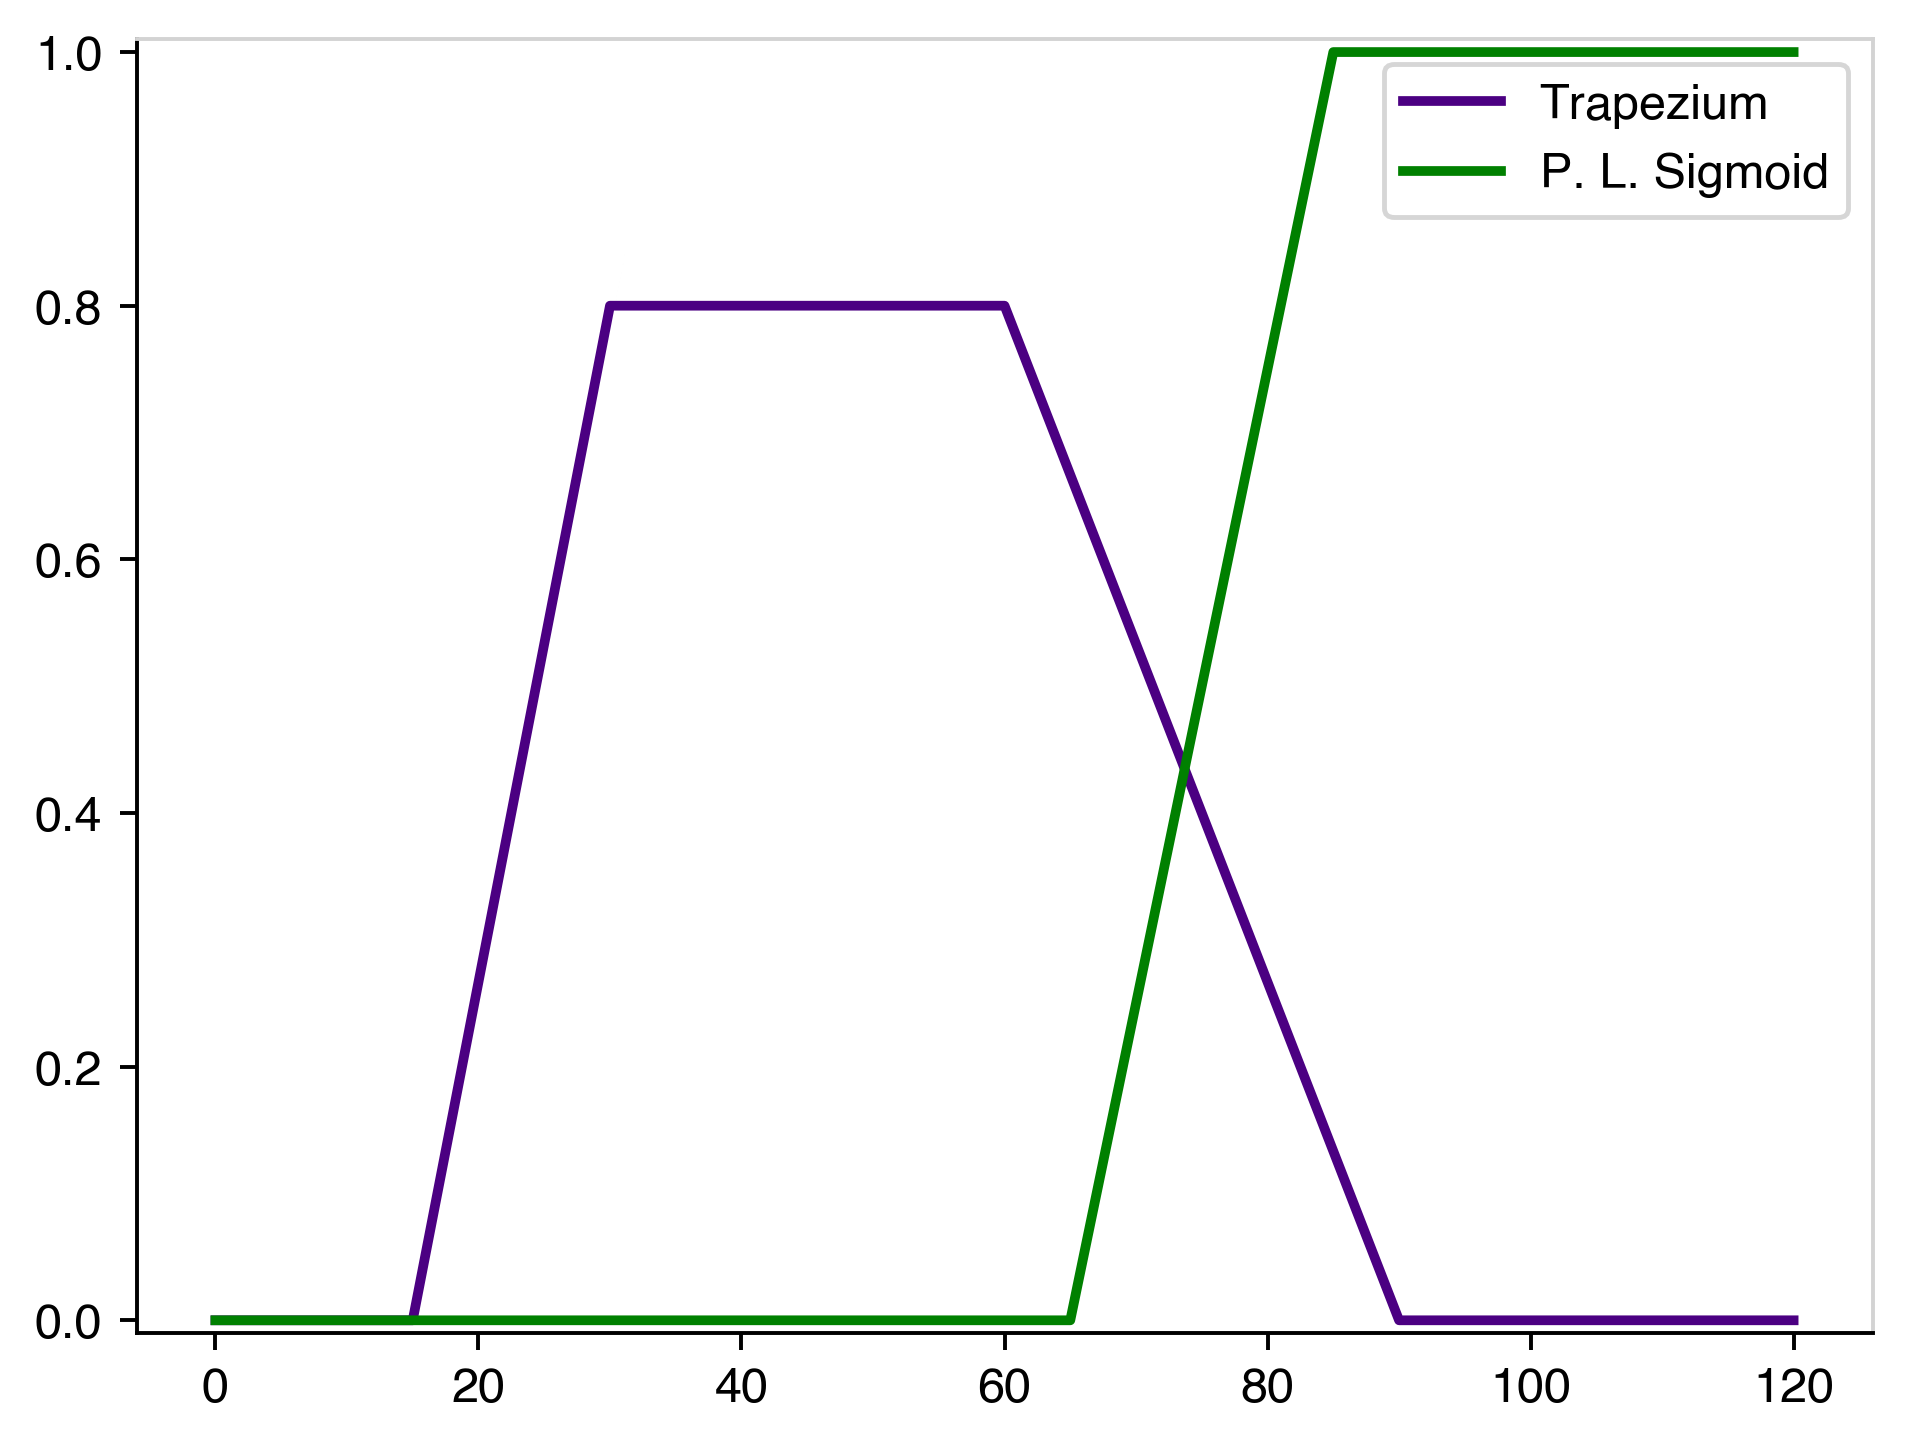

In [43]:
# Example usage
fig, ax = make_mf_figure(x_uod, default_mf_arrays, plot_colors=plot_colors)
plt.show()


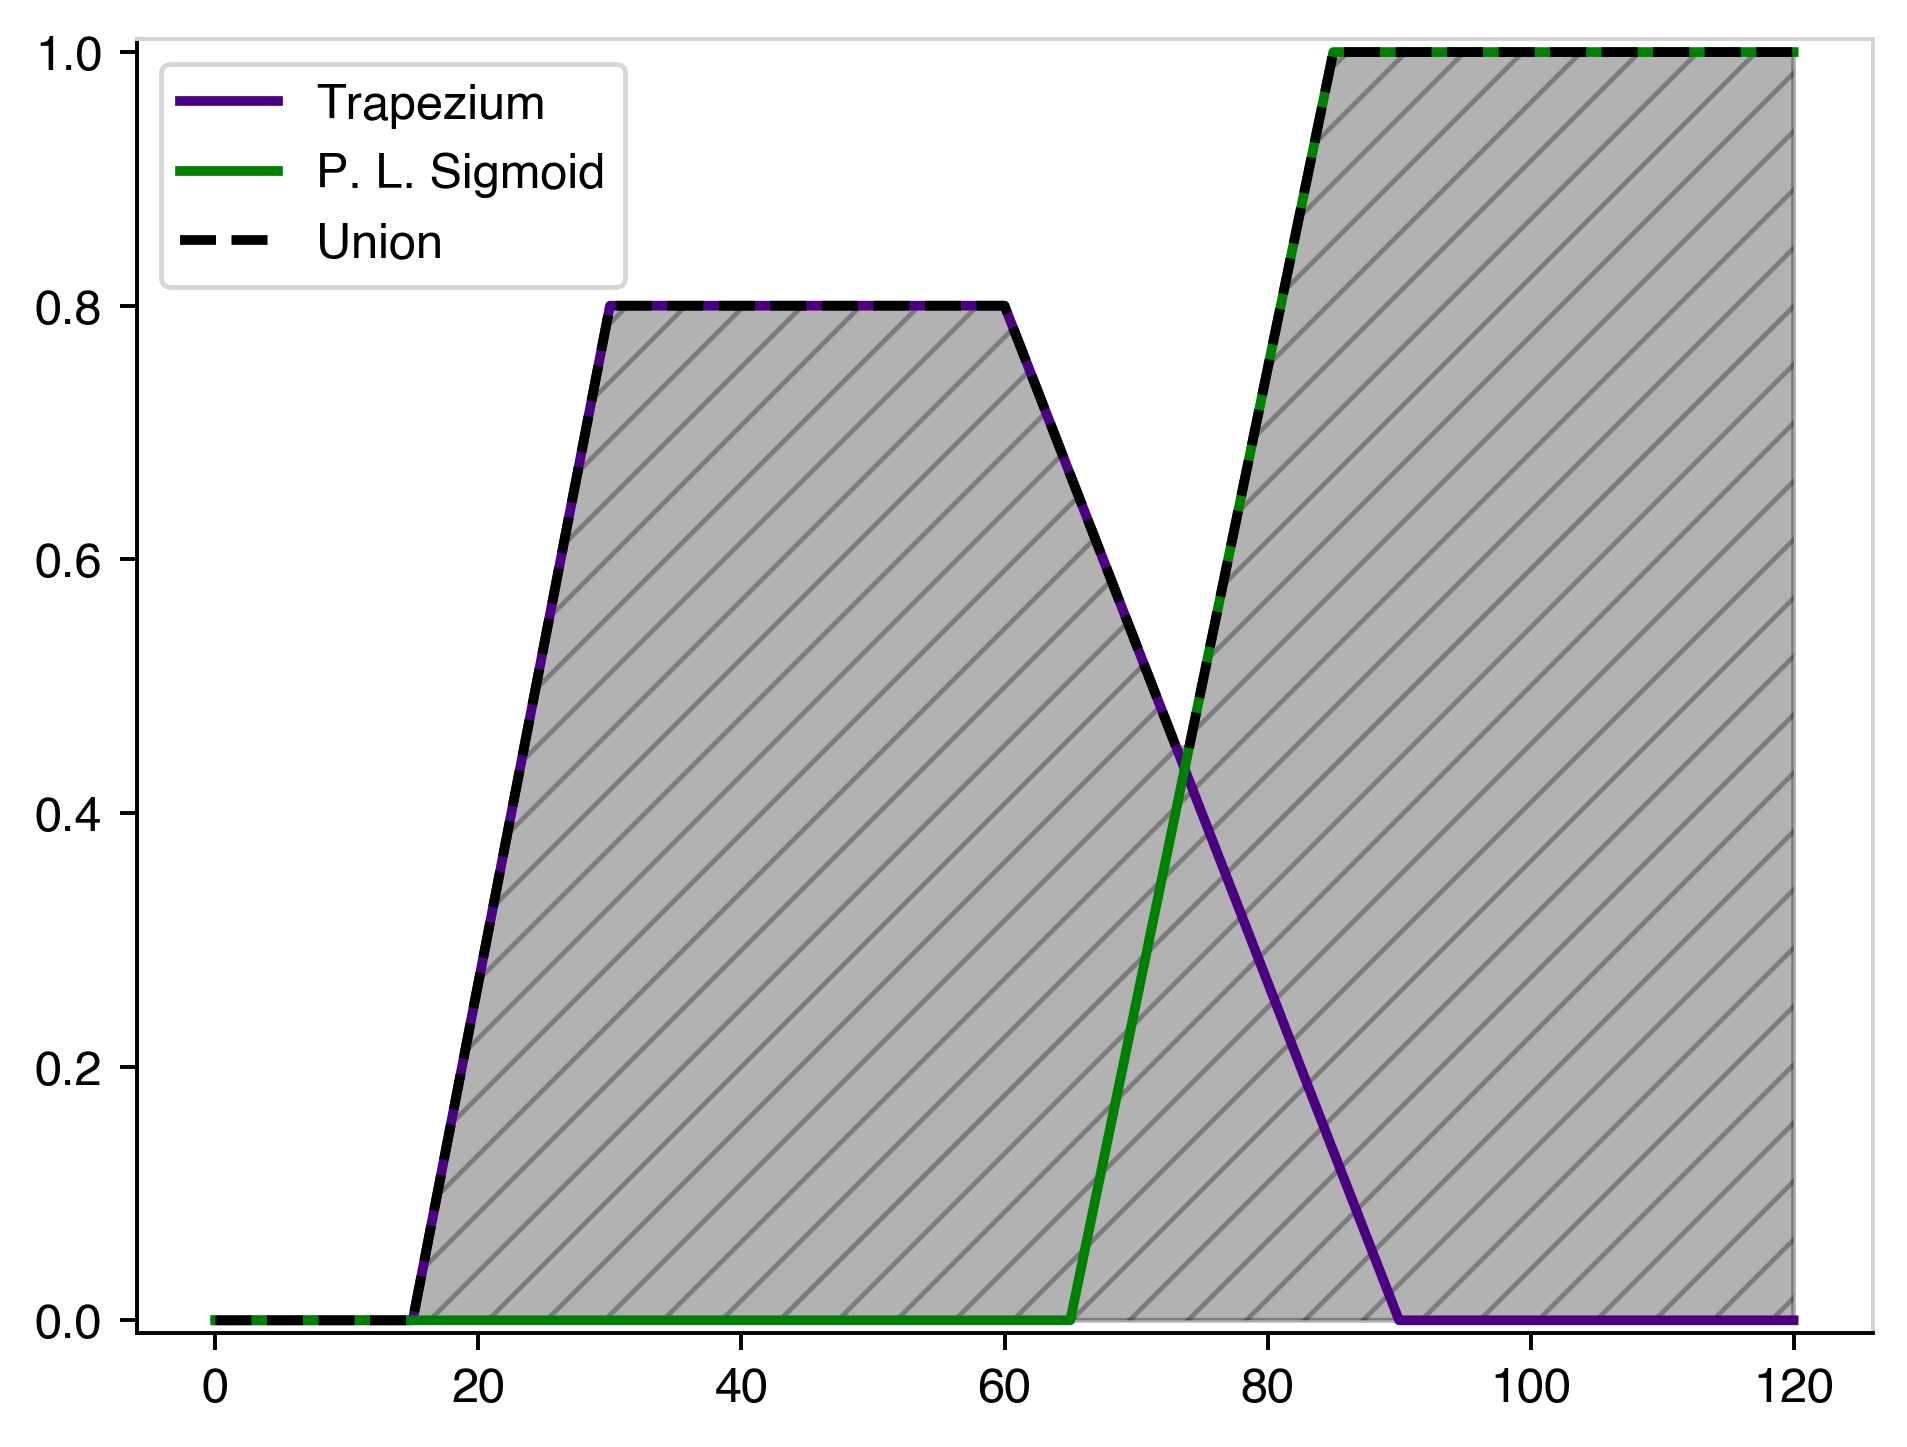

In [44]:

fig, ax = make_mf_figure(x_uod, default_mf_arrays, plot_union=True, plot_colors=plot_colors)
plt.show()

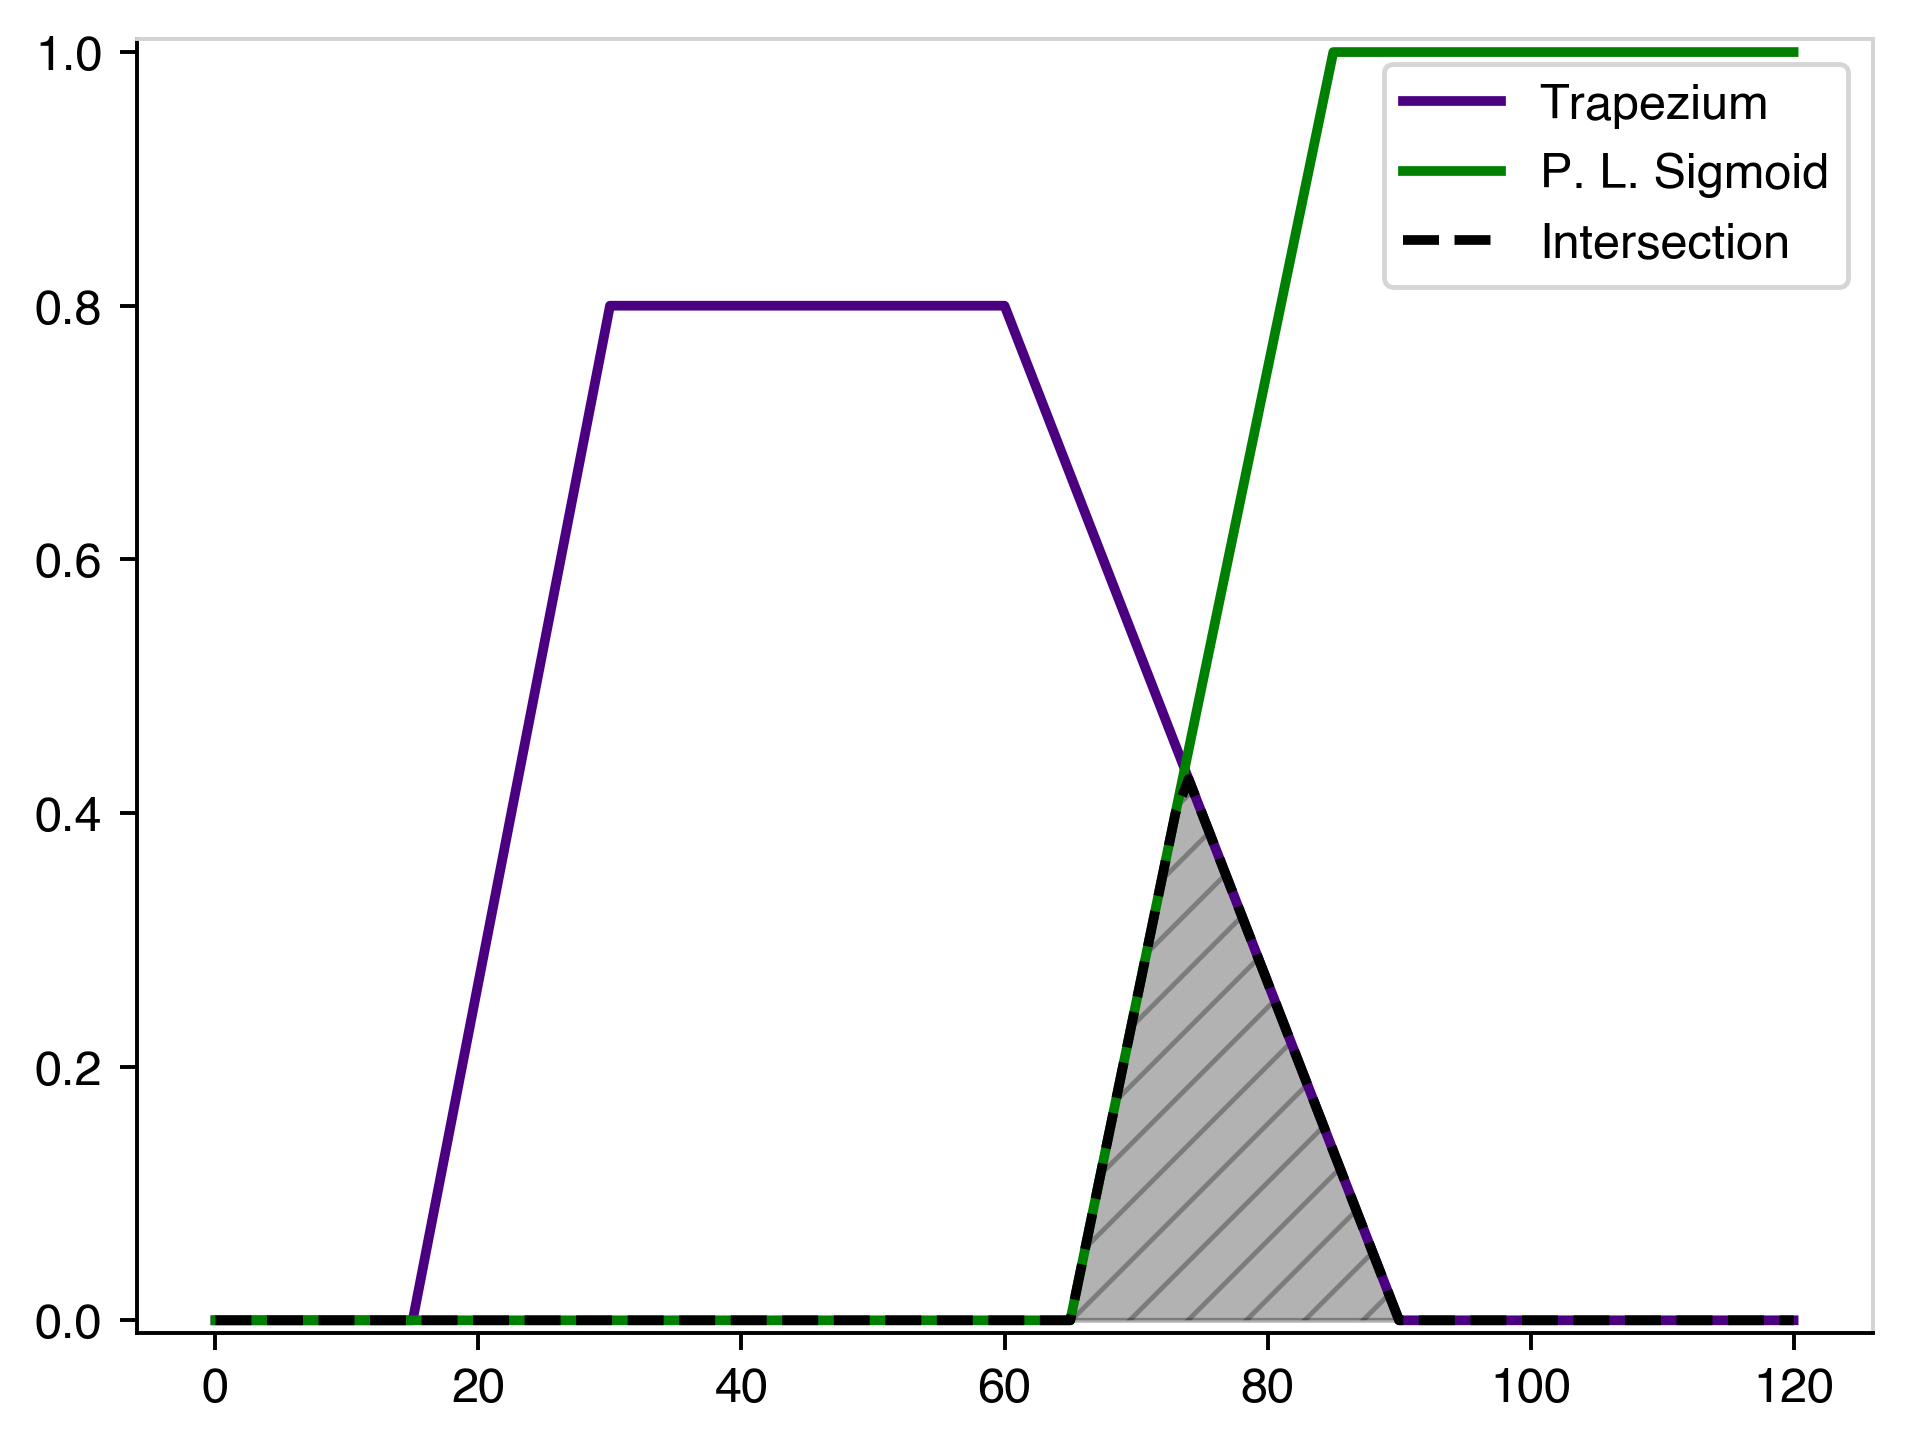

In [45]:
fig, ax = make_mf_figure(x_uod, default_mf_arrays, plot_intersection=True, plot_colors=plot_colors)
plt.show()

In [46]:
# Test the trapezoidal function 
# M quintuple p59 in Dubois and Prade has the meaning as:
# M = (m_lower, m_upper, alpha, beta, height) - refer to docstring for trapz_function

# Universe of discourse, or x-axis range and quantization/resolution
x_uod = np.arange(0,121,1)

# To test four examples on p58 (without the union singletons for simplicity):
sources = {}

# source A: singleton
sources["A"] = (100, 100, 0, 0, 1) 

# source B: trapezoid
sources["B"] = (50,70,10,30,0.9)

# source C: top hat 
sources["C"] = (100,110,0,0,1)

# source D: right-angled triangle
sources["D"] = (20, 20, 0, 10, 0.8)

# This isn't in book, but a symmetrical triangle function for source E.
sources["E"] = (60, 60, 20, 20, 0.5)

# This isn't in book, but piecewise linear sigmoid for source F.
# This needs only 3 parameters: midpoint, width, height
sources["F"] = (50,20, 0.88)




/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_62037/1234798075.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


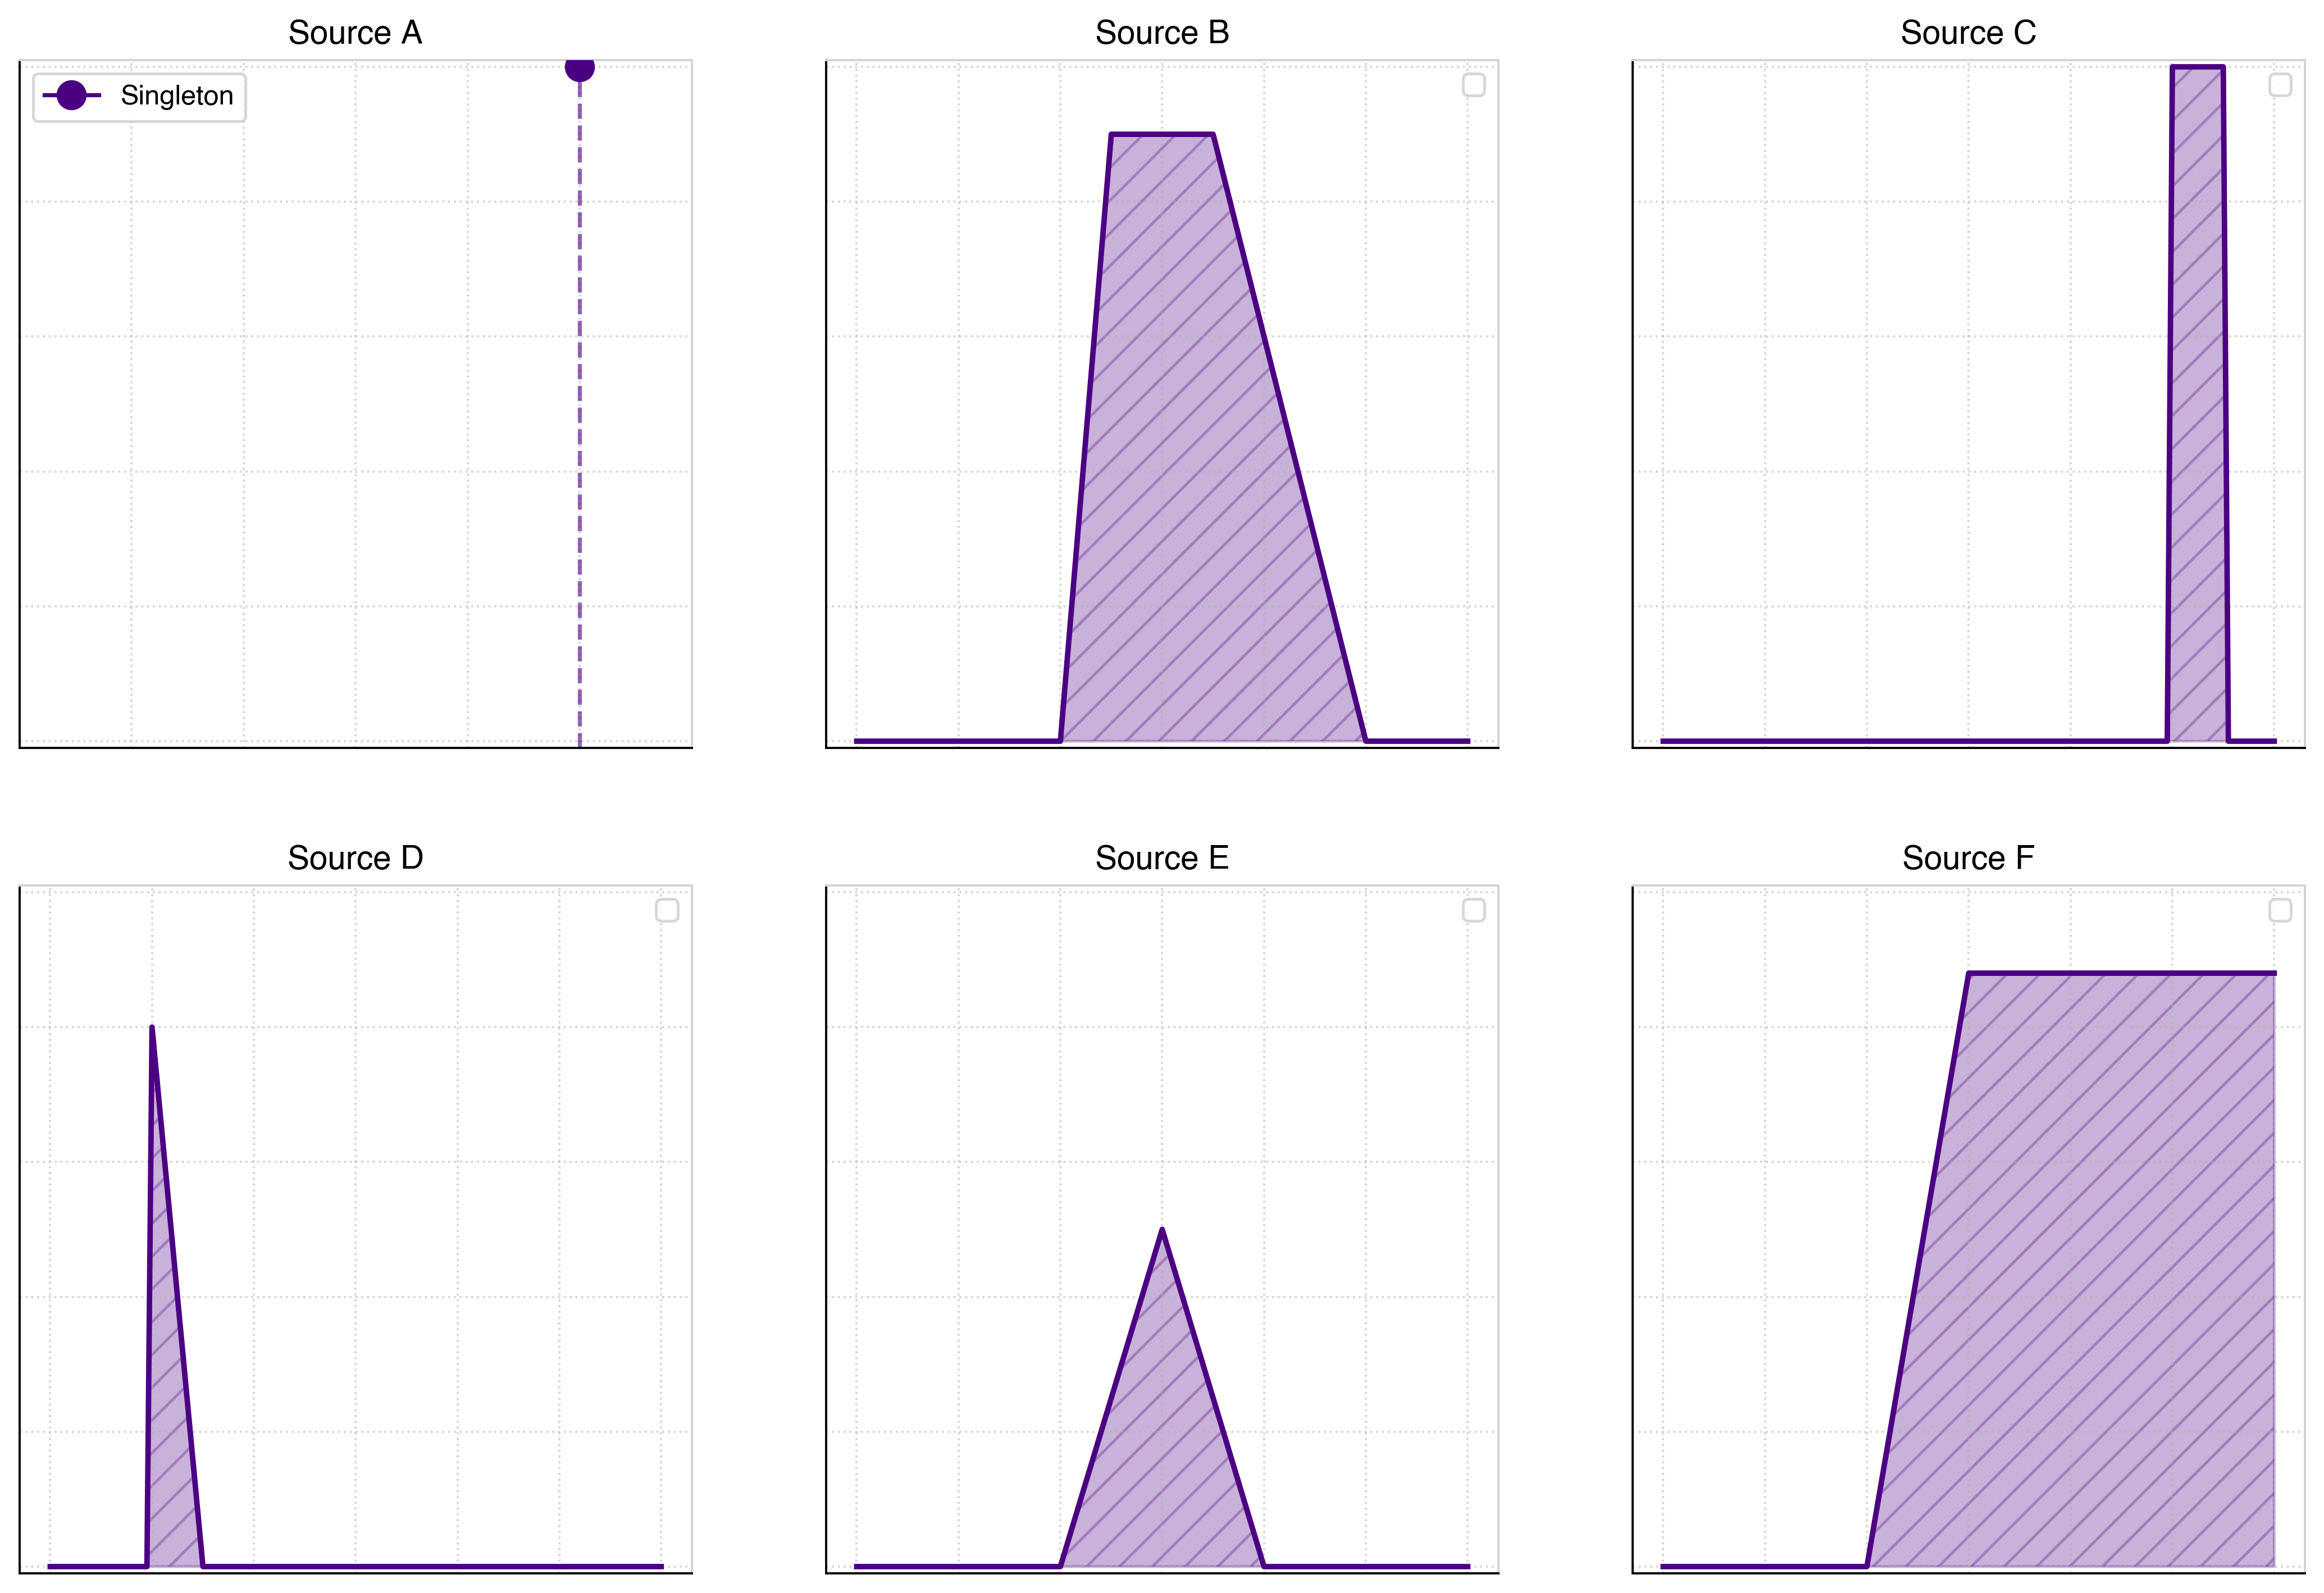

In [47]:
# Plot all five on a 2-row, 3-column subplot figure
fig, _axes = plt.subplots(2, 3, figsize=(15, 10))
axes = iter(_axes.flatten())

for M in sources.keys():
    ax = next(axes)
    
    # Add title to axis based on the source
    ax.set_title(f"Source {M}")
    
    if M == "F":
        y = piecewise_linear_sigmoid(x_uod, *sources[M])
    else:
        y = trapz_function(x_uod, *sources[M],)
    plot_mf(ax, x_uod, y, plot_fill=True)
    
    # Remove ticks and numbering from axes and add faint gridlines instead 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, 
                        right=False, labelbottom=False, labelleft=False)
    ax.grid(True, linestyle=':', alpha=0.5)

plt.show()

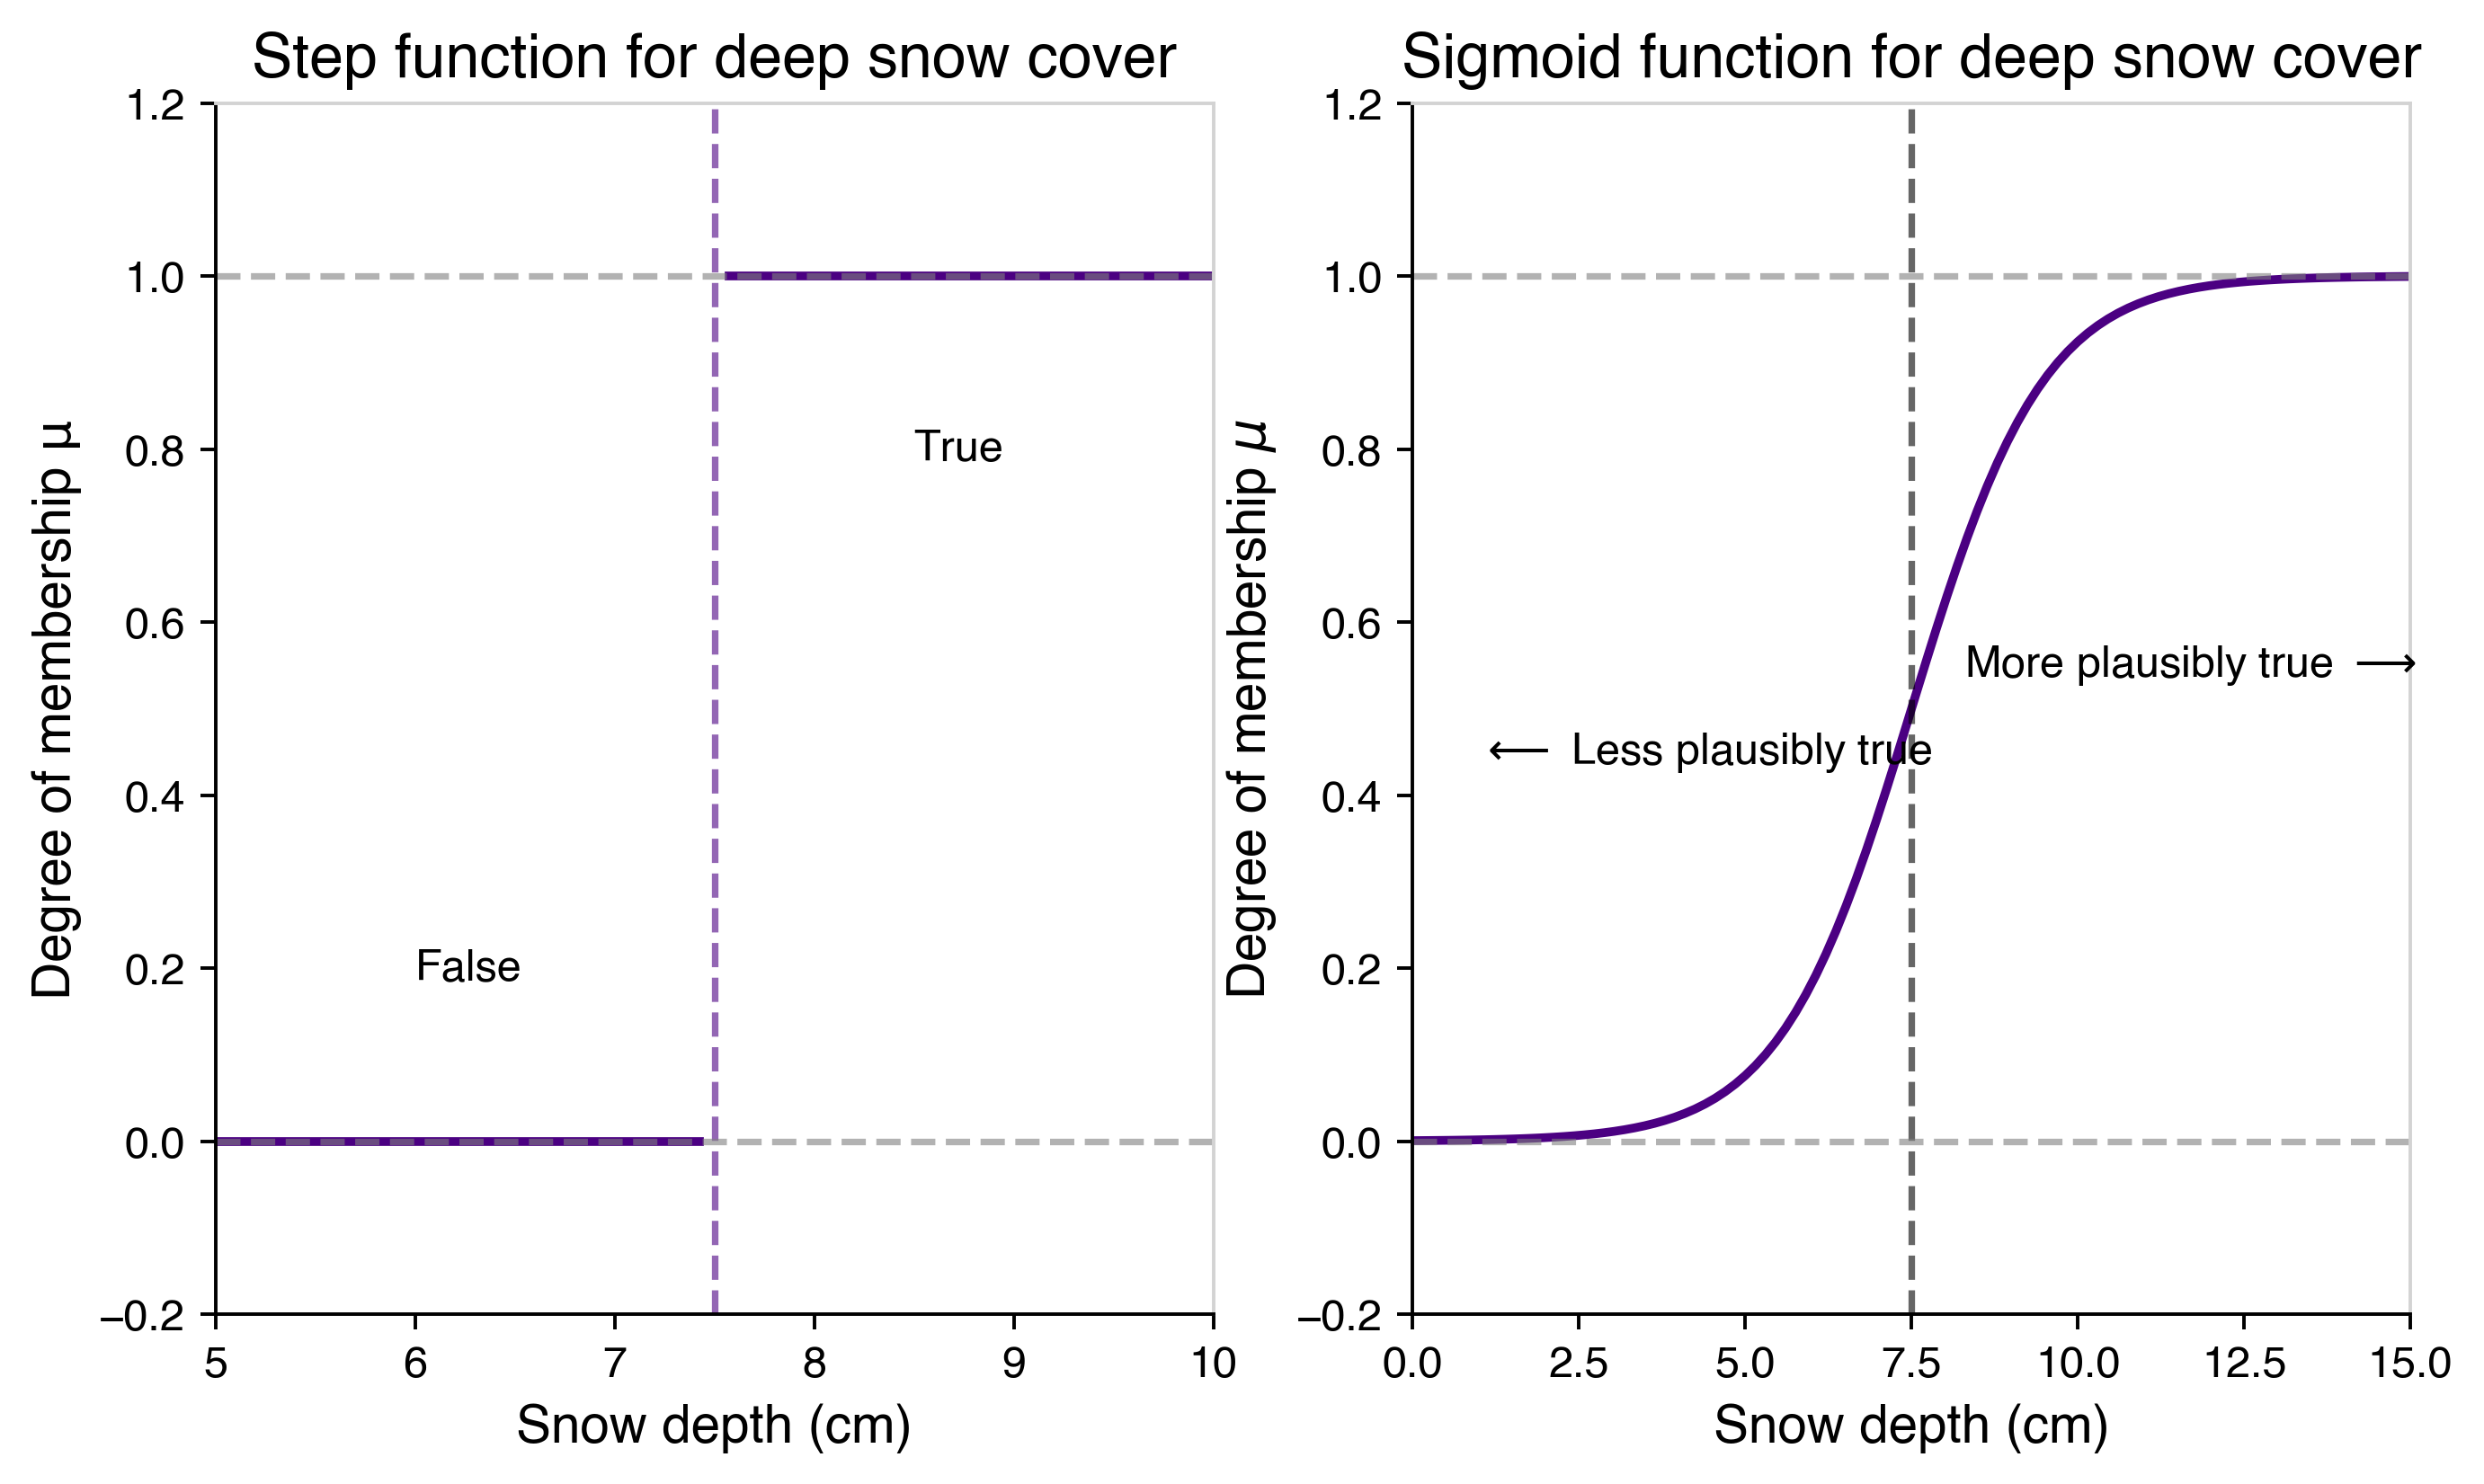

In [48]:
# Show the difference between binary and fuzzy logic
fig, axes = make_binary_figure(["step", "sigmoid"])
plt.show()

The two membership function shapes we use will be trapzoidal (piecewise linear Gaussian curves, kind-of) and piecewise linear sigmoids.

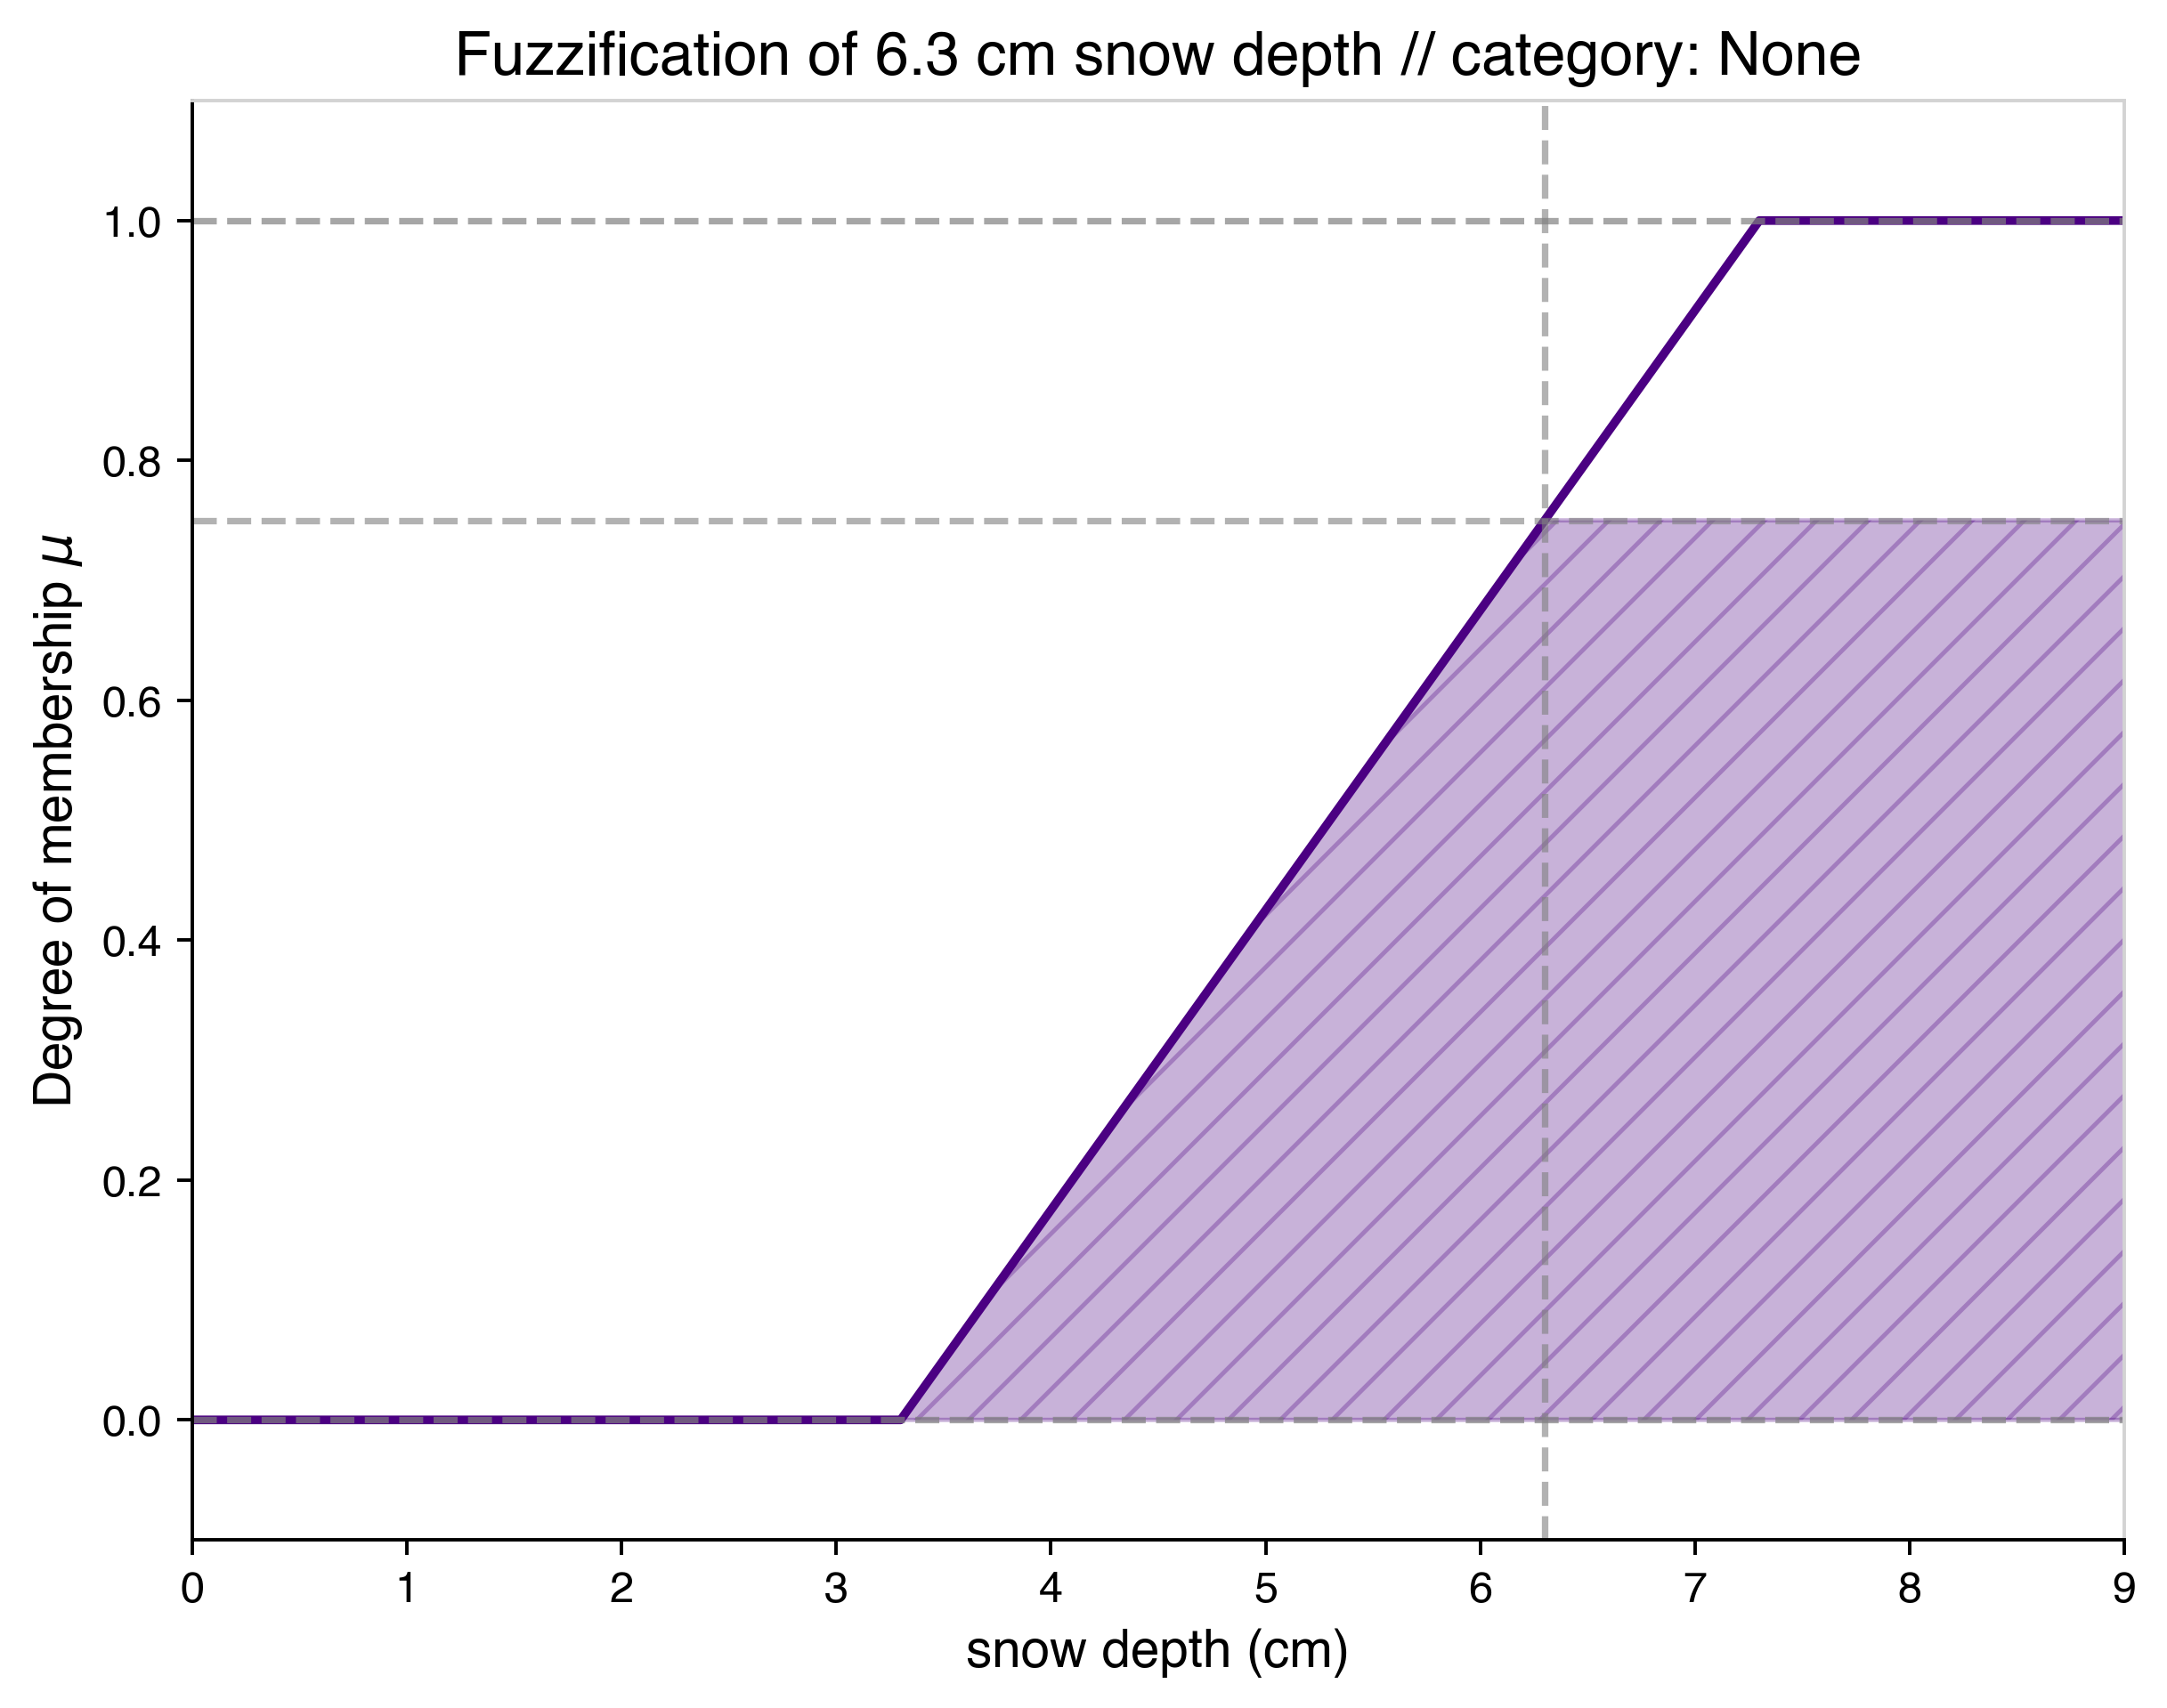

In [49]:
fig, ax = plot_fuzzification(x_uod=np.arange(0,10,0.1), x_value=6.3, mf_func="pl_sigmoid", xlim=(0,9))
plt.show()

## Maths of Fuzzy Inference: supremum and infimum, OR, AND, etc
More about the maths here, and how we join criteria (AND = min) then aggregated rules (OR = max = possibility)

We'll have a rule that says if snow is deep and pressure is high, then ozone is elevated.
We will only define membership function for these three variables and categories as an example

Then we fuzzify for the values of pressure = 1040 hPa, snow = 9cm, and establish the degree of membership for ozone.

In [50]:
# 

### Computing activation of rules

In [51]:
# Taking simple rule:

# if snow is deep and wind is calm, then ozone is elevated

# cm
snow_uod = np.arange(0, 30.1, 0.1)

# m/s
wind_uod = np.arange(0, 5, 0.125)

# ppb
ozone_uod = np.arange(20, 140, 0.1)



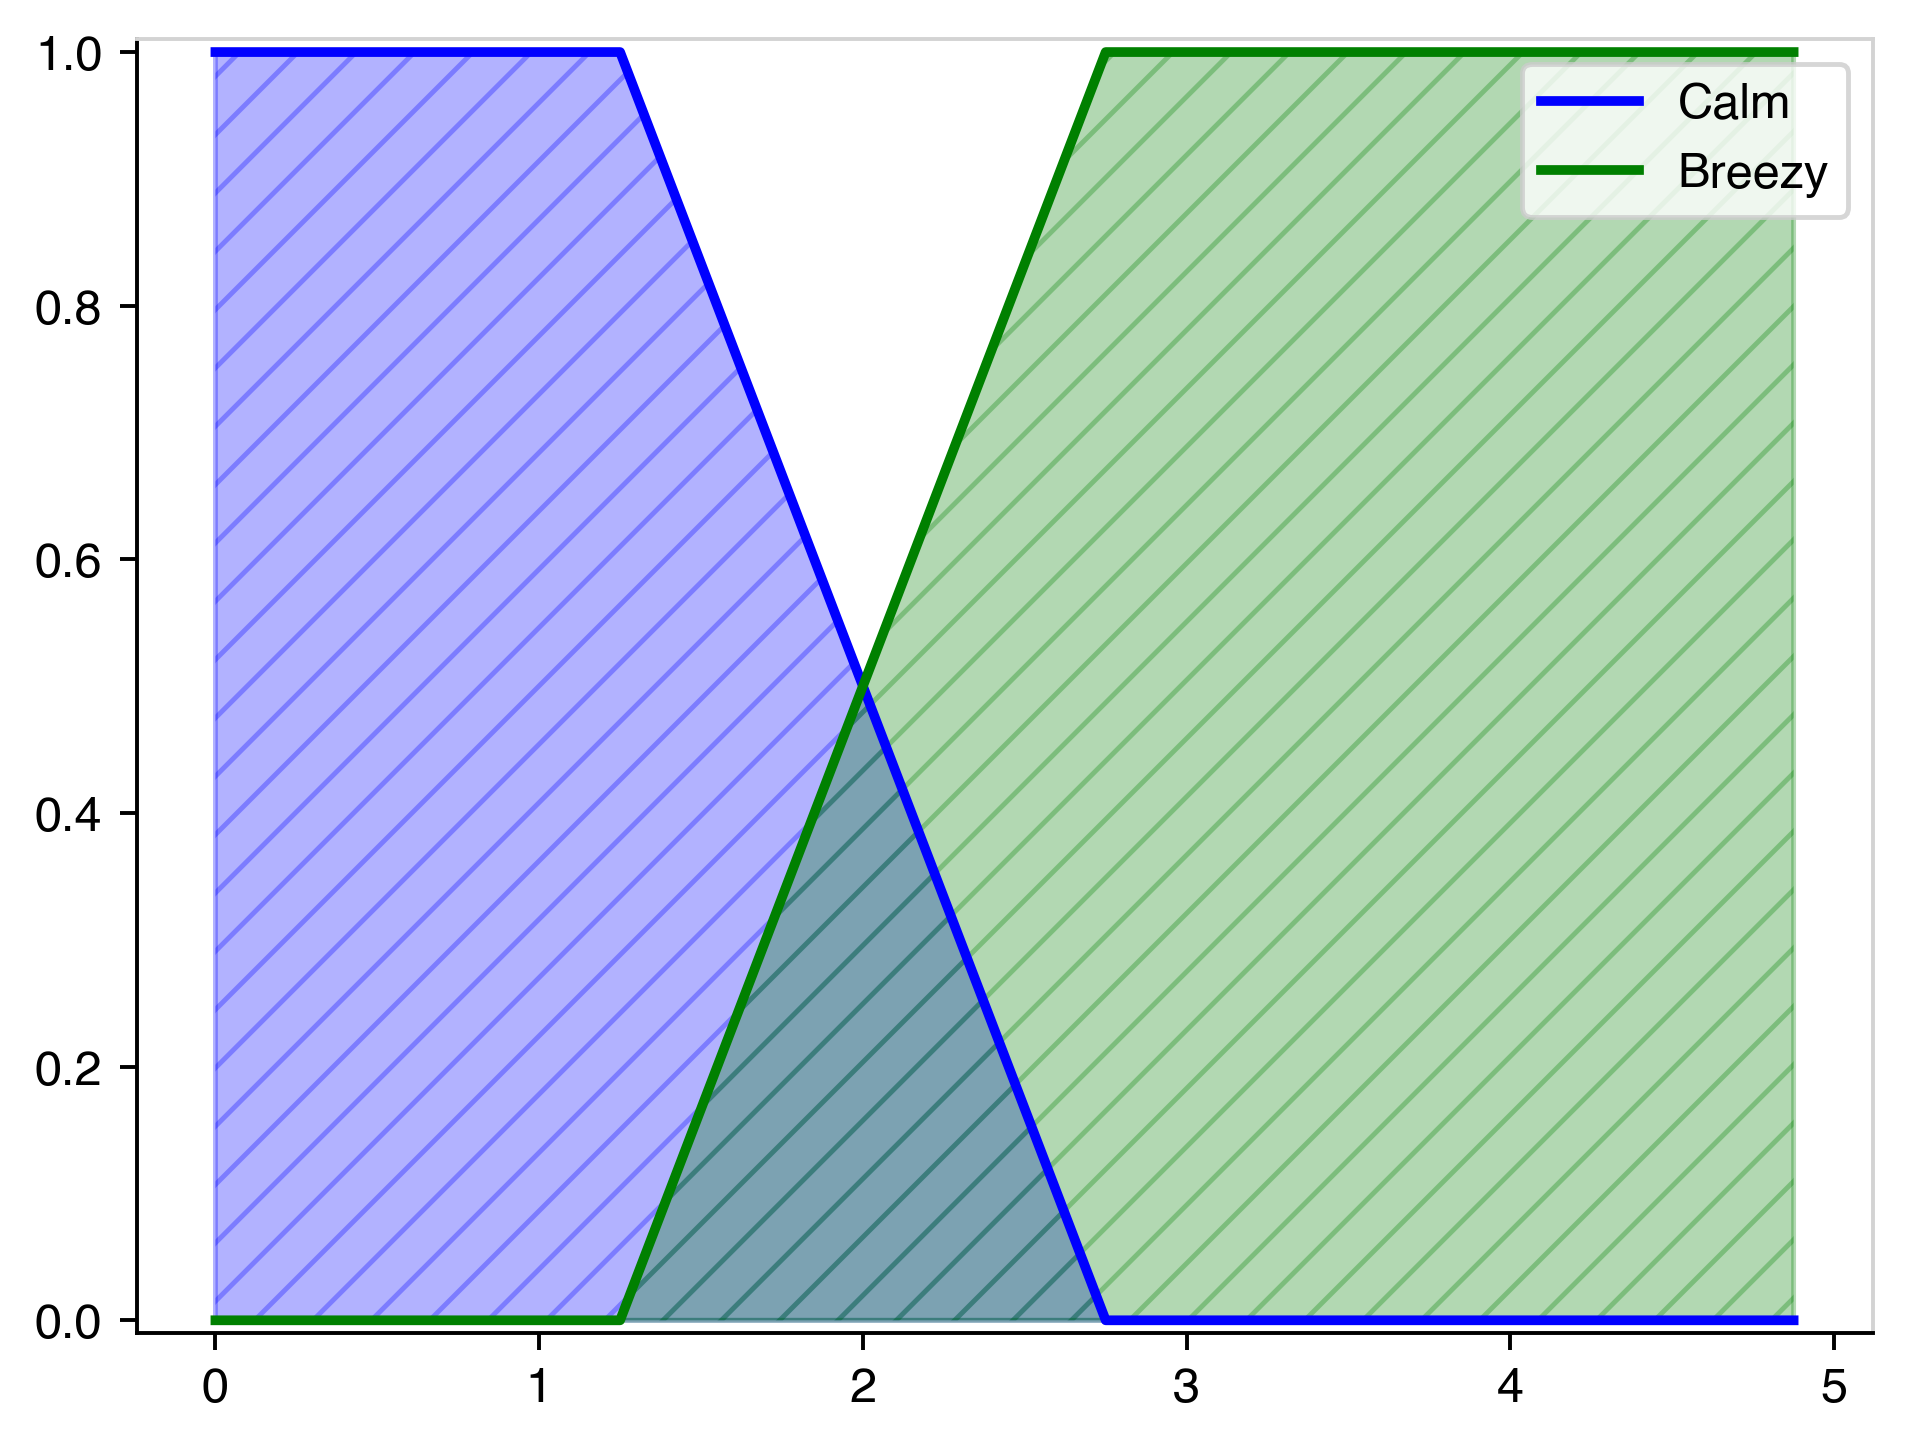

In [52]:
# Create wind membership: "calm" and "breezy" categories (fuzzy sets)
wind_calm = piecewise_linear_sigmoid(wind_uod, 2.0, 1.5, 1.0, direction="decreasing")
wind_breezy = piecewise_linear_sigmoid(wind_uod, 2.0, 1.5, 1.0, direction="increasing")

# Plot both functions on the same axis 
fig, ax = plt.subplots(1)
ax = plot_mf(ax, wind_uod, wind_calm, label="Calm", line_color="blue", plot_fill=True)
ax = plot_mf(ax, wind_uod, wind_breezy, label="Breezy", line_color="green", plot_fill=True)
plt.show()


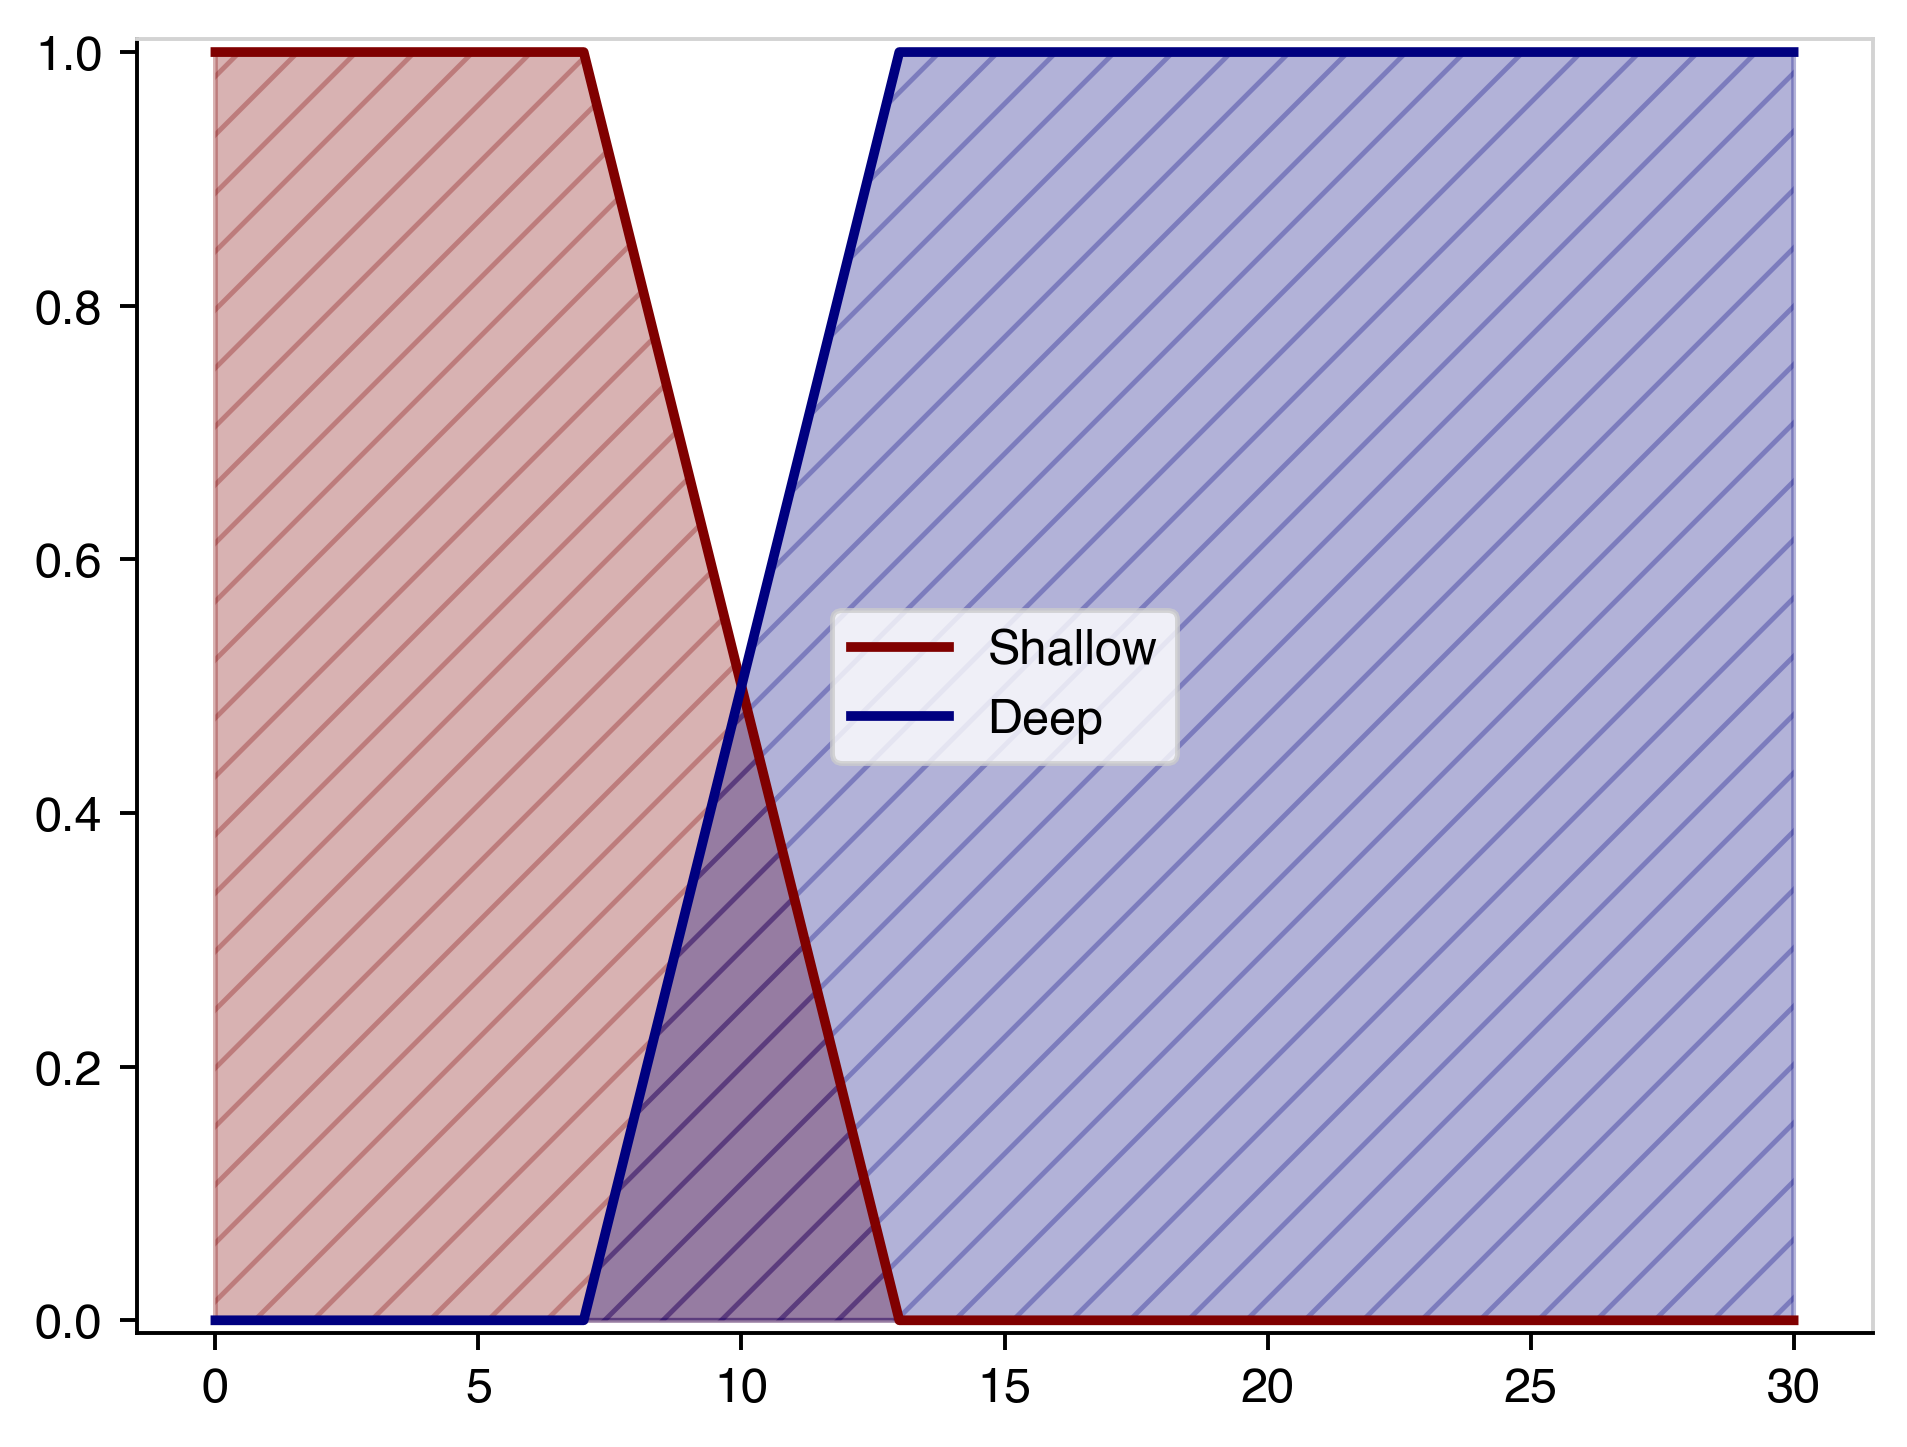

In [53]:

# Snow membership 
snow_deep = piecewise_linear_sigmoid(snow_uod, 10, 6, 1.0)
snow_shallow = piecewise_linear_sigmoid(snow_uod, 10, 6, 1.0, direction="decreasing")

# Plot both functions on the same axis 
fig, ax = plt.subplots(1)
ax = plot_mf(ax, snow_uod, snow_shallow, label="Shallow", line_color="maroon", plot_fill=True)
ax = plot_mf(ax, snow_uod, snow_deep, label="Deep", line_color="navy", plot_fill=True)
plt.show()

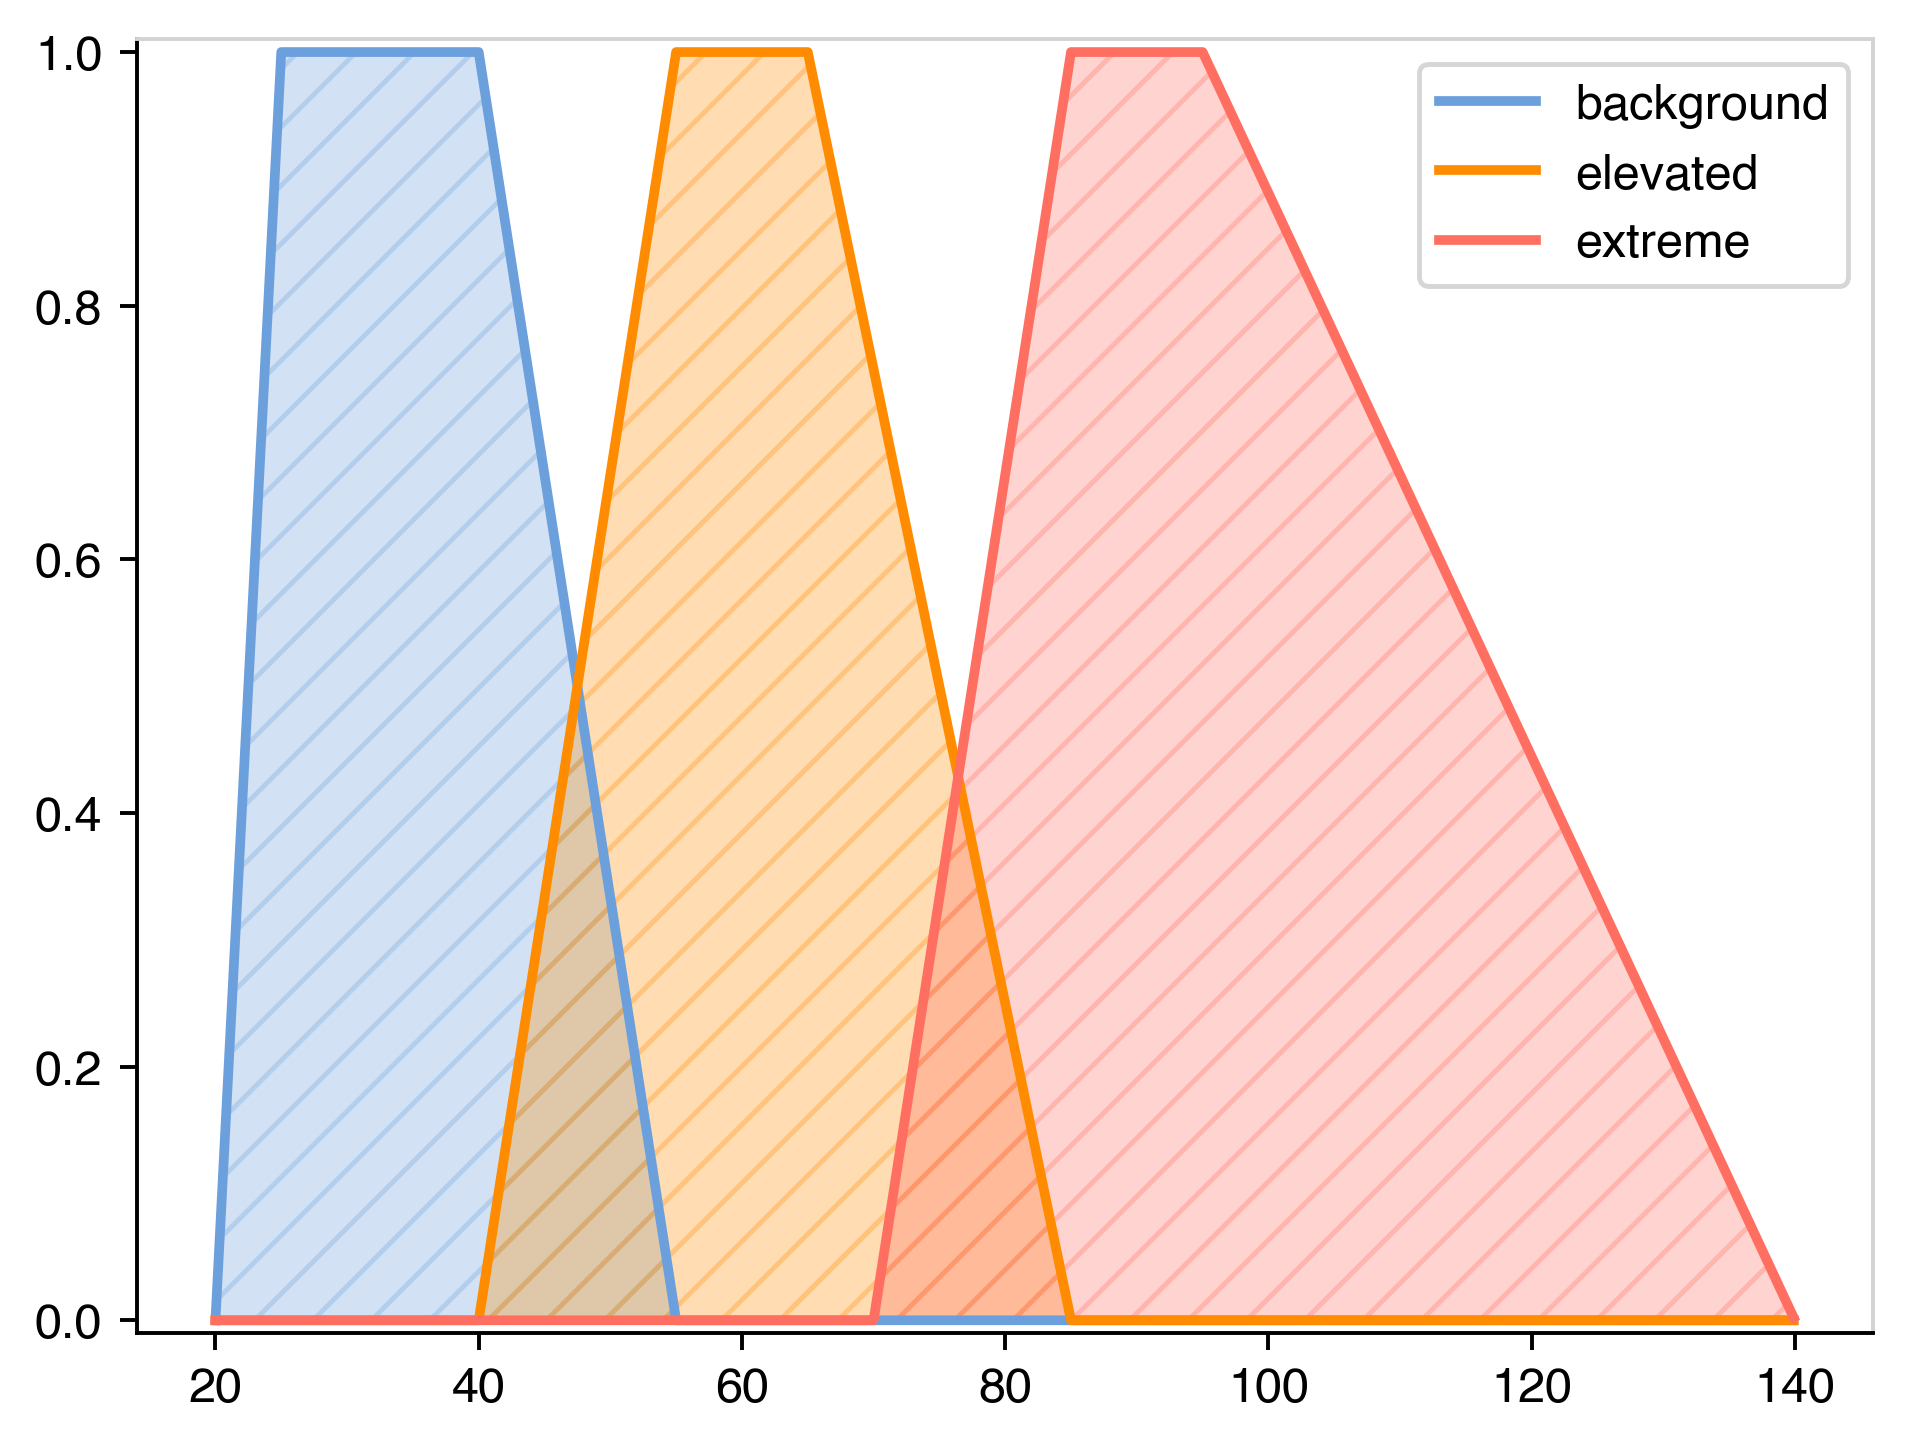

In [54]:
# Ozone membership
ozone_mfs = {}
ozone_mfs["background"] = trapz_function(ozone_uod, 25, 40, 5, 15, 1.0)
ozone_mfs["elevated"] = trapz_function(ozone_uod, 55, 65, 15, 20, 1.0)
ozone_mfs["extreme"] = trapz_function(ozone_uod, 85, 95, 15, 45, 1.0)


plot_colors = iter(ozone_cats.values())
fig, ax = plt.subplots(1)
for category in ozone_mfs.keys():
    ax = plot_mf(ax, ozone_uod, ozone_mfs[category], label=category, line_color=next(plot_colors), plot_fill=True)
ax.legend()
plt.show()

In [55]:
# Fuzzify the inputs
snow_value = 9.3
wind_value = 1.6

0.38333333333333347


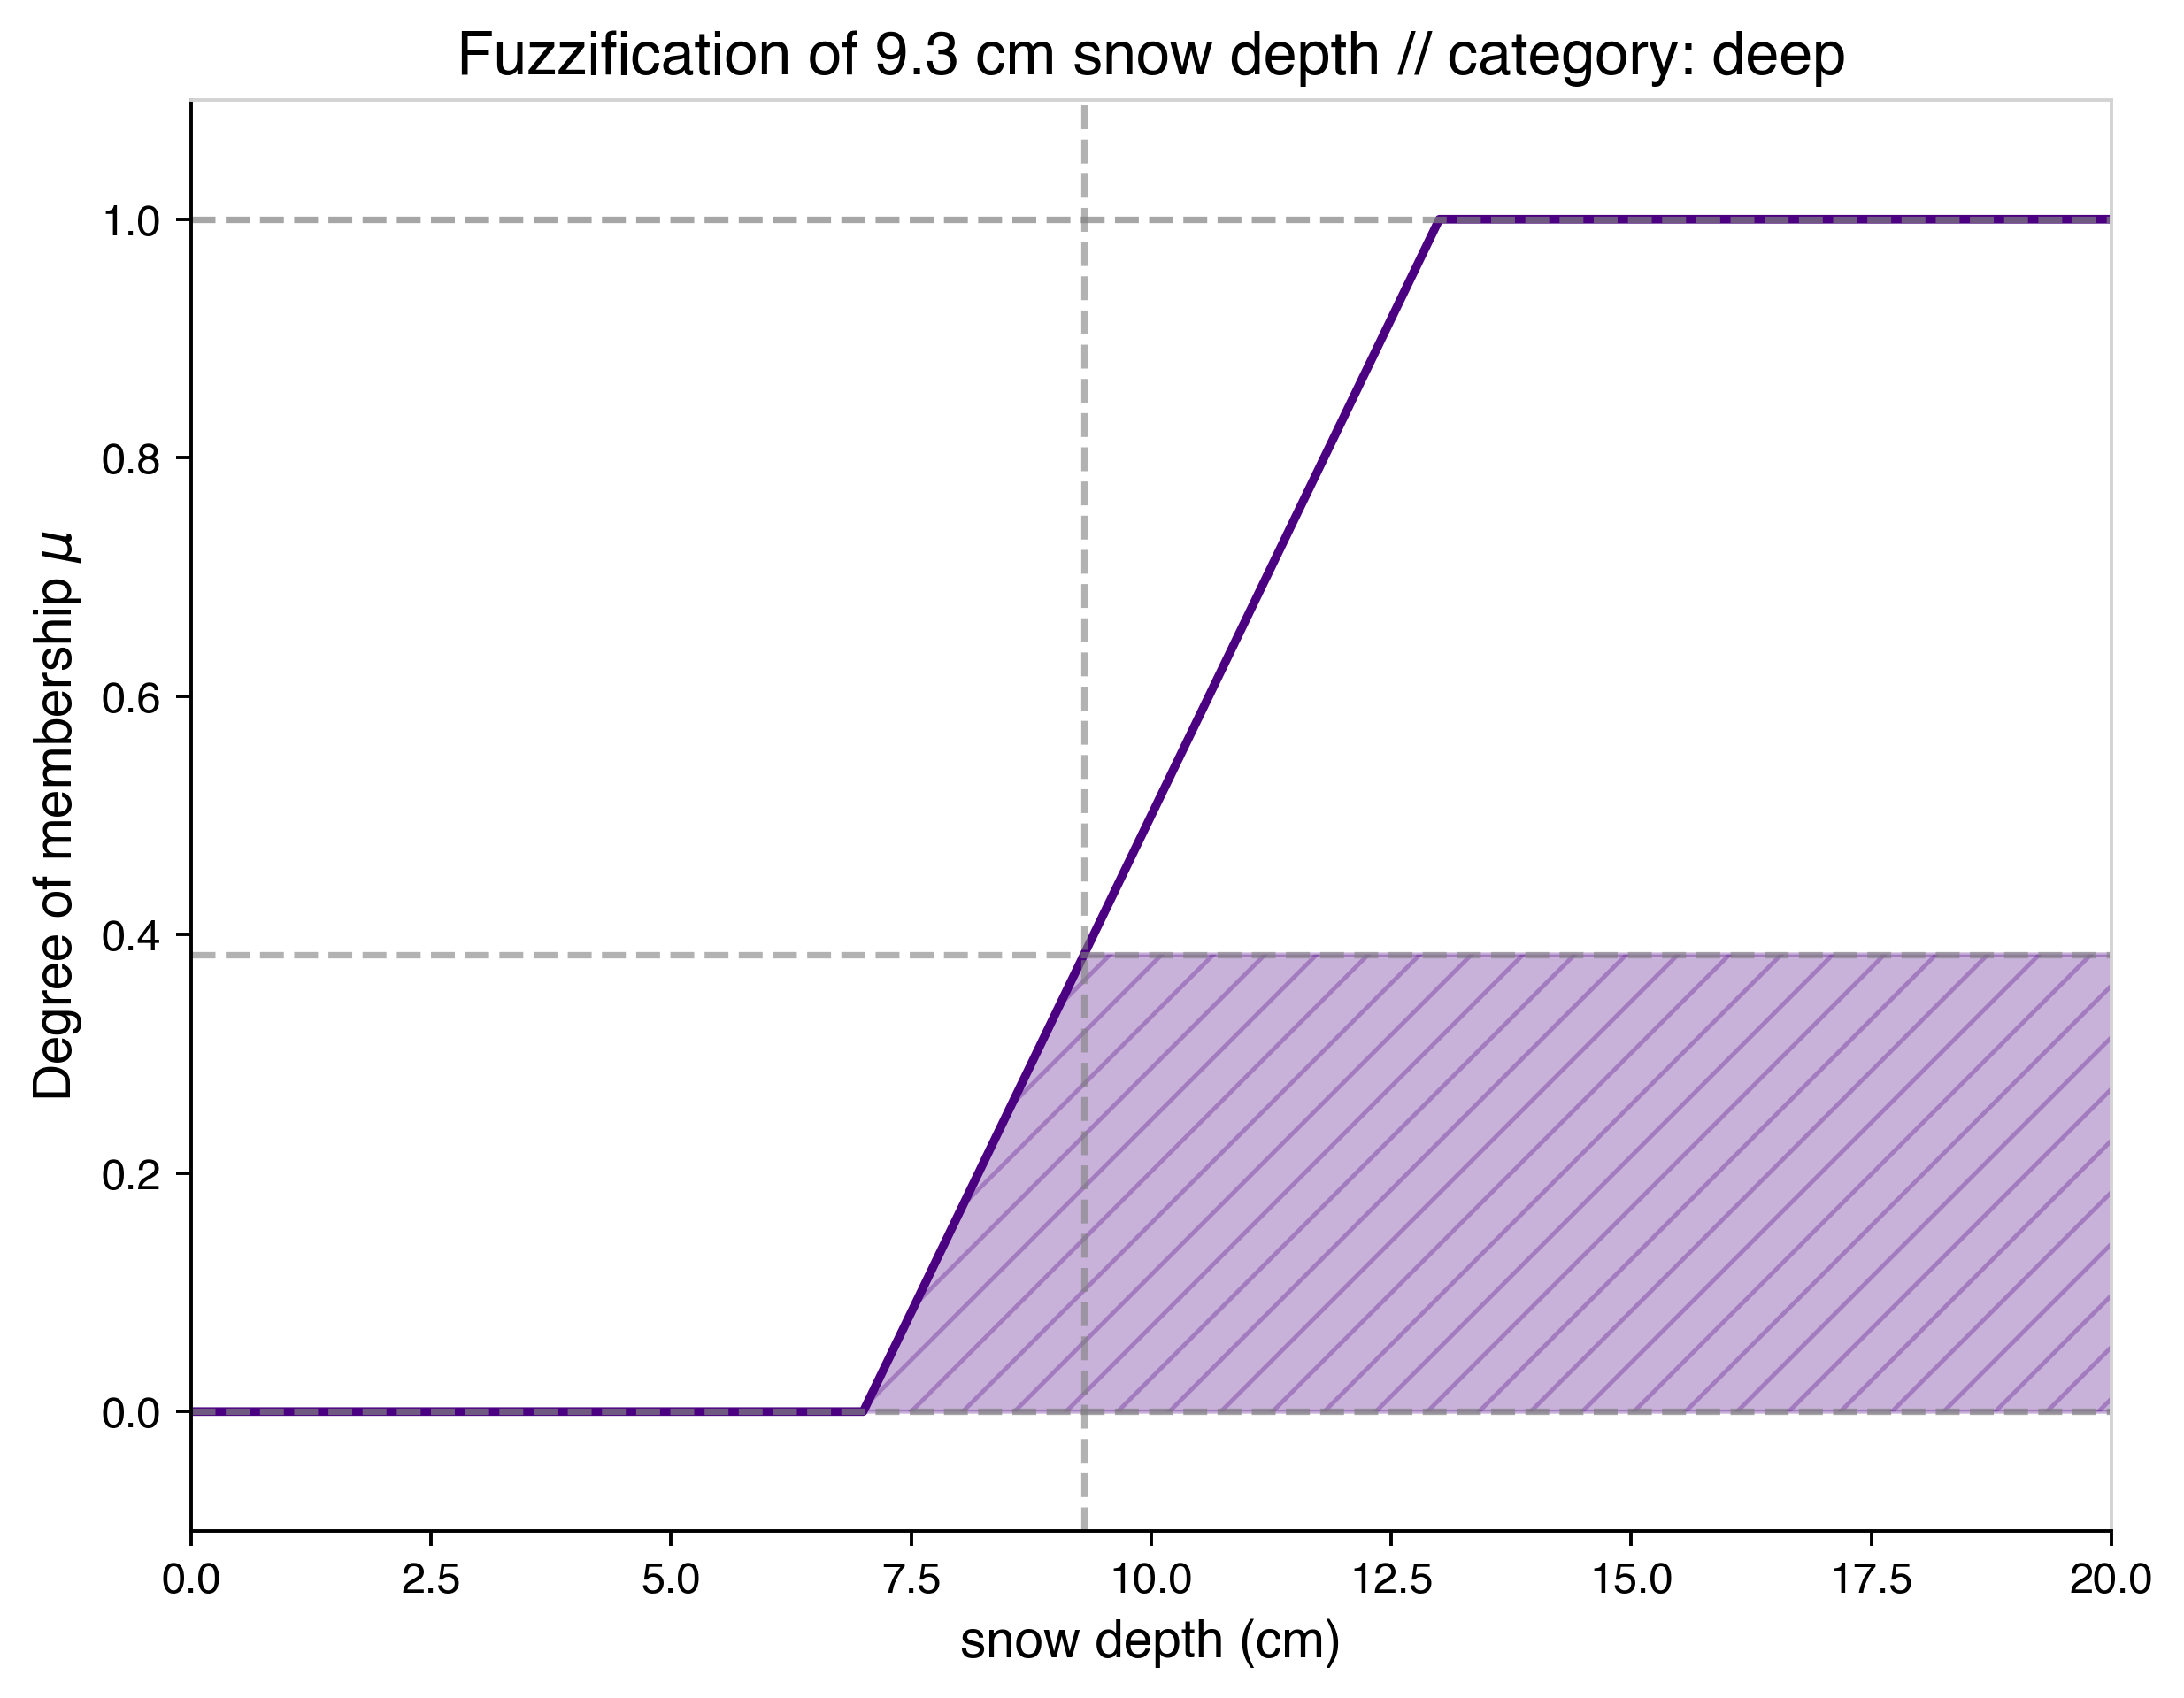

In [56]:
# Fuzzification


# Fuzzify the snow value
snow_membership = np.interp(snow_value, snow_uod, snow_deep)
print(snow_membership)

# Shown graphically:
fig, ax = plot_fuzzification(snow_uod, snow_value, mf_func=snow_deep, 
                                category_label="deep", xlim=(0, 20), 
                                variable_name="snow depth", vrbl_unit="cm")



0.7666666666666666


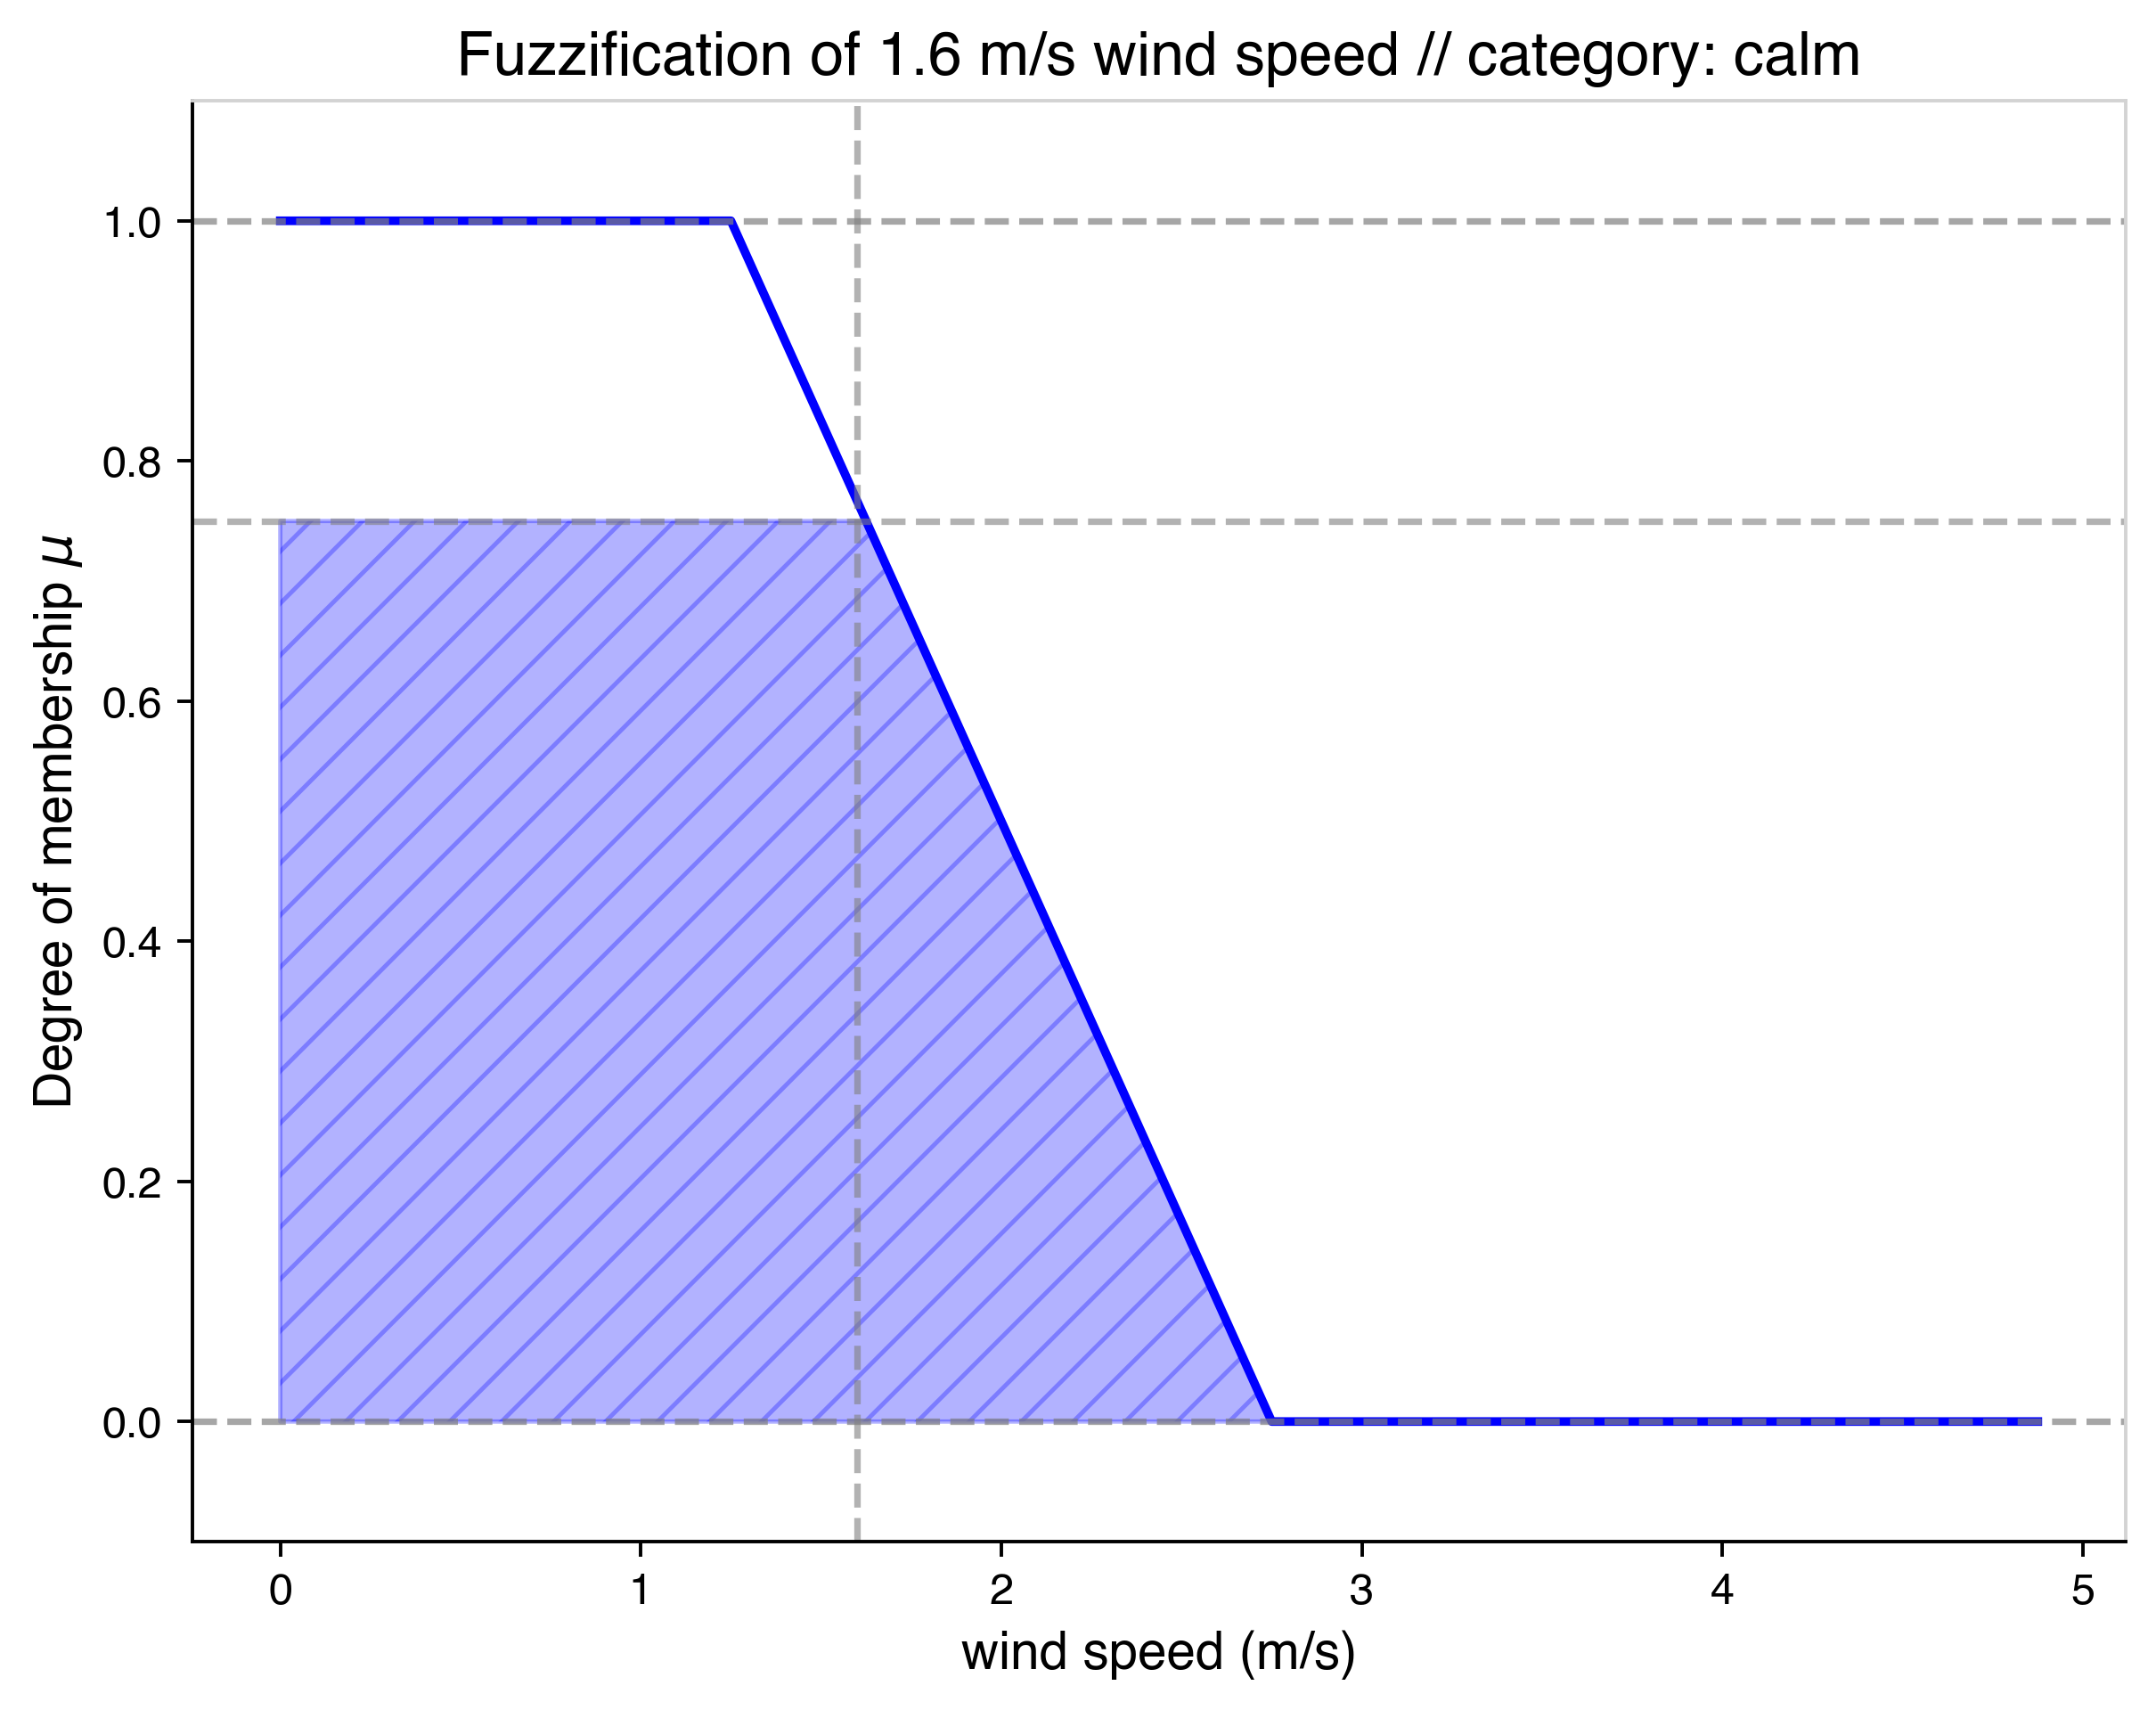

In [57]:
# Fuzzify the wind value
wind_membership = np.interp(wind_value, wind_uod, wind_calm)
print(wind_membership)

# Shown graphically:
fig, ax = plot_fuzzification(x_uod=wind_uod, mf_func=wind_calm, x_value=wind_value, 
                                fuzz_color="blue", category_label="calm", variable_name="wind speed",
                                vrbl_unit="m/s", direction="decreasing")


0.38333333333333347


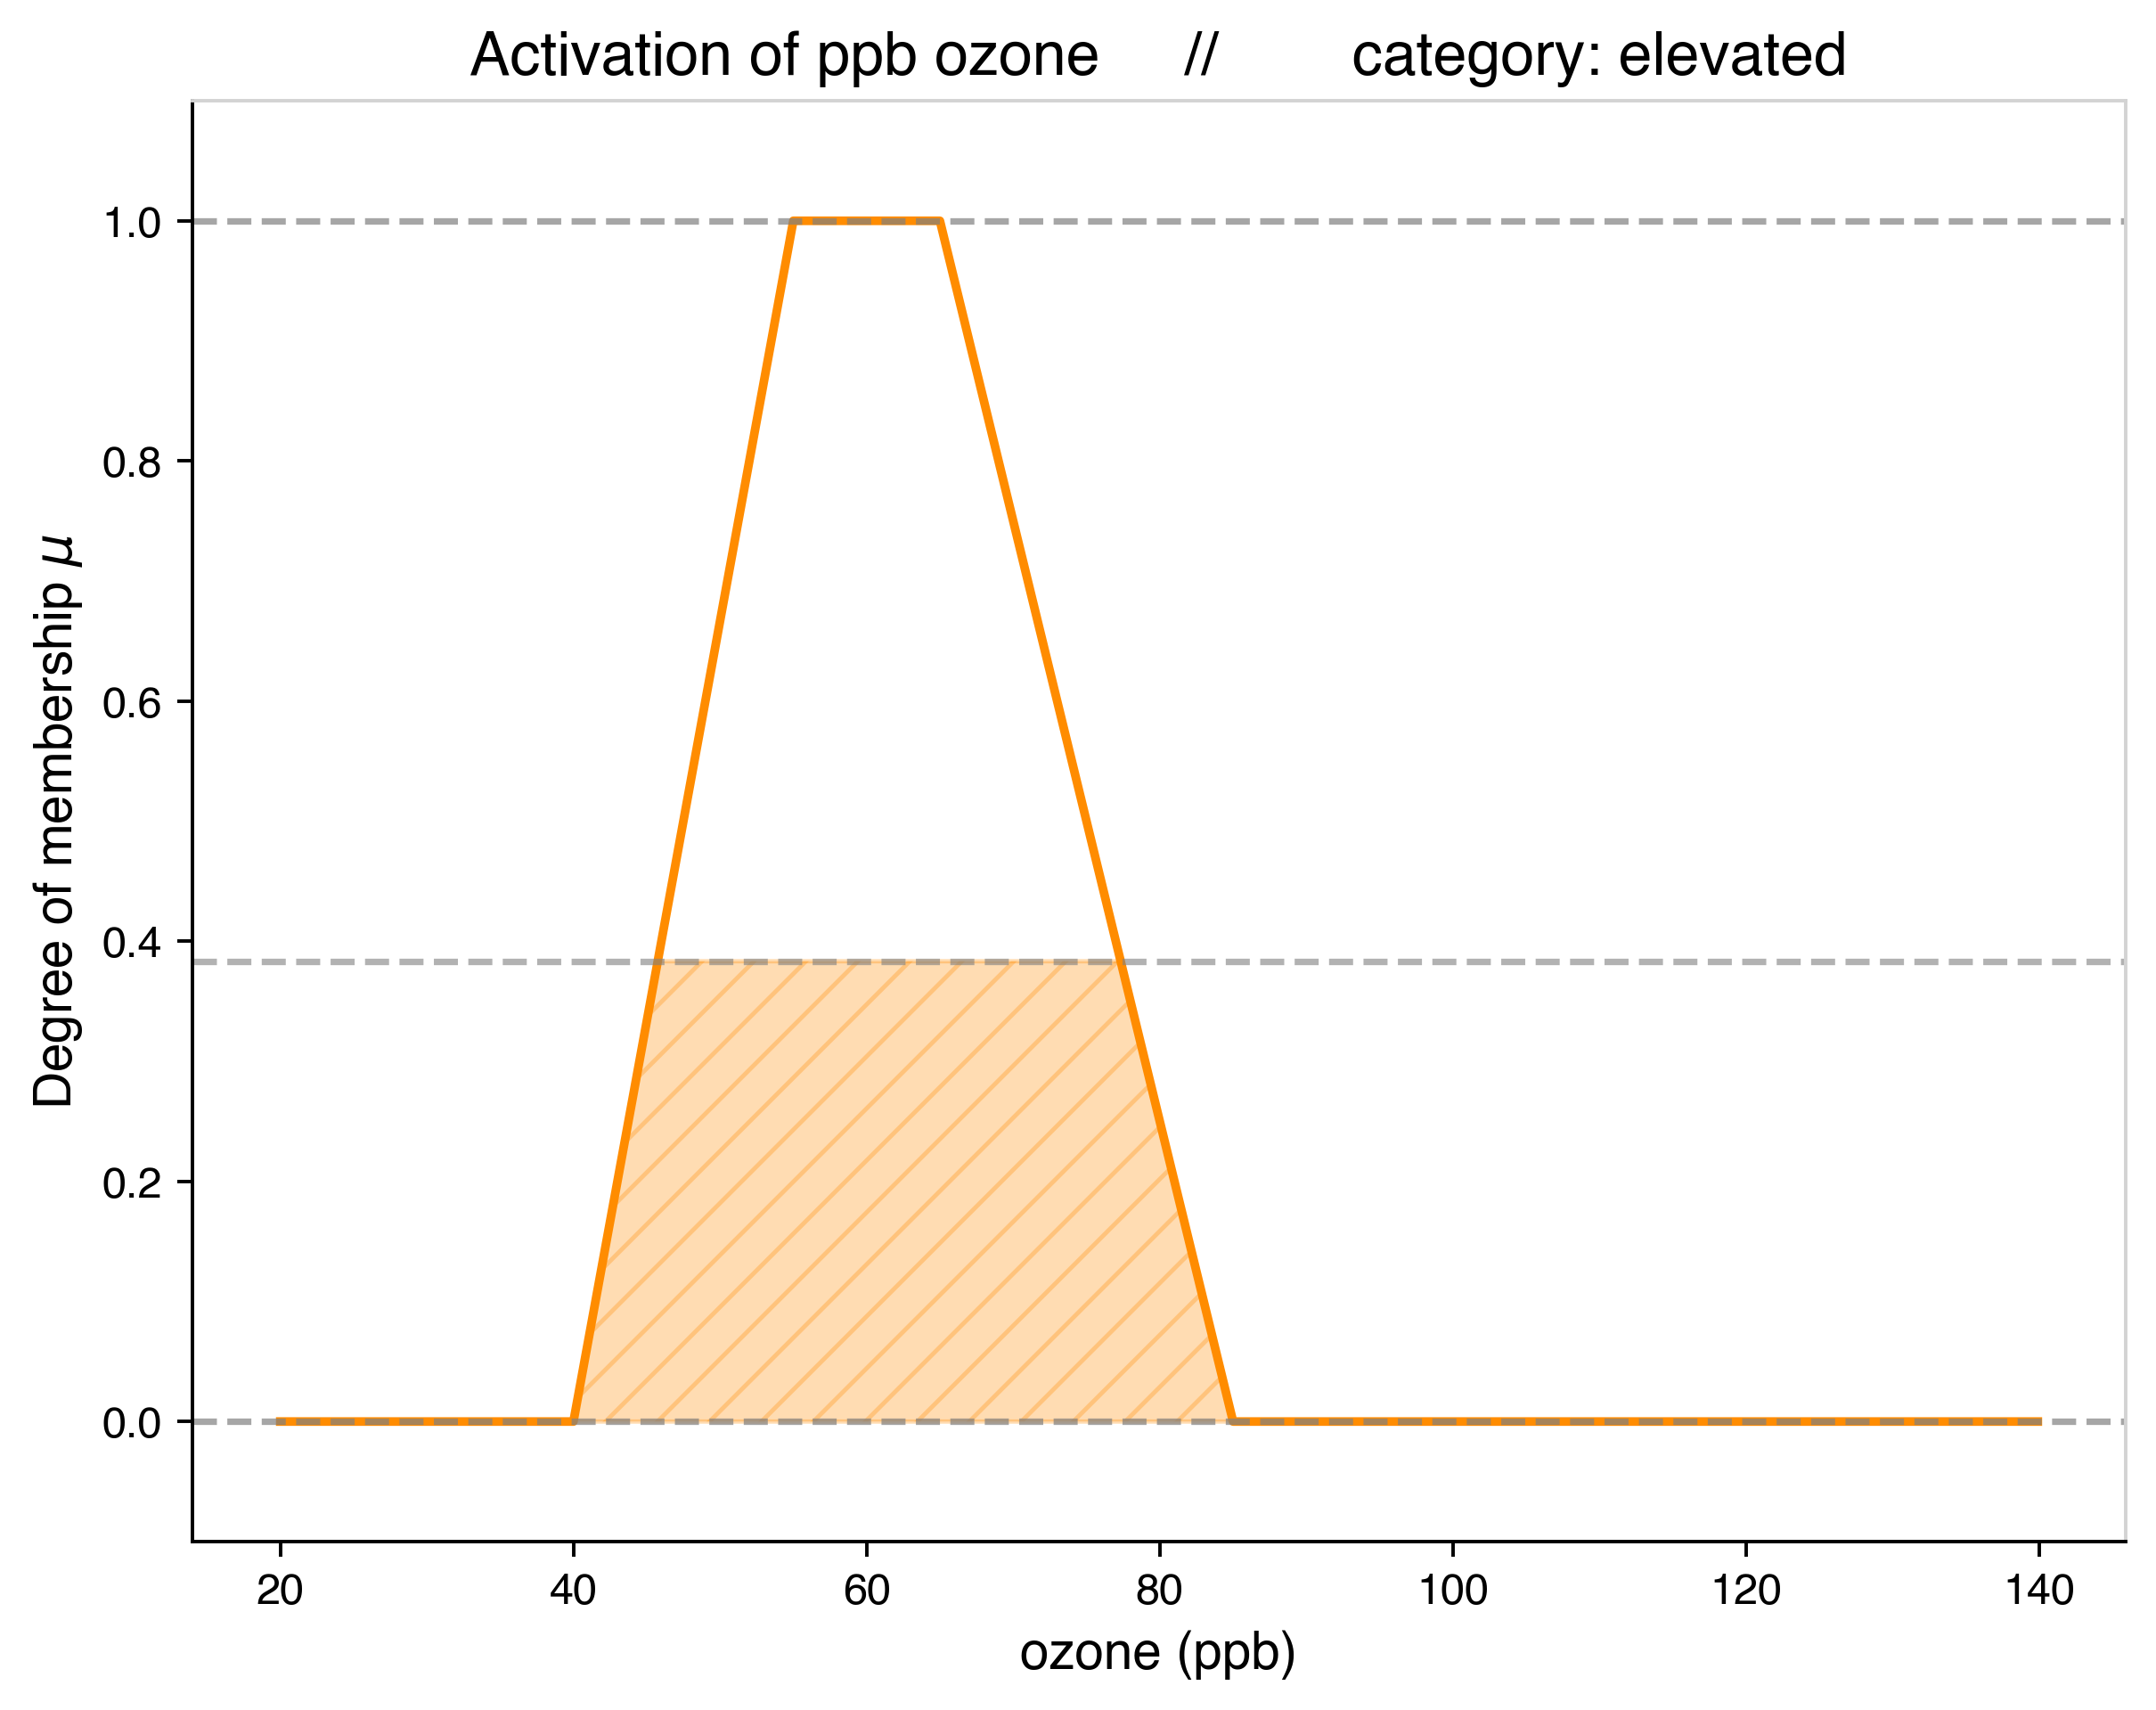

In [58]:
# Finally, the activation of ozone!
# This is the minimum of the two membership values
activation1 = min(snow_membership, wind_membership)
print(activation1)

# Shown graphically:
fig, ax, y1 = plot_activation(x_uod=ozone_uod, mf_func=ozone_mfs["elevated"], y_value=activation1,
                                fuzz_color=ozone_cats["elevated"], category_label="elevated", variable_name="ozone",
                                vrbl_unit="ppb", return_activation_y=True)

In [59]:
# We'll use TikZ to draw the fuzzy inference diagram in terms of linking?
# Keep colour use consistent 
# 

0.2333333333333334
0.2333333333333334


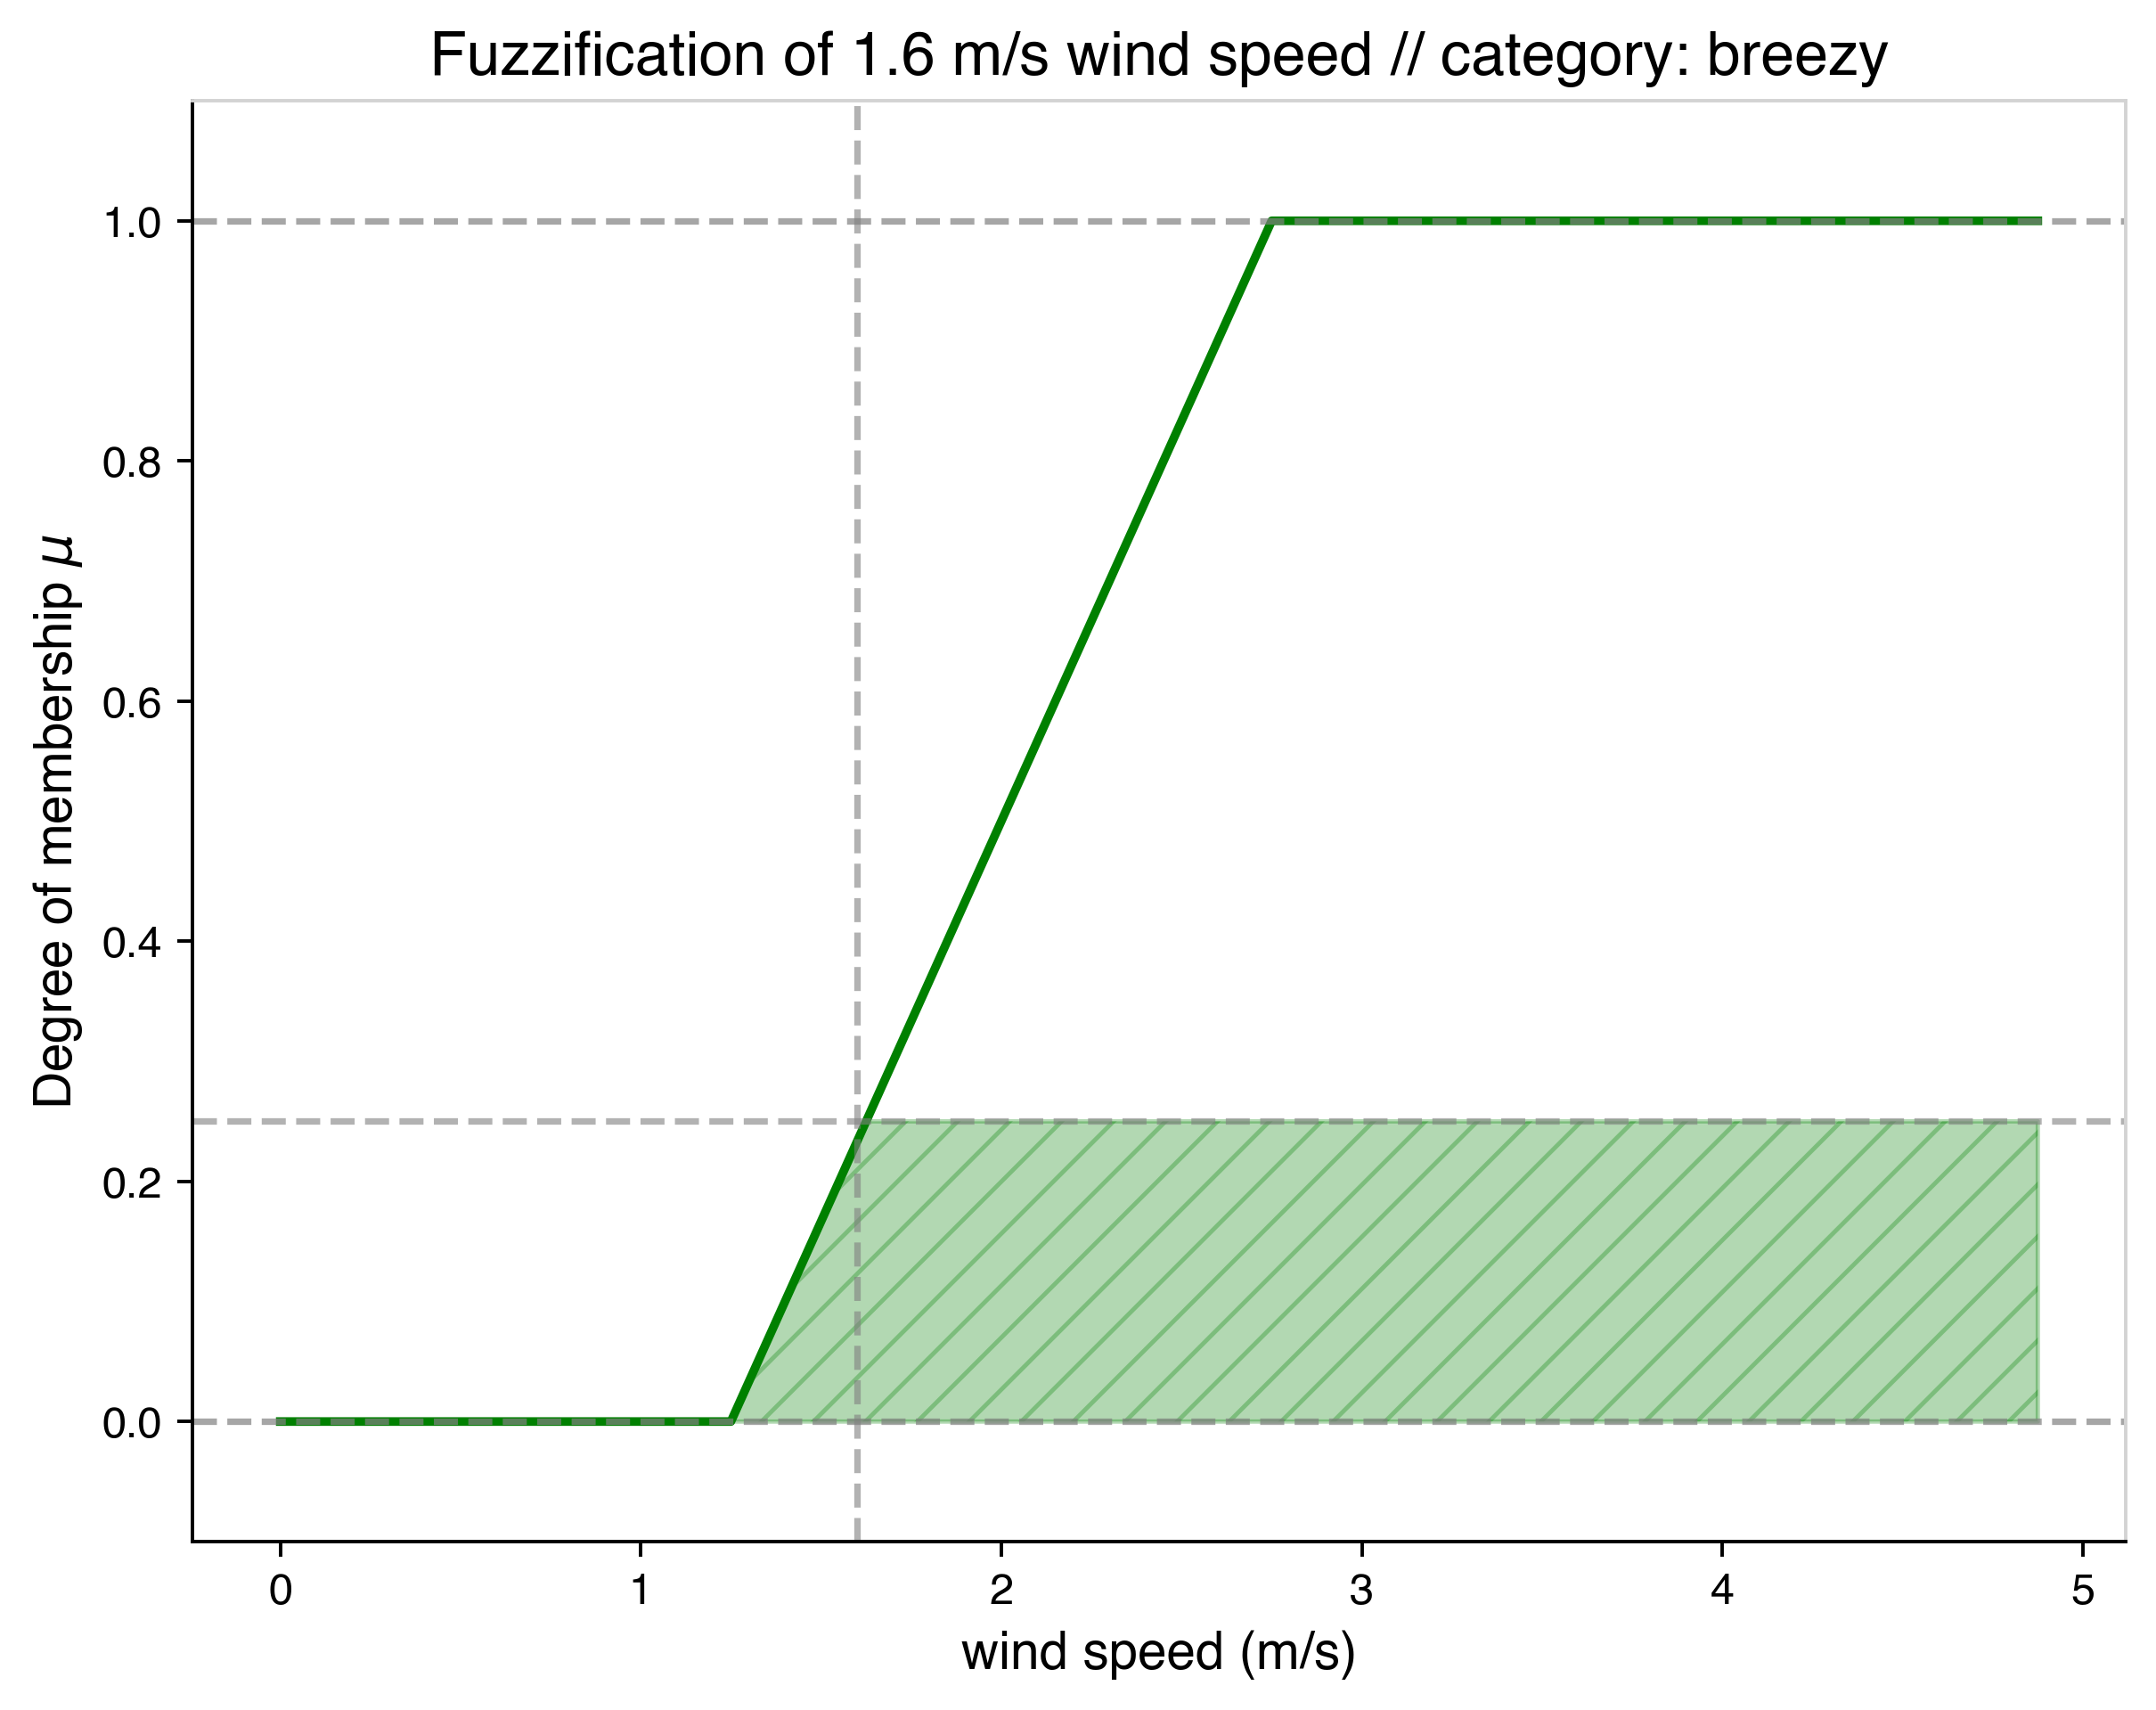

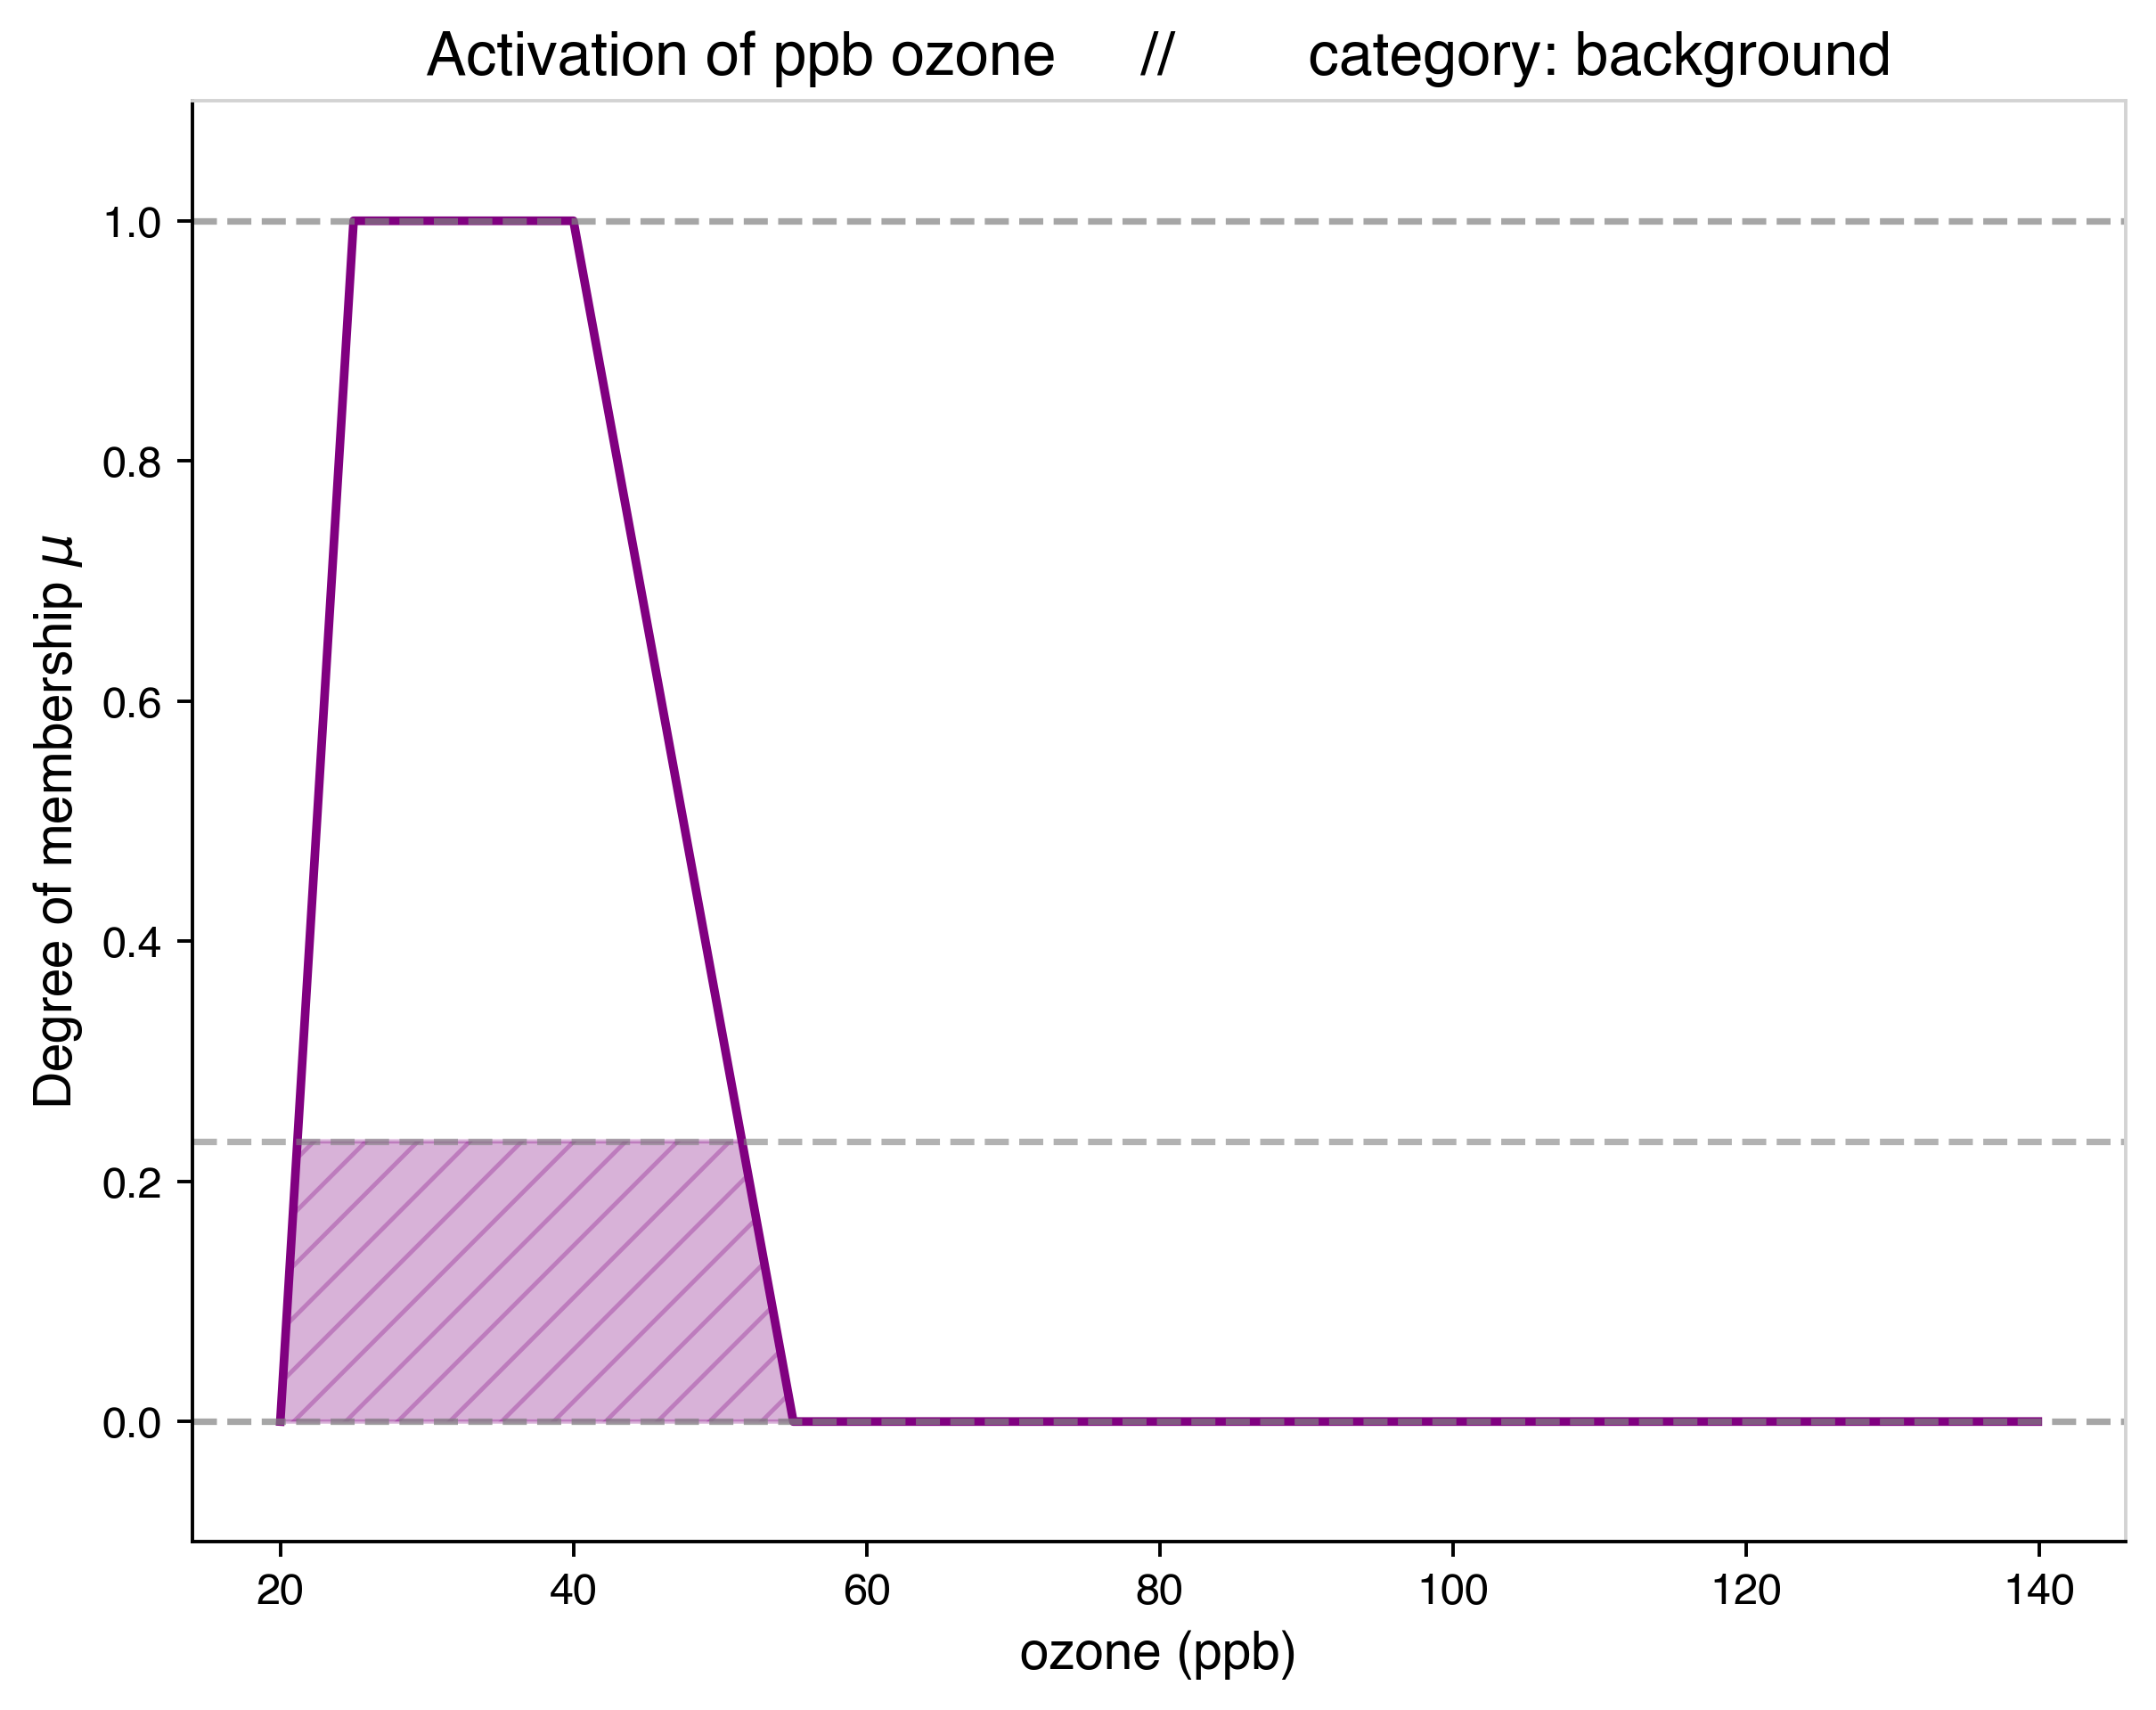

In [60]:
# Let's take rule 2 as "if wind is breezy, ozone is background"

# Fuzzify the wind value
wind_membership = np.interp(wind_value, wind_uod, wind_breezy)
print(wind_membership)

# Shown graphically:
fig, ax = plot_fuzzification(x_uod=wind_uod, mf_func=wind_breezy, x_value=wind_value, 
                                fuzz_color="green", category_label="breezy", variable_name="wind speed",
                                vrbl_unit="m/s", direction="increasing")

# Activation of ozone
activation2 = wind_membership
print(activation2)

# Shown graphically:
fig, ax, y2 = plot_activation(x_uod=ozone_uod, mf_func=ozone_mfs["background"], y_value=activation2, 
                                fuzz_color="purple", category_label="background", variable_name="ozone",
                                vrbl_unit="ppb", return_activation_y=True)

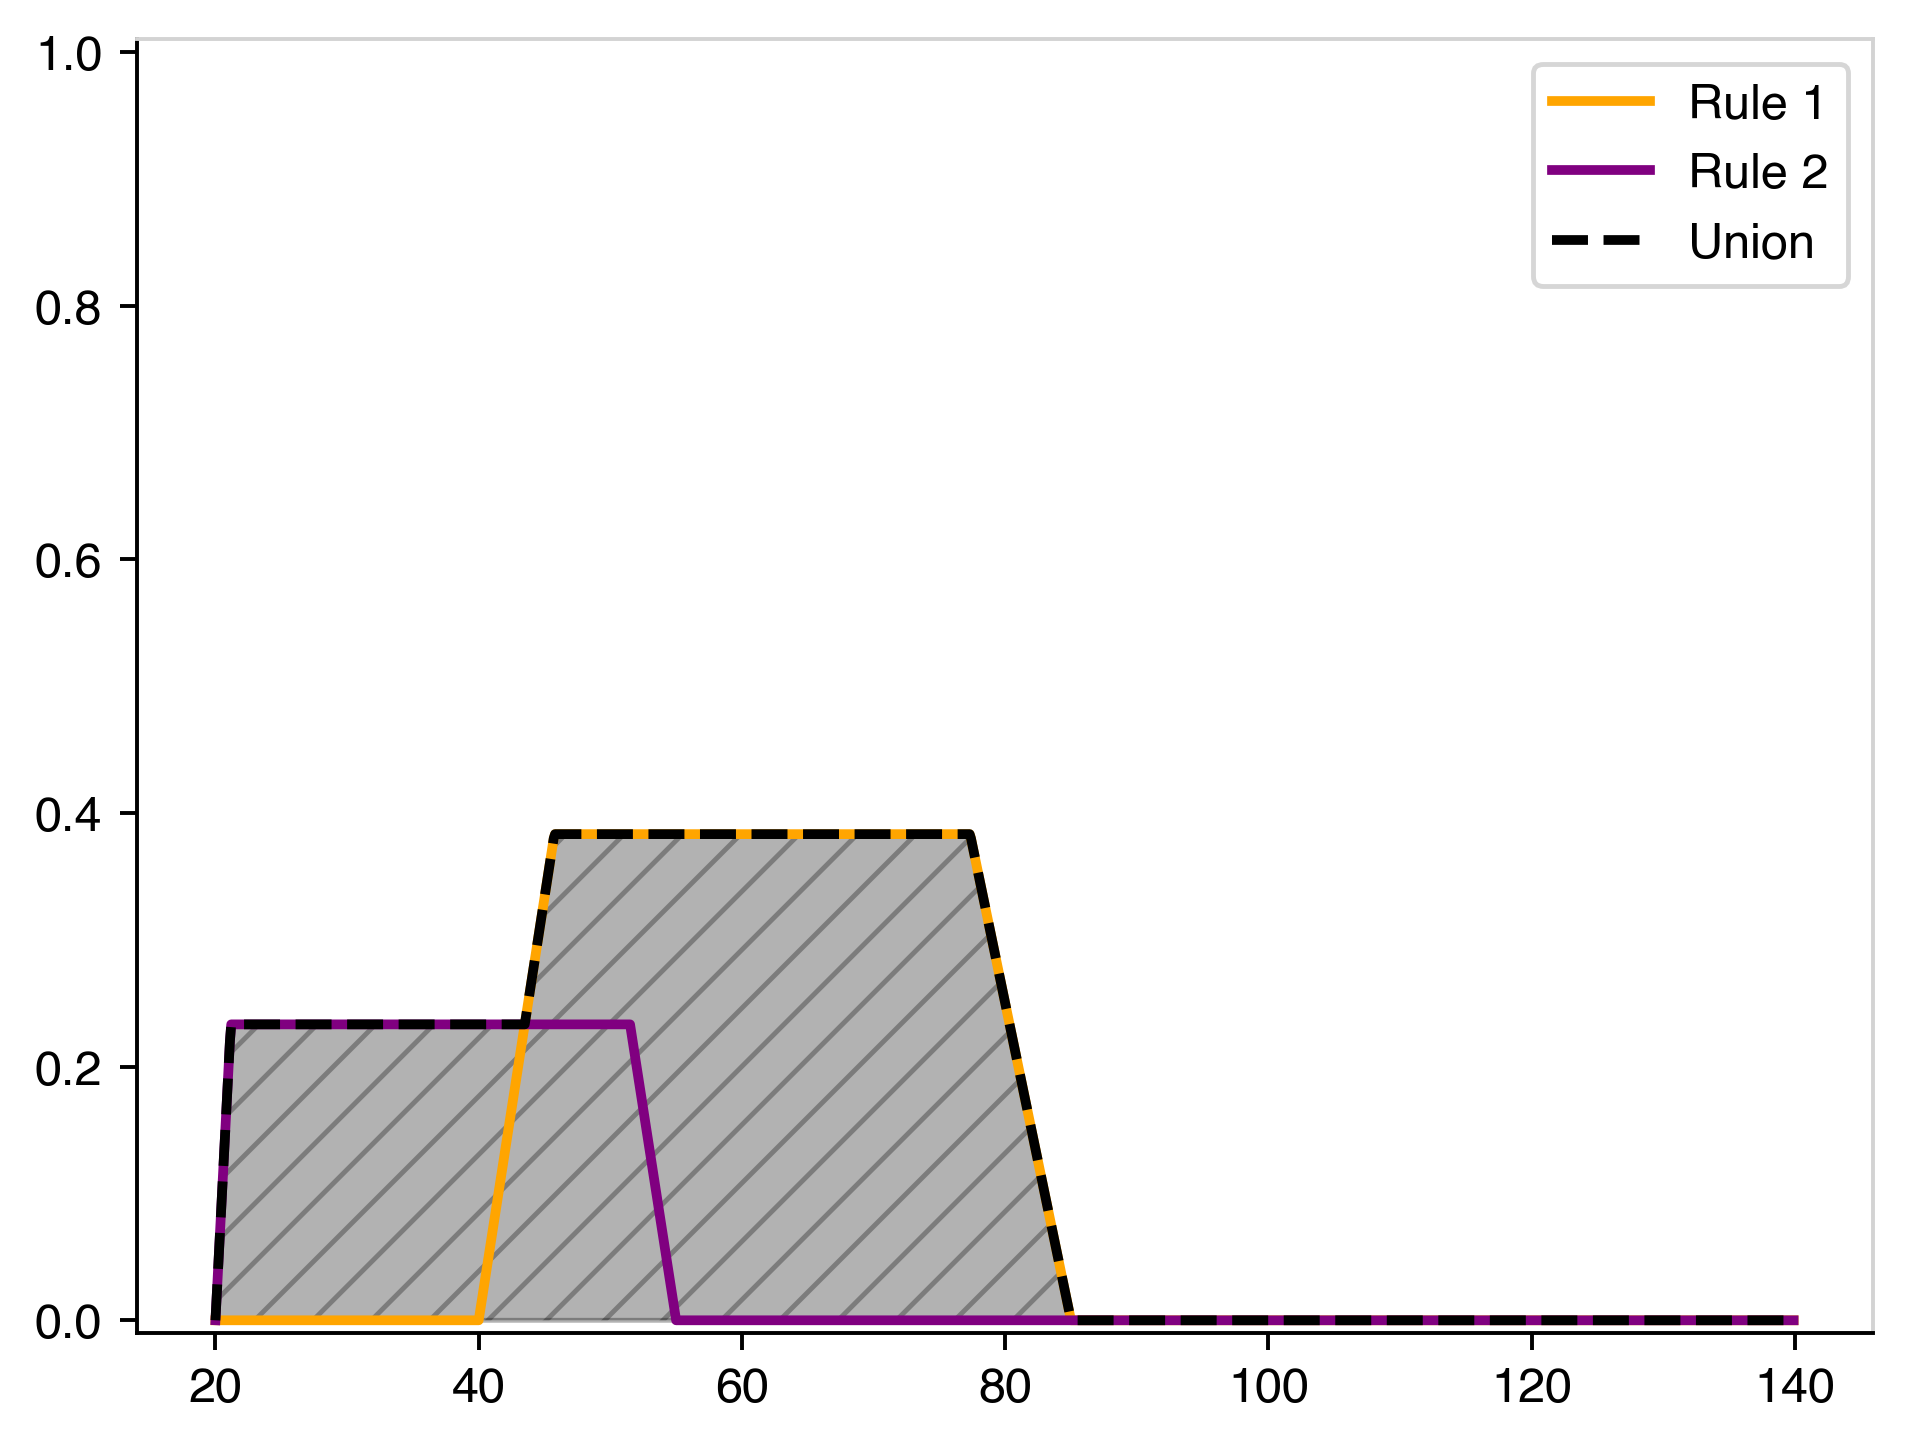

In [61]:
# Now we need to combine the two rules
# We'll use the maximum of the two activation values
combined_activation = max(activation1, activation2)

# These y values are the clipped values of the activation functions

# Can also show this with our union plot! 
activation_mf_arrays = {
    "Rule 1": y1,
    "Rule 2": y2,
}

plot_colors = {
    "Rule 1": "orange",
    "Rule 2": "purple"
}

fig, ax, y_agg = make_mf_figure(ozone_uod, activation_mf_arrays, 
                        plot_union=True, plot_colors=plot_colors,return_aggregated=True)

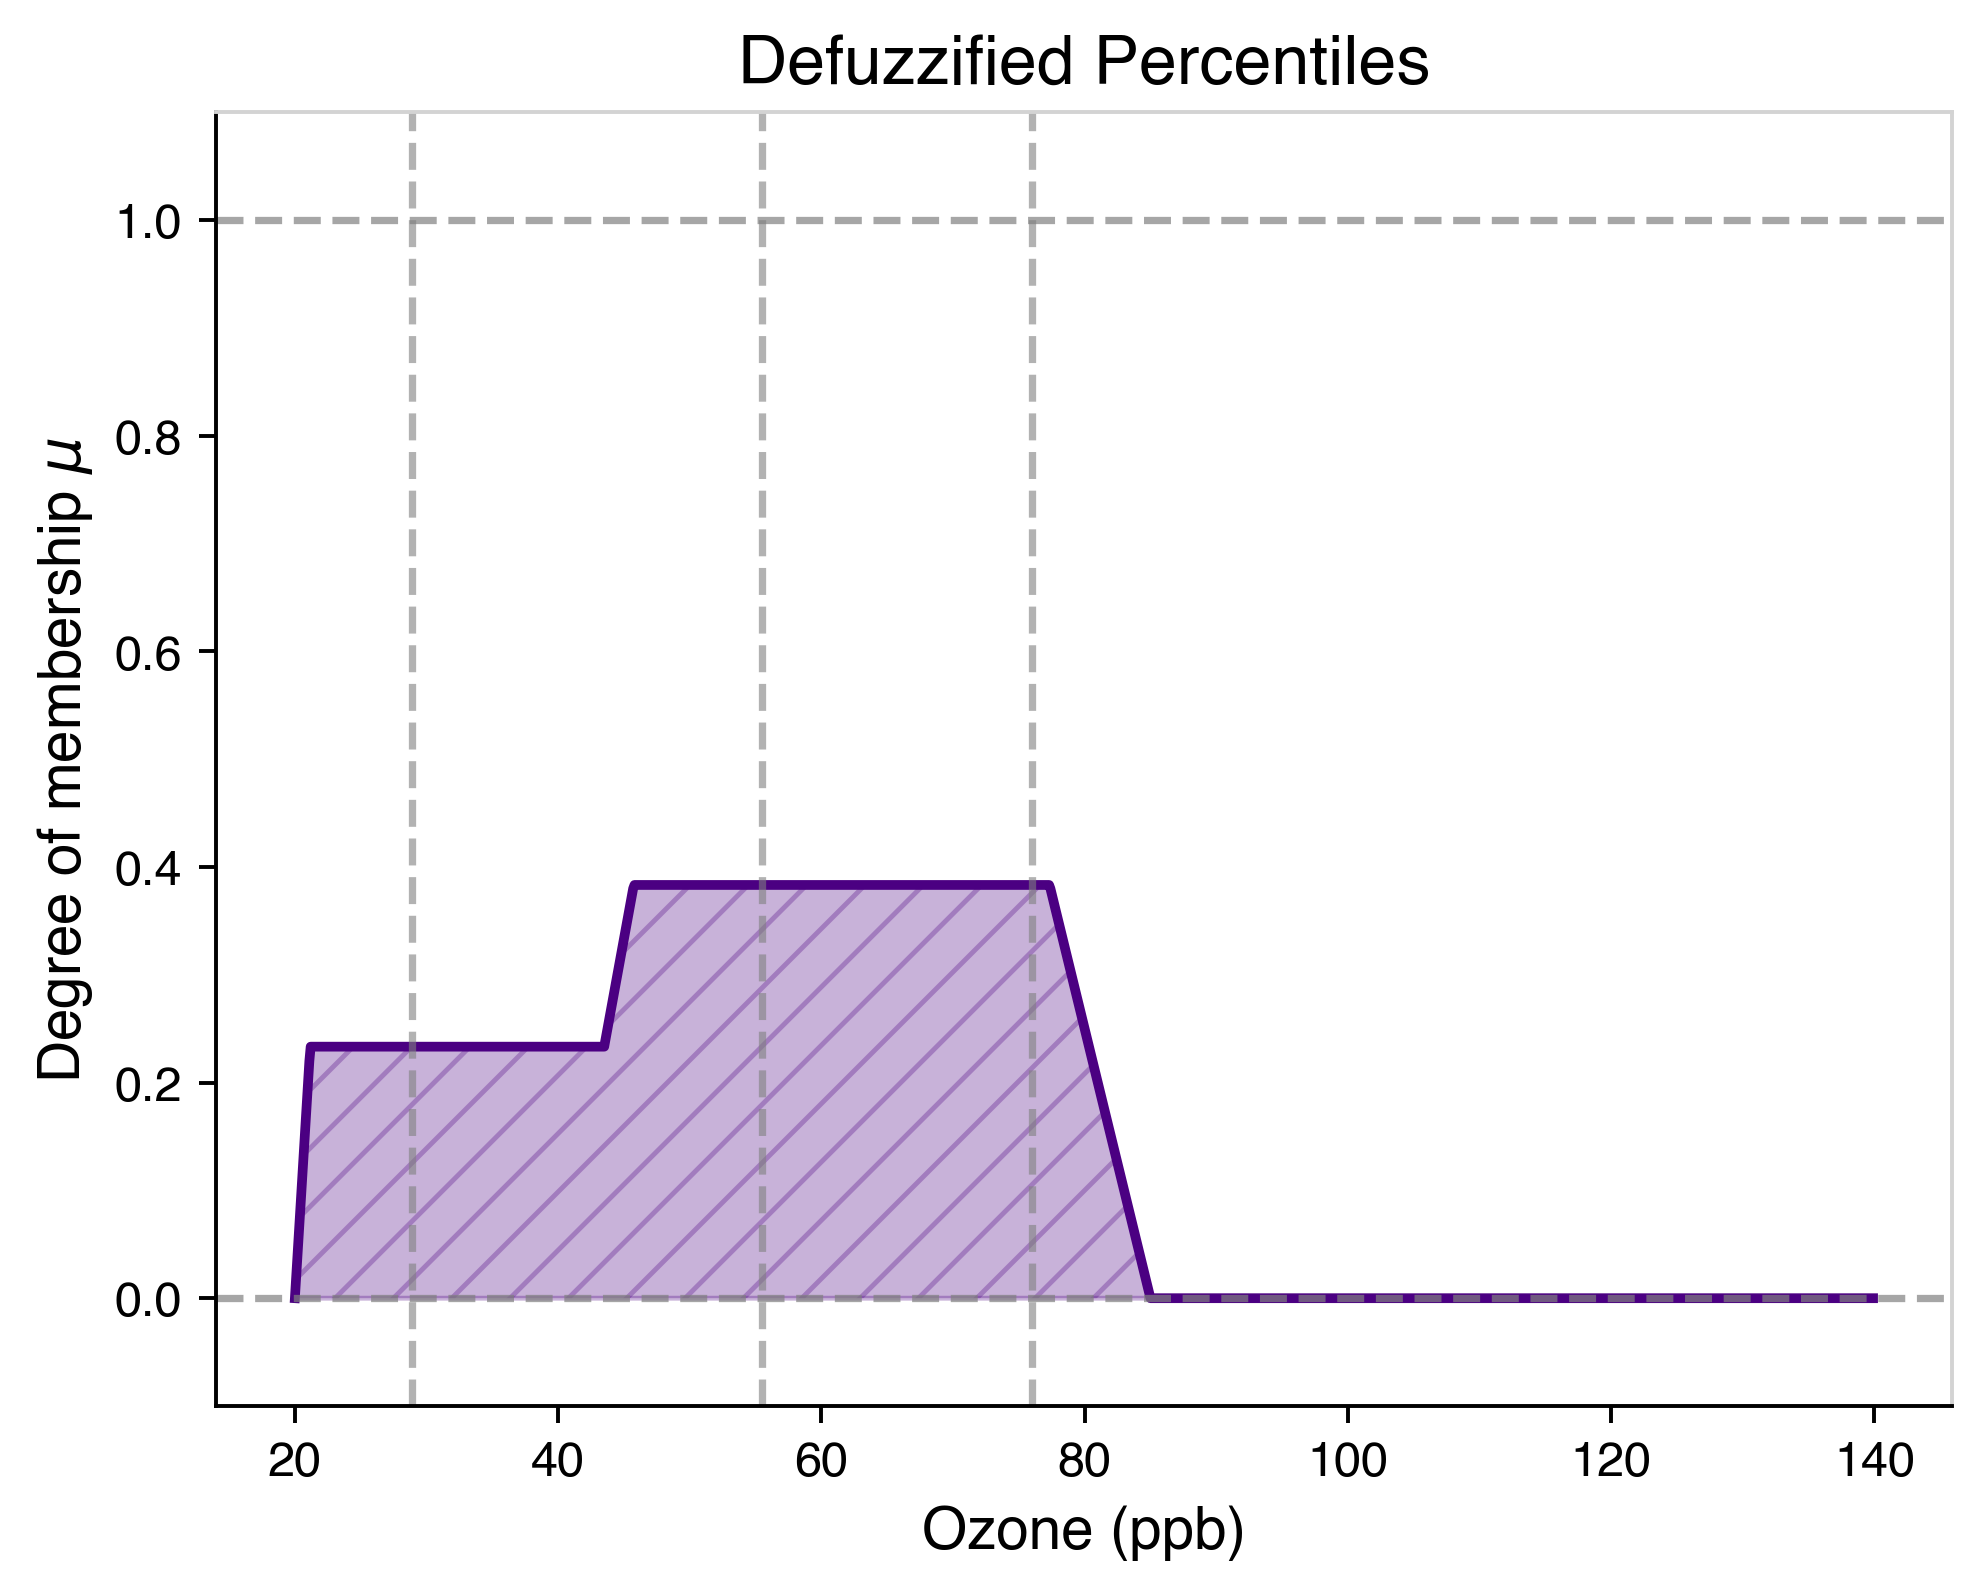

10th Percentile (Risk-Averse): 28.900000000000126
50th Percentile (Best Guess/Neutral): 55.500000000000504
90th Percentile (Risk-Tolerant): 76.0000000000008


In [62]:
percentiles = defuzzify_percentiles(ozone_uod, y_agg, percentiles=[10, 50, 90], 
                                        do_plot=True, plot_fill=True)

print("10th Percentile (Risk-Averse):", percentiles['10th percentile'])
print("50th Percentile (Best Guess/Neutral):", percentiles['50th percentile'])
print("90th Percentile (Risk-Tolerant):", percentiles['90th percentile'])

# Possibilistic risk communication
Now we communicate risk, via the activation of each fuzzy set, as the plausibility of each category of ozone.


In [63]:
poss_dict = {"Background": activation2, "Elevated": activation1, "Extreme": 0}


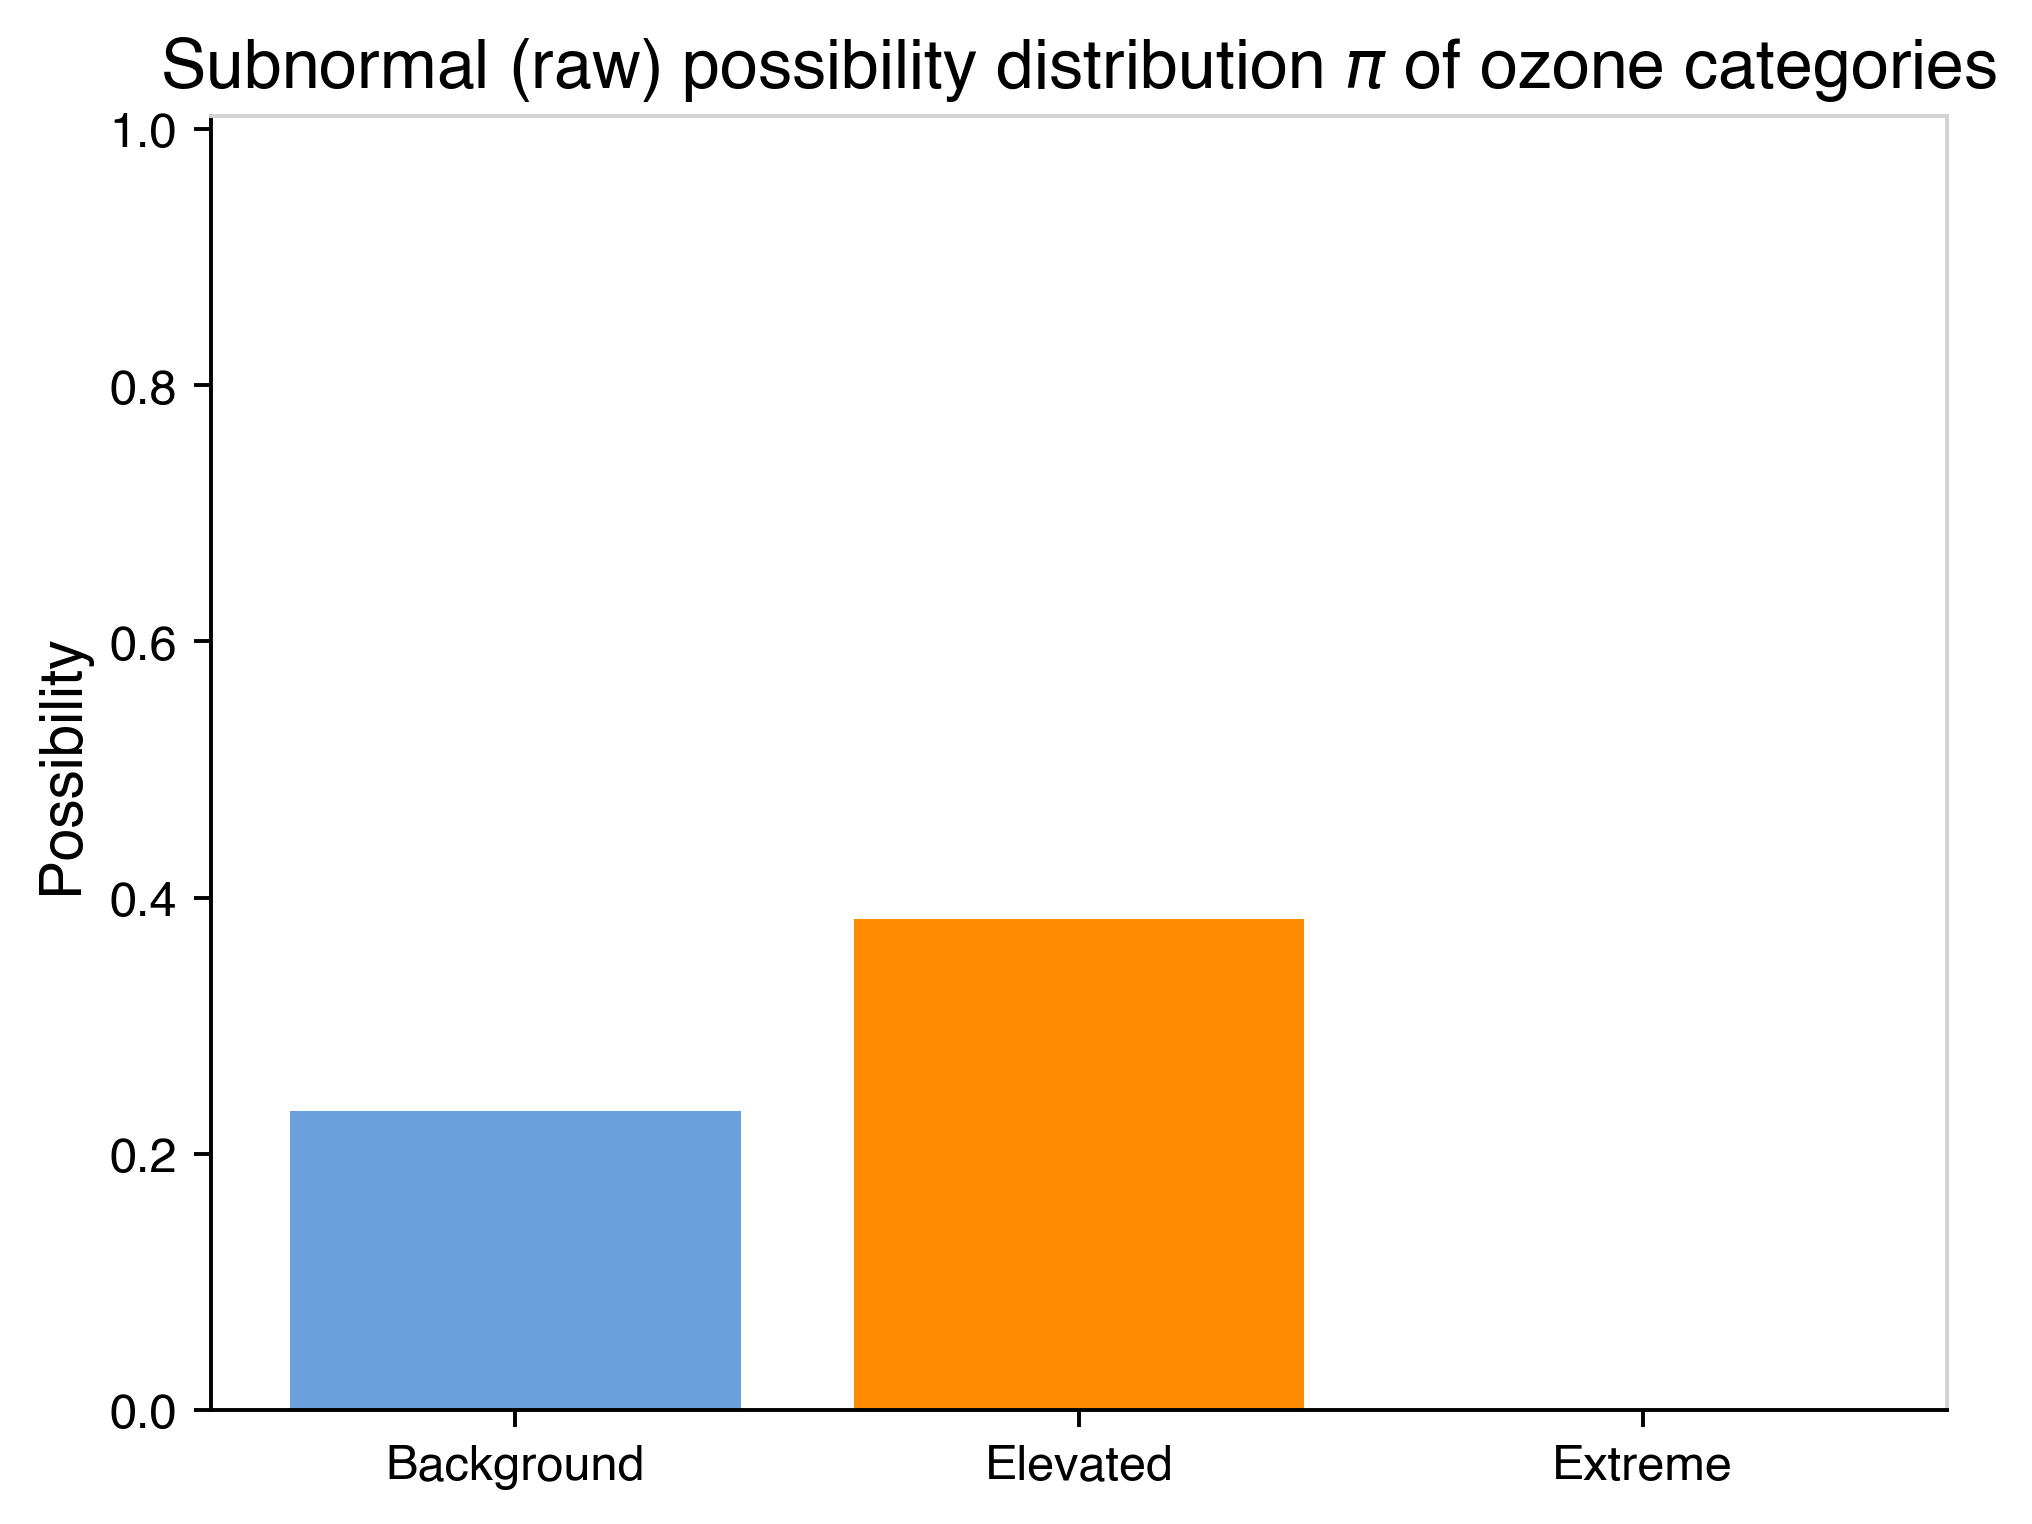

In [64]:
plot_possibility(poss_dict, colors=ozone_cats.values())

## Interpretation
Possibilities. The missing activation suggests we haven't "covered" outcomes, especially for extreme. 

## Normalisation
To create necessities, we can normalise to ensure max(pi) = 1, i.e., rules of possibility theory are met. To preserve the system's ignorance, further to the "entropy" of possibility distribution (which type of uncertainty? Epistemic or aleatory?), we can create a residual-style "unsure" category on top of the fuzzy sets.

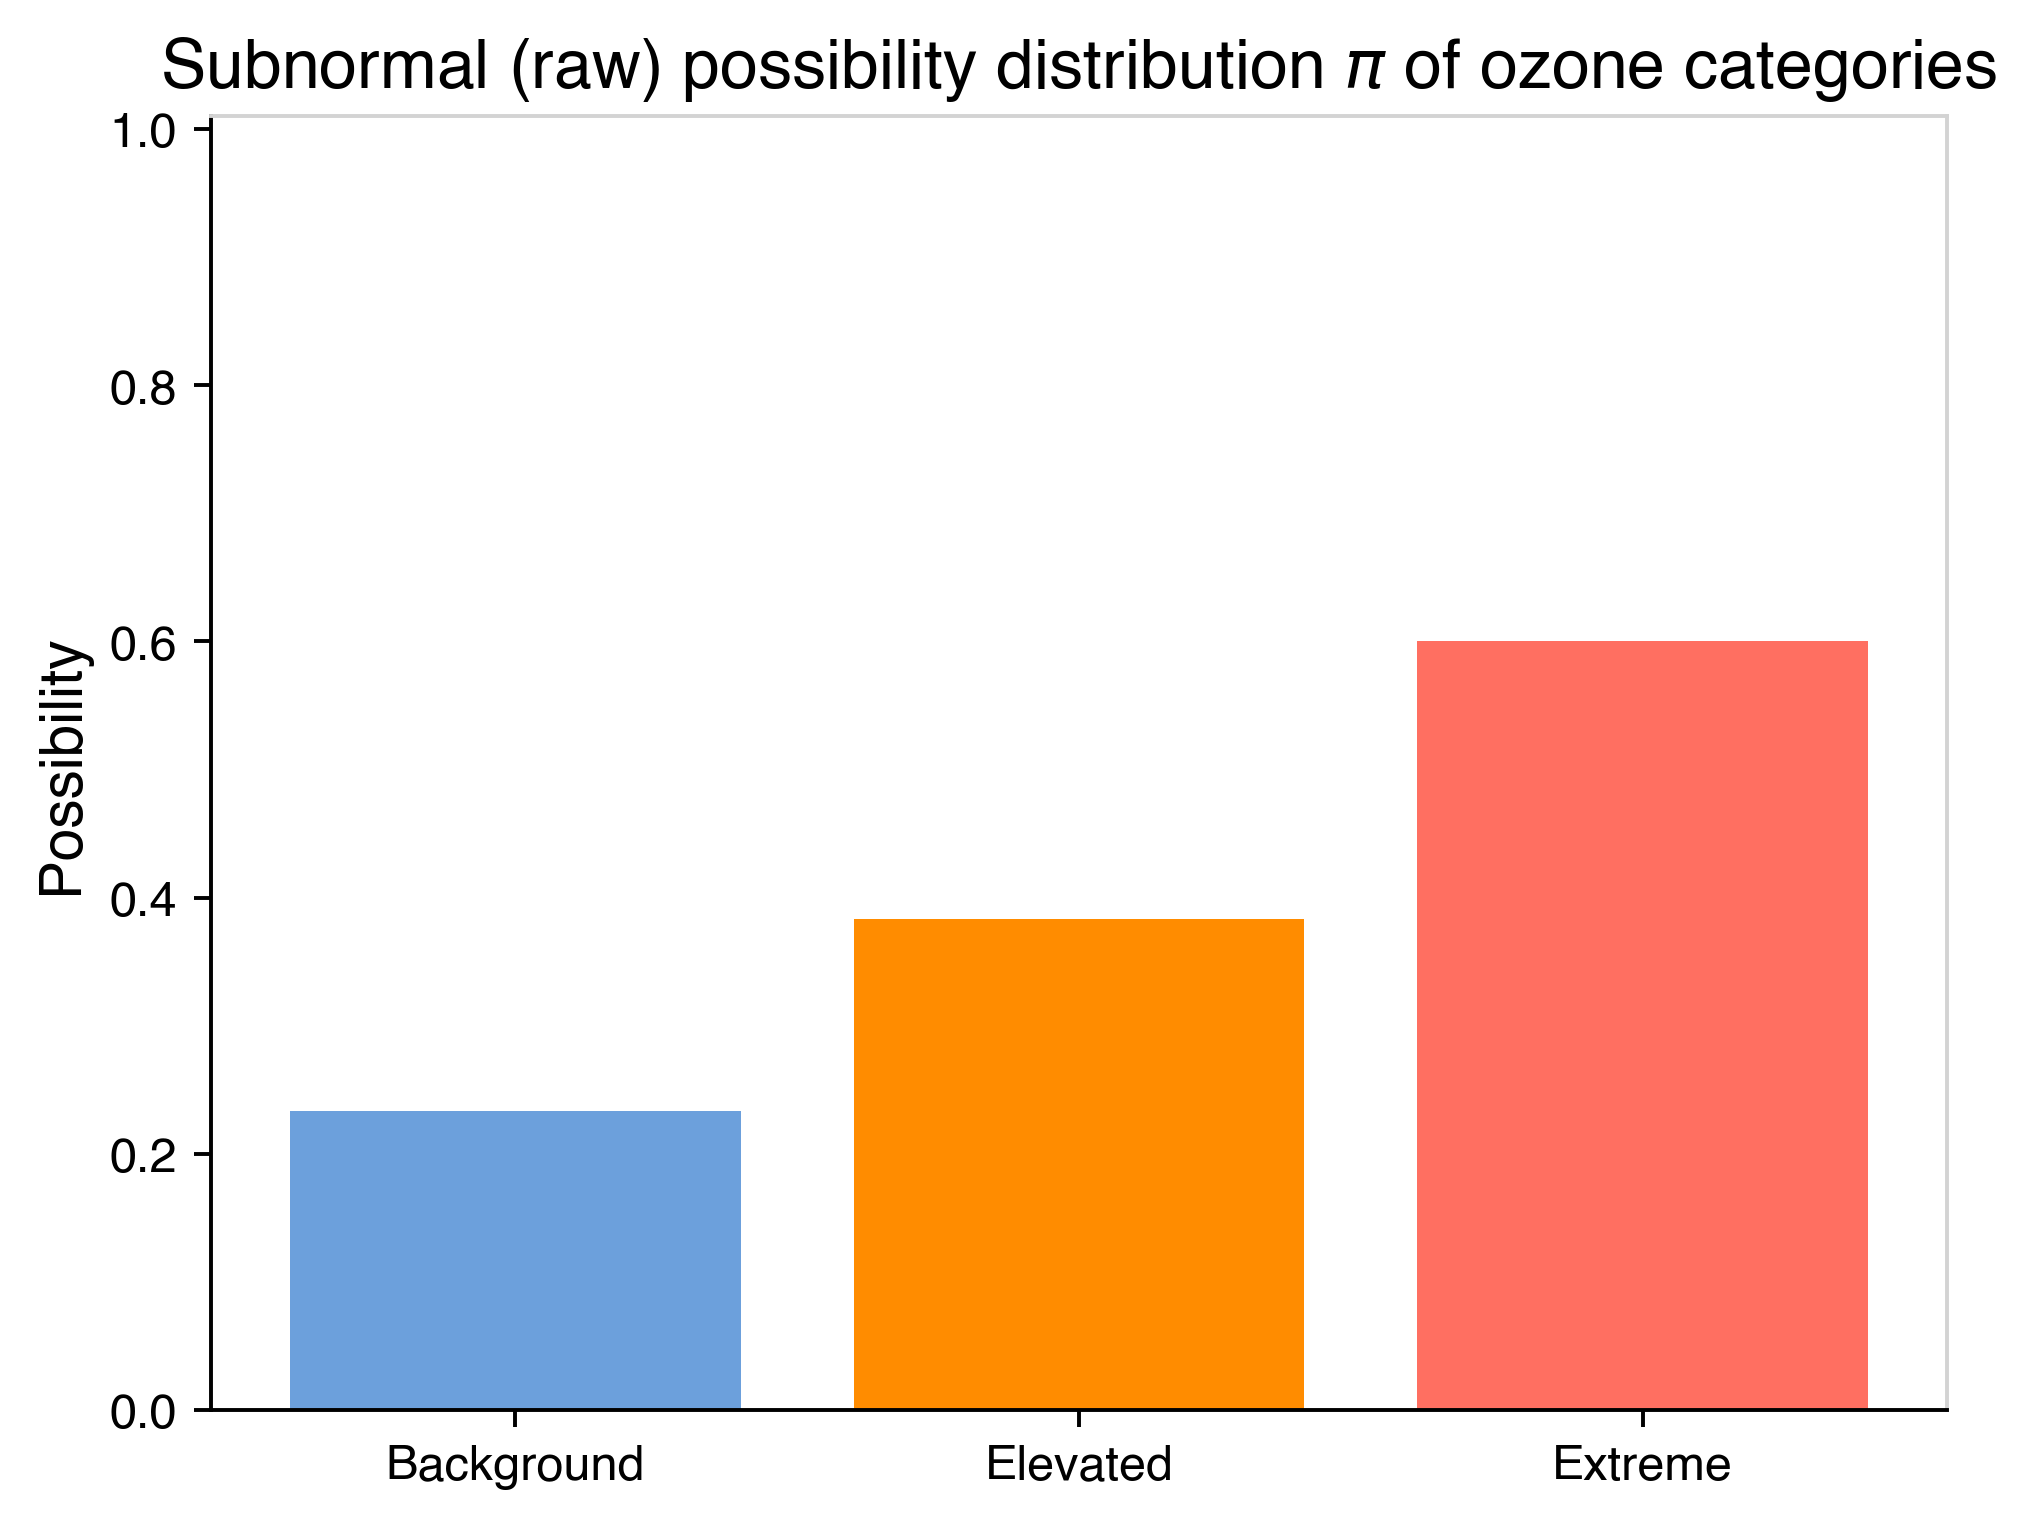

In [65]:
# let's add an activation of 0.6 for the "extreme" category for the sake of this study.
# Can see how the aggegation-method crisp values can be misleading or very wide bounds
# Let's see the "possibilistic view"
poss_dict["Extreme"] = 0.6
plot_possibility(poss_dict, colors=ozone_cats.values())


In [66]:

# Add a "unsure" set then normalise the possibilities 

# "Unsure" represents the possibilities that are missed by the system
# 1 - max(pi) 
# Then we normalise to ensure max(pi) = 1

poss_dict["Unsure"] = 1 - max(poss_dict.values())

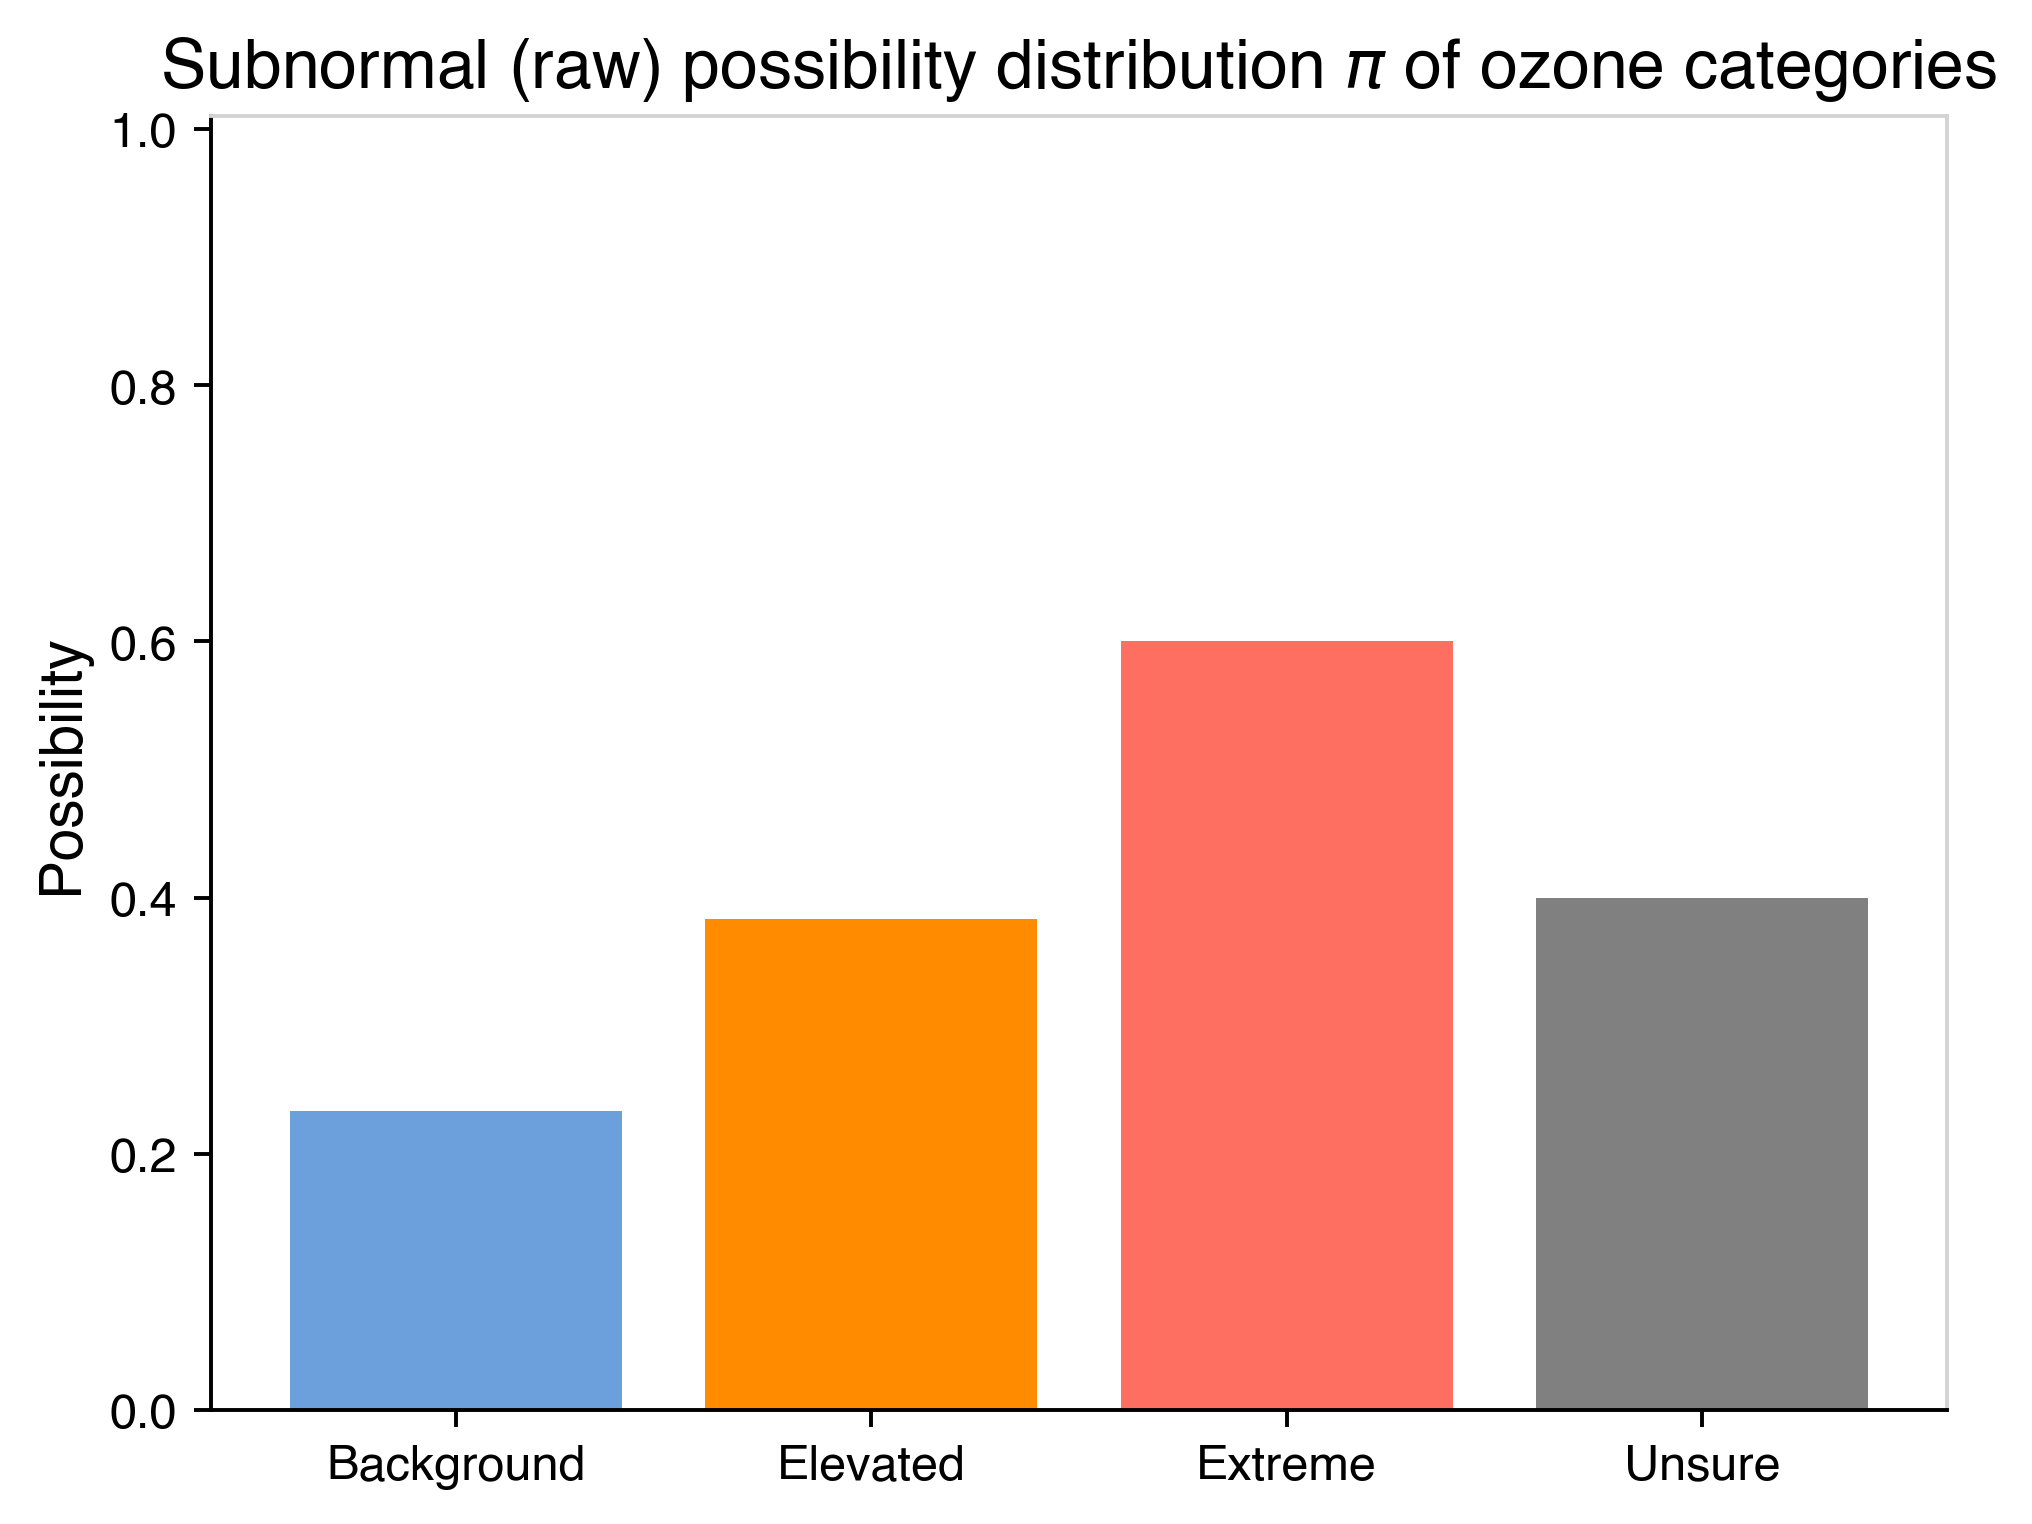

In [67]:
bar_colours = list(ozone_cats.values()) + ['grey']
plot_possibility(poss_dict, colors=bar_colours)


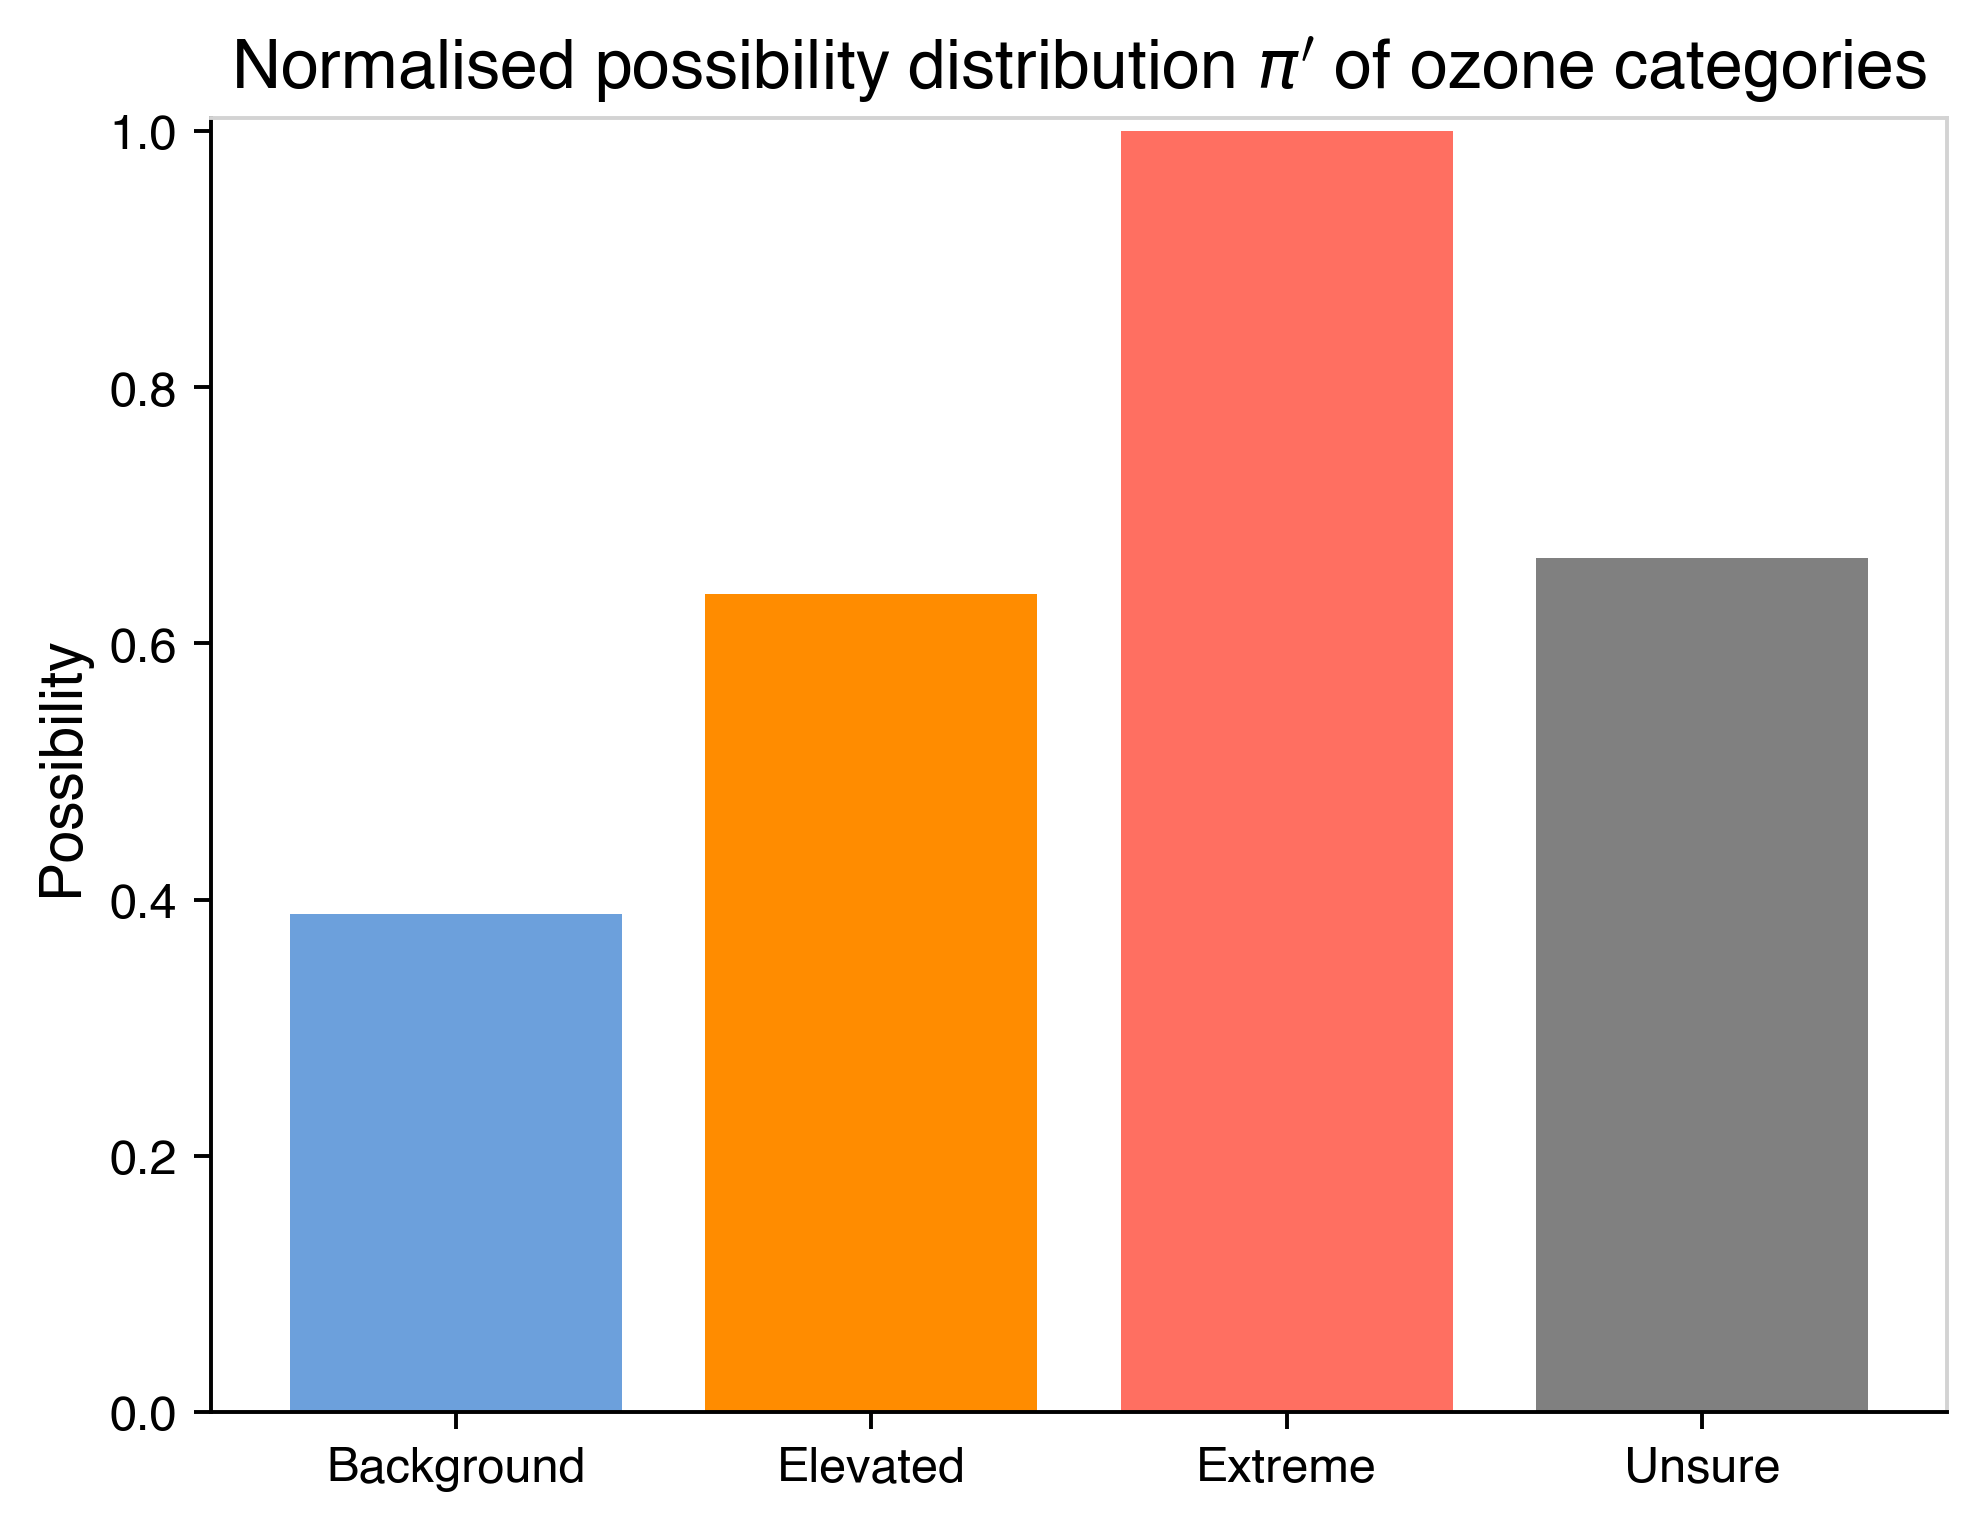

In [68]:
# Let's create a new dictionary with the normalised values and re-plot
norm_poss_dict = normalize_possibility(np.array(list(poss_dict.values())))
norm_poss_dict = dict(zip(poss_dict.keys(), norm_poss_dict))

plot_possibility(norm_poss_dict, colors=bar_colours)


### Necessity
Now we can compute the necessity of each category of ozone. This is the dual of possibility, and is defined as...

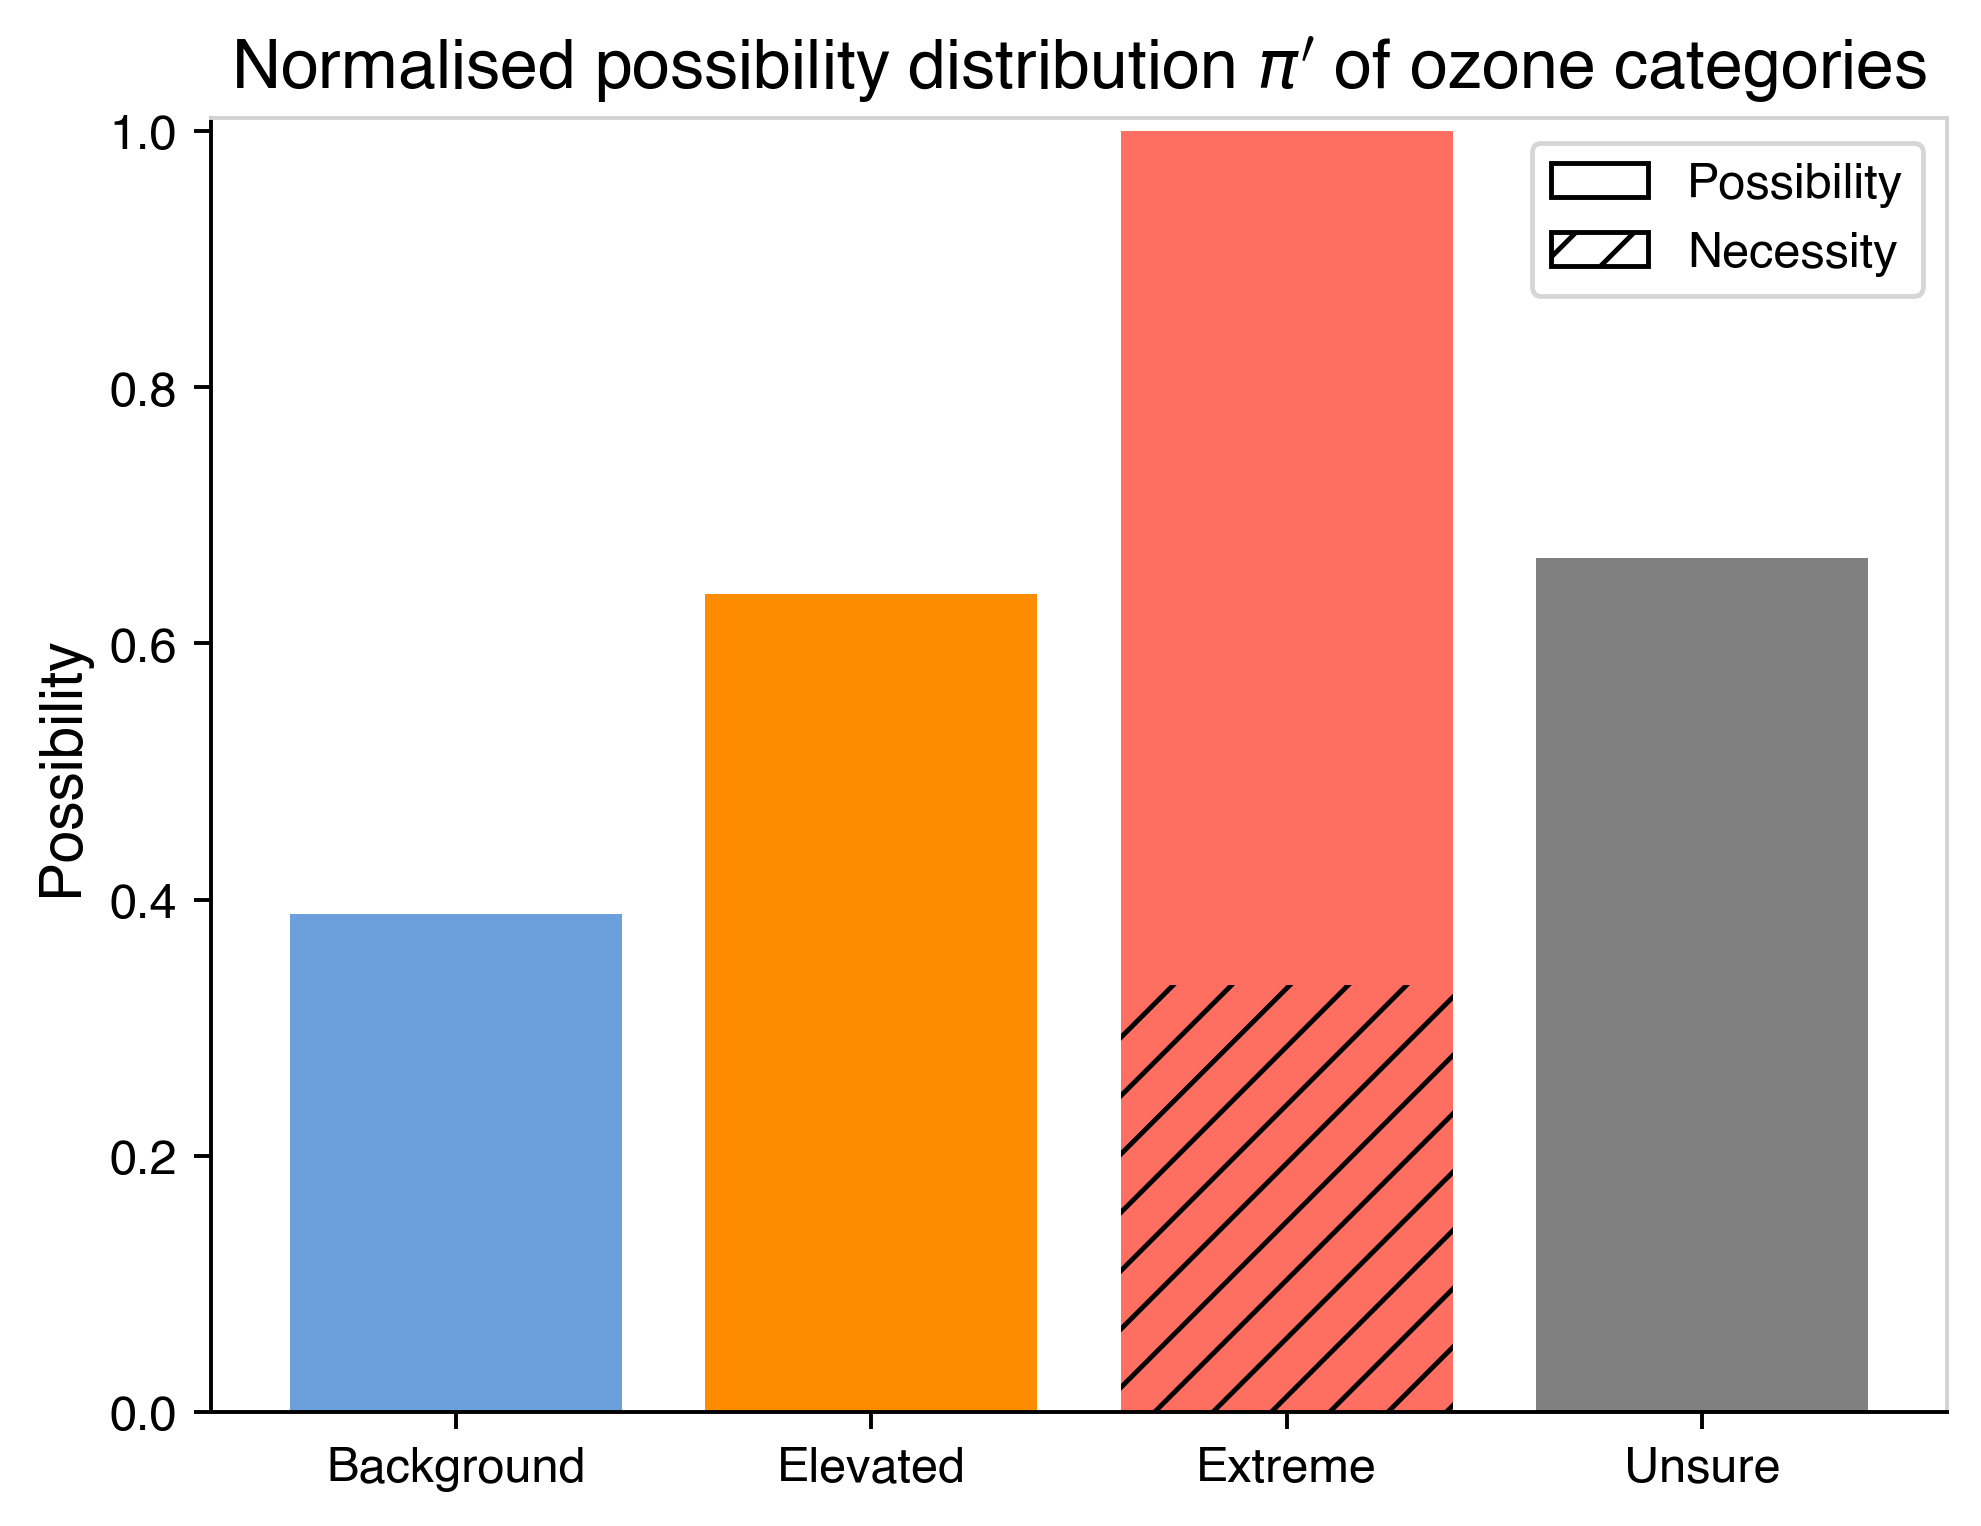

In [69]:
# For each fuzzy set category we will add necessity 
# Neceassity: 1 - the possibility of the complement (max of other categories)
norm_necess_dict = {}

for category in norm_poss_dict.keys():
    # Find the maximum of the other categories
    max_other_categories = max([norm_poss_dict[cat] for cat in norm_poss_dict.keys() if cat != category])
    norm_necess_dict[category] = 1 - max_other_categories
    
# The necessity values will already be normalised, i believe.

# Plot the necessity values
plot_possibility(norm_poss_dict, norm_necess_dict, colors=bar_colours)

# TODO - colour the possibility bar = 1 a certain colour so legend can show that?

# TODO - as "elevated" and "extreme" overlap, does necessity make sense?
# Would a certain scenario generate an erraneously "split" distribution in
# possibilities and therefore necessities? Normalisation means one of these
# categories' possibility is 1 so the necessity is 0 for the other. However, a slight
# change, where both categories were 1, would mean the necessity would be 0 for both.
# That's accounted for, because the necessity would be really small in both cases for both categories.

# Any other situations where this overlap of categories (non-independence) would be a problem?
# TODO - here 

In [70]:
# Computing an information/entropy-like measure for the aggregated possibility distribution
# This can be a measure of certainty
# Question is - do we use normalized?
# Shouldn't include "unsure" as it's not a real outcome 
# TODO - possibility entropy to measure uncertainty (spread of categories; low necessity)
# Q - would it be larger for overall-larger values of possibility? Is that a bad thing? 

